# Faster-rcnn model

In [35]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader
import os

# Define paths
train_images = '/home/aojwang/data/yolo_dataset/train/images'
train_ann = '/home/aojwang/data/yolo_dataset/train/train_coco.json'
val_images = '/home/aojwang/data/yolo_dataset/val/images'
val_ann = '/home/aojwang/data/yolo_dataset/val/val_coco.json'

# Define transforms
def get_transform():
    return T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])

# Create dataset loaders
class CocoDetectionWithTransforms(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': torch.tensor(image_id),
                  'boxes': [],
                  'labels': []}
    
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
    
        for ann in anns:
            bbox = ann['bbox']
            x, y, w, h = bbox
            if w < 1 or h < 1:
                continue
            target['boxes'].append([x, y, x + w, y + h])
            target['labels'].append(ann['category_id'])
    
        # If there are no boxes, try next image
        if len(target['boxes']) == 0:
            return self.__getitem__((idx + 1) % len(self))
    
        target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.tensor(target['labels'], dtype=torch.int64)
    
        if self.transforms:
            img, target = self.transforms(img, target)
    
        return img, target


# Load datasets
train_dataset = CocoDetectionWithTransforms(train_images, train_ann, get_transform())
val_dataset = CocoDetectionWithTransforms(val_images, val_ann, get_transform())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item():.4f}")

# Save model
torch.save(model.state_dict(), "fasterrcnn_trained.pth")
print("Model saved.")


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch [1/10], Loss: 0.2704
Epoch [2/10], Loss: 0.1637
Epoch [3/10], Loss: 0.1213
Epoch [4/10], Loss: 0.1034
Epoch [5/10], Loss: 0.1947
Epoch [6/10], Loss: 0.1719
Epoch [7/10], Loss: 0.1058
Epoch [8/10], Loss: 0.1027
Epoch [9/10], Loss: 0.0905
Epoch [10/10], Loss: 0.1790
Model saved.


In [39]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load model and replace classifier
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = len(val_dataset.coco.getCatIds()) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load trained weights
model.load_state_dict(torch.load("/home/aojwang/data/model/model/CarboAI/fasterrcnn_trained.pth"))
model.to(device)
model.eval()


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/aojwang/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 367MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [42]:
actual_labels = []
predicted_labels = []

with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_labels = output['labels'].cpu().tolist()
            true_labels = targets[i]['labels'].cpu().tolist()

            # Skip if any of the lists is empty
            if len(pred_labels) == 0 or len(true_labels) == 0:
                continue

            # Ensure the two lists are the same length
            min_len = min(len(pred_labels), len(true_labels))
            actual_labels.extend(true_labels[:min_len])
            predicted_labels.extend(pred_labels[:min_len])


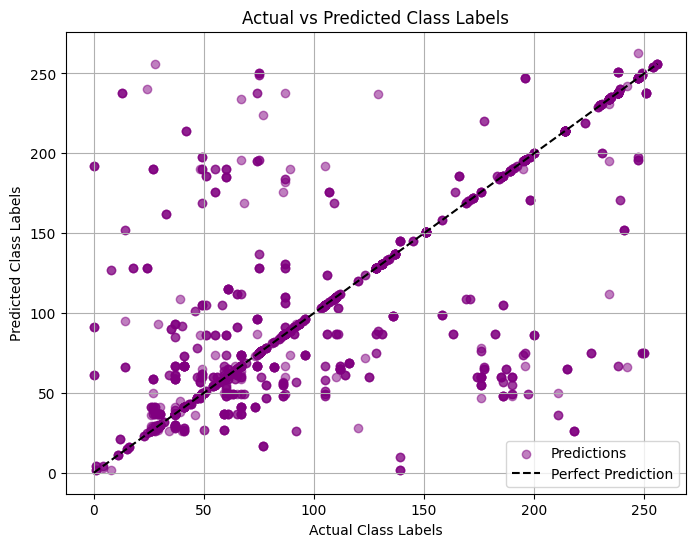

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(actual_labels, predicted_labels, alpha=0.5, color='purple', label='Predictions')
plt.plot([0, max(actual_labels)], [0, max(actual_labels)], 'k--', label='Perfect Prediction')
plt.xlabel("Actual Class Labels")
plt.ylabel("Predicted Class Labels")
plt.title("Actual vs Predicted Class Labels")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
correct = 0
total = len(actual_labels)

for true_label, pred_label in zip(actual_labels, predicted_labels):
    if true_label == pred_label:
        correct += 1

accuracy = correct / total * 100 if total > 0 else 0
print(f"Model Accuracy: {accuracy:.2f}%")


Model Accuracy: 57.27%


In [68]:
import torch
import cv2
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import re

CSV_FILE = "/home/aojwang/data/MergeDataset/csv_files/found_merged.csv"
MODEL_SAVE_PATH = "/home/aojwang/data/model/model/CarboAI/food_weight_model.pth"

# Load and clean CSV
df = pd.read_csv(CSV_FILE)
df.columns = df.columns.str.strip().str.replace("\n", " ").str.replace("  ", " ")
df["LABELS"] = df["LABELS"].astype(str).str.lower().str.strip()


# --- Define Weight Estimation Model ---
class WeightEstimationModel(nn.Module):
    """
    A regression model that uses pretrained MobileNetV3 features and additional
    geometric and intensity-based features to estimate food weight from images.
    Args:
        feature_dim (int): Number of additional handcrafted features to concatenate.
    """
    def __init__(self, feature_dim=3):
        super(WeightEstimationModel, self).__init__()
        self.mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.mobilenet.classifier = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(960 + feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

    def forward(self, image, additional_features):
        """
        Forward pass through the model.

        Args:
            image (torch.Tensor): Preprocessed image tensor [1, 3, 224, 224].
            additional_features (torch.Tensor): Handcrafted features tensor [1, feature_dim].

        Returns:
            torch.Tensor: Estimated food weight [1].
        """
        image_features = self.mobilenet(image)
        combined = torch.cat((image_features, additional_features), dim=1)
        return self.fc(combined)


#--- Load model to device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_model = WeightEstimationModel().to(device)


import re

def normalize_label(label):
    """Normalize labels by lowercasing, trimming, and collapsing whitespace."""
    if pd.isna(label):
        return ""
    return re.sub(r'\s+', ' ', label.strip().lower())

def get_food_carbs(image_path, detected_label):
    """
    Fetch carbohydrate content for a detected food label in a given image.
    Assumes structured CSV with only the first row of each image having `ospath`.
    """
    detected_label = normalize_label(detected_label)

    # Find the starting index of the image block
    start_idx = df[df["ospath"] == image_path].index
    if start_idx.empty:
        print(f"⚠️ No match for image path: {image_path}")
        return None
    start = start_idx[0]

    # Determine the block (rows until next image path or end of df)
    end = start + 1
    while end < len(df) and pd.isna(df.loc[end, "ospath"]):
        end += 1

    # Subset for that image block
    block = df.loc[start:end-1].copy()
    block["LABELS_normalized"] = block["LABELS"].apply(normalize_label)

    # Skip total row (where LABELS is empty or null)
    food_rows = block[block["LABELS_normalized"] != ""]

    # Match label exactly
    match_row = food_rows[food_rows["LABELS_normalized"] == detected_label]

    if not match_row.empty:
        carbs = match_row.iloc[0]["CARBOHYDRATE CONTENT"]
        try:
            return float(carbs)
        except (ValueError, TypeError):
            print(f"⚠️ Invalid carb value for '{detected_label}': {carbs}")
            return None

    # If no match
    print(f"❌ No match for '{detected_label}' in {image_path}")
    print("🔍 Available labels:", food_rows["LABELS_normalized"].tolist())
    return None



#--- Preprocess image for training/ prediction ---
def preprocess_image(image_path, use_ground_truth=True):
    """
    Detects food using Faster R-CNN, extracts bounding box features,
    crops detected food item, retrieves carbs from CSV.

    Args:
        image_path (str): Path to the input image.
        use_ground_truth (bool): Use for training (True) or inference (False).

    Returns:
        list: Tuples of (label, image_tensor, additional_features, weight or None).
    """
    print(f"\n📷 Processing: {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Cannot read {image_path}")
        return []

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w = image.shape[:2]
    image_area = img_h * img_w

    # --- Convert to tensor for Faster R-CNN
    transform_tensor = transforms.ToTensor()
    input_tensor = transform_tensor(image_rgb).to(device)

    with torch.no_grad():
        outputs = model([input_tensor])[0]

    # Filter out low-confidence detections
    detections = [
        (box.cpu().numpy(), label.item())
        for box, label, score in zip(outputs["boxes"], outputs["labels"], outputs["scores"])
        if score.item() >= 0.35
    ]

    if len(detections) == 0:
        print("⚠️ No food detected.")
        return []

    # --- Label map (COCO-style ID to name)
    class_id_to_name = {cat['id']: cat['name'] for cat in val_dataset.coco.dataset['categories']}

    food_data = []
    for box_np, class_id in detections:
        x1, y1, x2, y2 = map(int, box_np)
        label = class_id_to_name.get(class_id, f"class_{class_id}")
        print(f"🧭 Detected: {label}")

        cropped = image_rgb[y1:y2, x1:x2]
        if cropped.shape[0] == 0 or cropped.shape[1] == 0:
            print(f"⚠️ Invalid crop for {label}")
            continue

        h, w = cropped.shape[:2]
        area = h * w
        aspect_ratio = w / (h + 1e-5)
        intensity = np.mean(cropped)

        # Normalize handcrafted features
        norm_area = area / image_area
        norm_aspect_ratio = aspect_ratio
        norm_intensity = intensity / 255.0

        # CNN preprocessing
        transform_cnn = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        img_tensor = transform_cnn(cropped).unsqueeze(0).to(device)

        features = torch.tensor(
            [norm_area, norm_aspect_ratio, norm_intensity],
            dtype=torch.float32
        ).unsqueeze(0).to(device)

        weight = get_food_carbs(image_path, label) if use_ground_truth else None
        food_data.append((label, img_tensor, features, weight))

    return food_data

# --- Training Function ---
def train_model(epochs=10):
    """
    Trains the WeightEstimationModel using YOLO detections and CSV-labeled weights.

    Args:
        epochs (int): Number of training epochs.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(weight_model.parameters(), lr=0.001)
    dataset = df["ospath"].dropna().unique()

    epoch_losses = [] 

    for epoch in range(epochs):
        weight_model.train()
        total_loss = 0.0
        count = 0
        print(f"\n📚 Epoch {epoch+1}/{epochs}")

        for path in dataset:
            food_items = preprocess_image(path, use_ground_truth=True)
            for label, img, feat, true_weight in food_items:
                if true_weight is None:
                    continue

                y = torch.tensor([true_weight], dtype=torch.float32).to(device)
                img, feat = img.to(device), feat.to(device)

                optimizer.zero_grad()
                pred = weight_model(img, feat)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                count += 1

        avg_loss = total_loss / count if count else 0
        epoch_losses.append((epoch + 1, avg_loss))
        print(f"📘 Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

    # Final summary table
    print("\n📊 Epoch Loss Summary:")
    print("{:<10} {:<15}".format("Epoch", "Average Loss"))
    print("-" * 25)
    for ep, loss in epoch_losses:
        print("{:<10} {:<15.4f}".format(ep, loss))

    torch.save(weight_model.state_dict(), MODEL_SAVE_PATH)
    print("\n✅ Training complete. Model saved!")


# --- Prediction Function ---
def predict_food_carbs(image_path):
    """
    Loads the trained model and predicts carbohydrate weights for all food items in an image.
    Also retrieves the actual carbohydrate weight from the CSV for comparison.

    Args:
        image_path (str): Path to the input image.
    """
    # Load trained model weights
    weight_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    weight_model.eval()

    # Run inference pipeline (without retrieving weight for loss)
    food_items = preprocess_image(image_path, use_ground_truth=False)

    print(f"\n🔍 Predictions for {image_path}:\n")

    for label, img, feat, _ in food_items:
        # Predict weight
        with torch.no_grad():
            predicted_weight = weight_model(img, feat).item()

        # Get ground truth weight using fuzzy match
        actual_carbs = get_food_carbs(image_path, label)

        if actual_carbs is not None:
            print(f"🍽️ {label:<20} → Predicted: {predicted_weight:.2f}g carbs | Actual: {actual_carbs:.2f}g carbs")

        else:
            print(f"🍽️ {label:<20} → Predicted: {predicted_weight:.2f}g carbs | Actual: Not Found ❌")


In [69]:
train_model(epochs=2)


📚 Epoch 1/2

📷 Processing: /home/aojwang/data/MergeDataset/images/1ArrowrootEggBroccoli.jpg
🧭 Detected: Scrambled Eggs
🧭 Detected: Broccoli
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1ArrowrootEggBroccoli.jpg
🔍 Available labels: ['arrowroots', 'scrambled eggs', 'broccoli', 'nan']
🧭 Detected: Arrowroots
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1ArrowrootEggBroccoli.jpg
🔍 Available labels: ['arrowroots', 'scrambled eggs', 'broccoli', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadBaconSpinach.jpg
🧭 Detected: Bacon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
🧭 Detected: Brown Bread
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSausageSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage
🧭 Detected: Brown Bread
🧭 Detected: Sausage
🧭 Detected: Spinach Cooked
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1CassavaEggSukuma.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg
🧭 Detected: Boiled Egg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1CassavaEggSukuma.jpg
🔍 Available labels: ['cassava boiled', 'boiled egg', 'sukumawiki', 'nan']
🧭 Detected: Cassava Boiled
🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeEggCarrot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Egg Fry
🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizeEggCarrot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Carrot
🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaChickenBroccoli.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli
🧭 Detected: Chicken
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaChickenBroccoli.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/2PastaChickenBroccoli.jpg
🔍 Available labels: ['pasta', 'chicken', 'nan']
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/3PastaChickenBroccoli.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/3PastaChickenBroccoli.jpg
🔍 Available labels: ['pasta', 'broccoli', 'nan']
🧭 Detected: Pasta
🧭 Detected: Broccoli

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Pasta
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaChickenCarrot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/2PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Pasta
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaChickenZucchiniCarrot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenZucchiniCarrot.jpg
🔍 Available labels: ['pasta', 'zucchini', 'nan']
🧭 Detected: Pasta
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1PastaChickenZucchiniCarrot.jpg
🔍 Available labels: ['pasta', 'zucchini', 'nan']
🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.jpg
🔍 Available labels: ['mashed irish potatoes', 'fried pork', 'nan']
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.jpg
🔍 Available labels: ['mashed irish potatoes', 'fried pork', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.jpg
🔍 Available labels: ['mashed irish potatoes', 'fried pork', 'nan']

📷 Processing: 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBChickenCabbage.jpg
🧭 Detected: Chicken
🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/2RiceBChickenCabbage.jpg
🔍 Available labels: ['brown rice boiled', 'chicken', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/2RiceBChickenCabbage.jpg
🔍 Available labels: ['brown rice boiled', 'chicken', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Brown Rice Boiled
🧭 Detected: Chicken


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/3RiceBChickenCabbage.jpg
🔍 Available labels: ['brown rice boiled', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceBLiverVeg.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Liver Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Terere

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBLiverVeg.jpg
🧭 Detected: Brown Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Liver Fry
🧭 Detected: Terere
🧭 Detected: Saget
❌ No match for 'saget' in /home/aojwang/data/MergeDataset/images/3RiceBLiverVeg.jpg
🔍 Available labels: ['brown rice boiled', 'liver fry', 'terere', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBLiverVeg.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Terere
🧭 Detected: Liver Fry
❌ No match for 'liver fry' in /home/aojwang/data/MergeDataset/images/2RiceBLiverVeg.jpg
🔍 Available labels: ['brown rice boiled', 'liver', 'terere', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWMeatballsVegies.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Meatballs
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWMeatballsVegies.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Meatballs
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoSweetEggSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg
❌ No match for 'boiled egg' in /home/aojwang/data/MergeDataset/images/1PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'spinach cooked', 'nan']
🧭 Detected: Sweet Potato
🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoSweetEggSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg
❌ No match for 'boiled egg' in /home/aojwang/data/MergeDataset/images/2PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'spinach cooked', 'spinach', 'nan']
🧭 Detected: Sweet Potato
🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoSweetEggSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg
🧭 Detected: Sweet Potato
🧭 Detected: Sweet Potato
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'boiled egg', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'boiled egg', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1HamburgerSalad.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Hamburger
🧭 Detected: Onion Tomato Avocado
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/1HamburgerSalad.jpg
🔍 Available labels: ['hamburger', 'onion tomato avocado']

📷 Processing: /home/aojwang/data/MergeDataset/images/1HamburgerSalad2.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onion Tomato Carrot
🧭 Detected: Hamburger

📷 Processing: /home/aojwang/data/MergeDataset/images/1HotdogSalad.jpg
🧭 Detected: Hotdog
🧭 Detected: Onion Tomato Avocado
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/1HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'onion tomato avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2HotdogSalad.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Hotdog
🧭 Detected: Onion Tomato Avocado
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/2HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'onion tomato avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3HotdogSalad.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Hotdog
🧭 Detected: Onion Tomato Avocado
❌ No match for 'onion tomato avocado' in /home/aojwang/data/MergeDataset/images/3HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'nan']
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/3HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1SpaghettiMincedCarrot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/2SpaghettiMincedCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/2SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/3SpaghettiMincedCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/3SpaghettiMincedCarrot.jp

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/3SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliBChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliBChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/2UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/2UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliBChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/3UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWLambVeg.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Lamb Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWLambVeg.jpg
🔍 Available labels: ['white ugali', 'lamb stew', 'nan', 'lamb stew', 'nan', 'lamb stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWLambVeg.jpg
🔍 Available labels: ['white ugali', 'lamb stew', 'nan', 'lamb stew', 'nan', 'lamb stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWMatumboPumpkin.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Matumbo Fry
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWMatumboPumpkin.jpg
🔍 Available labels: ['white ugali', 'matumbo fry', 'pumpkin leaves', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWMatumboPumpkin.jpg
🧭 Detected: White Ugali
🧭 Detected: Matumbo Fry
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWMatumboPumpkin.jpg
🔍 Available labels: ['white ugali', 'matumbo fry', 'pumpkin leaves', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliBMatumboPumpkin.jpg
🧭 Detected: Spinach Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliBMatumboPumpkin.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Matumbo Fry
❌ No match for 'matumbo fry' in /home/aojwang/data/MergeDataset/images/3UgaliBMatumboPumpkin.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWChickenCabbage.jpg
🧭 Detected: White Ugali
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/2UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/3UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali'

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWEggSukuma.jpg
🧭 Detected: Egg Fry
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'egg fry', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWEggSukuma.jpg
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/2UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'sukumawiki', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'sukumawiki', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWEggSukuma.jpg
🧭 Detected: Egg Fry
🧭 Detected: White Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'egg fry', 'nan']
🧭 Detected: Egg Fry
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'egg fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWFishSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'spinach cooked', 'fish fry', 'nan']
🧭 Detected: Matumbo Fry
❌ No match for 'matumbo fry' in /home/aojwang/data/MergeDataset/images/1UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'spinach cooked', 'fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Fish Fry
❌ No match for 'fish fry' in /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWFishSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'fish fry', 'nan']
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWOmenaVegies.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Omena
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWOmenaVegies.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Omena
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWOmenaVegies.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Omena
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/2Arrowroots.jpg
🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/3Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/1BananaBoiled.jpg
🧭 Detected: Boiled Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2BananaBoiled.jpg
🧭 Detected: Boiled Banana
🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/3BananaBoiled.jpg
🧭 Detected: Boiled Banana
🧭 Detected: Boiled Banana
🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/1MatokeMashed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/2MatokeMashed.jpg
🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/3MatokeMashed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/3MatokeMashed.jpg
🔍 Available labels: ['boiled mashed banana']
🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/1Biscuit.jpg
🧭 Detected: Biscuit
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/1Biscuit.jpg
🔍 Available labels: ['biscuit']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Biscuit.jpg
🧭 Detected: Biscuit
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/2Biscuit.jpg
🔍 Available labels: ['biscuit']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Biscuit.jpg
🧭 Detected: Biscuit

📷 Processing: /home/aojwang/data/MergeDataset/images/1BBread.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Bread

📷 Processing: /home/aojwang/data/MergeDataset/images/2BBread.jpg
🧭 Detected: Brown Bread


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3BBread.jpg
🧭 Detected: Brown Bread
🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/3BBread.jpg
🔍 Available labels: ['brown bread']

📷 Processing: /home/aojwang/data/MergeDataset/images/1WBread.jpg
🧭 Detected: Brown Bread Margarine Spread
❌ No match for 'brown bread margarine spread' in /home/aojwang/data/MergeDataset/images/1WBread.jpg
🔍 Available labels: ['white bread']

📷 Processing: /home/aojwang/data/MergeDataset/images/2WBread.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Bread Margarine Spread
❌ No match for 'brown bread margarine spread' in /home/aojwang/data/MergeDataset/images/2WBread.jpg
🔍 Available labels: ['white bread']

📷 Processing: /home/aojwang/data/MergeDataset/images/3WBread.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WMBBread.jpg
🧭 Detected: Wholemeal Bread

📷 Processing: /home/aojwang/data/MergeDataset/images/2WMBBread.jpg
🧭 Detected: Wholemeal Bread


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3WMBBread.jpg
🧭 Detected: Wholemeal Bread
⚠️ Invalid carb value for 'wholemeal bread':  

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadAvocado.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WBreadButter.jpg
🧭 Detected: Brown Bread Margarine Spread
❌ No match for 'brown bread margarine spread' in /home/aojwang/data/MergeDataset/images/1WBreadButter.jpg
🔍 Available labels: ['white bread butter spread']

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadHoney.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1BreadSpreadHoney.jpg
🔍 Available labels: ['white bread honey spread']

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadJam.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadMarg.jpg
🧭 Detected: Brown Bread Margarine Spread
🧭 Detected: Brown Bread
❌ No mat

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cassava.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cassava.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cornflakes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cornflakes

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cornflakes.jpg
🧭 Detected: Cornflakes

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cornflakes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cornflakes

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cereal.jpg
🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/1Cereal.jpg
🔍 Available labels: ['cereal']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cereal.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/2Cereal.jpg
🔍 Available labels: ['cereal']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cereal.jpg
🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/3Cereal.jpg
🔍 Available labels: ['cereal']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiB.jpg
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChapatiB.jpg
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3ChapatiB.jpg
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiW.jpg
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChapatiW.jpg
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/3ChapatiW.jpg
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Pleas


📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoIrish.jpg
🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoIrish.jpg
🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoIrish.jpg
🧭 Detected: Irish Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoIrishMashed.jpg
🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoIrishMashed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoIrishMashed.jpg
🧭 Detected: Irish Potato Mashed


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeSweet.jpg
🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizeSweet.jpg
🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/3MaizeSweet.jpg
🧭 Detected: Boiled Yellow Maize


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SconesDrop.jpg
🧭 Detected: Scone

📷 Processing: /home/aojwang/data/MergeDataset/images/2SconesDrop.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scone
🧭 Detected: Scone

📷 Processing: /home/aojwang/data/MergeDataset/images/3SconesDrop.jpg
🧭 Detected: Scone


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Nan.jpg
🧭 Detected: Naan

📷 Processing: /home/aojwang/data/MergeDataset/images/2Nan.jpg
🧭 Detected: Naan

📷 Processing: /home/aojwang/data/MergeDataset/images/3Nan.jpg
🧭 Detected: Naan


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Noodles.jpg
🧭 Detected: Noodles
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1Noodles.jpg
🔍 Available labels: ['noodles']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Noodles.jpg
🧭 Detected: Noodles
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/2Noodles.jpg
🔍 Available labels: ['noodles']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Noodles.jpg
🧭 Detected: Noodles


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/3Noodles.jpg
🔍 Available labels: ['noodles']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pancake.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pancake
🧭 Detected: Pancake

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pancake.jpg
🧭 Detected: Pancake
🧭 Detected: Pancake
🧭 Detected: Hotdog
❌ No match for 'hotdog' in /home/aojwang/data/MergeDataset/images/2Pancake.jpg
🔍 Available labels: ['pancake']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pancake.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pancake

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pasta.jpg
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Pasta.jpg
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pasta.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizePorridge.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Oat Porridge
❌ No match for 'oat porridge' in /home/aojwang/data/MergeDataset/images/1MaizePorridge.jpg
🔍 Available labels: ['maize porridge']

📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizePorridge.jpg
🧭 Detected: Oat Porridge
❌ No match for 'oat porridge' in /home/aojwang/data/MergeDataset/images/2MaizePorridge.jpg
🔍 Available labels: ['maize porridge']

📷 Processing: /home/aojwang/data/MergeDataset/images/3MaizePorridge.jpg
🧭 Detected: Oat Porridge
❌ No match for 'oat porridge' in /home/aojwang/data/MergeDataset/images/3MaizePorridge.jpg
🔍 Available labels: ['maize porridge']

📷 Processing: /home/aojwang/data/MergeDataset/images/1WimbiPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/2WimbiPorridge.jpg
🧭 Detected: Sorghum Porridge


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3WimbiPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/1OatPorridge.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Oat Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/2OatPorridge.jpg
🧭 Detected: Oat Porridge


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3OatPorridge.jpg
🧭 Detected: Oat Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/1SorghumPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/2SorghumPorridge.jpg
🧭 Detected: Sorghum Porridge


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3SorghumPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoChips.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoChips.jpg
🧭 Detected: Potato Chips


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoChips.jpg
🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoCrisps.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoCrisps.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/2PotatoCrisps.jpg
🔍 Available labels: ['potato crisps']

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoCrisps.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BRiceBoiled.jpg
🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/2BRiceBoiled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3BRiceBoiled.jpg
🧭 Detected: Brown Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1WRiceBoiled.jpg
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/2WRiceBoiled.jpg
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3WRiceBoiled.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Spaghetti.jpg
🧭 Detected: Spaghetti
🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/1Spaghetti.jpg
🔍 Available labels: ['spaghetti']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Spaghetti.jpg
🧭 Detected: Spaghetti
🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/2Spaghetti.jpg
🔍 Available labels: ['spaghetti']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Spaghetti.jpg
🧭 Detected: Spaghetti
🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/3Spaghetti.jpg
🔍 Available labels: ['spaghetti']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoSweet.jpg
🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoSweet.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoSweet.jpg
🧭 Detected: Sweet Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1WUgali.jpg
🧭 Detected: White Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/2WUgali.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: White Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/3WUgali.jpg
🧭 Detected: White Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BUgali.jpg
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/2BUgali.jpg
🧭 Detected: Brown Ugali
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/3Yam.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[ WARN:0@29080.577] global loadsave.cpp:268 findDecoder imread_(' CONTENT (g)"'): can't open/read file: check file path/integrity
[ WARN:0@29080.577] global loadsave.cpp:268 findDecoder imread_('CONTENT  (kcal)"'): can't open/read file: check file path/integrity


🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/3Yam.jpg
🔍 Available labels: ['yam']

📷 Processing:  CONTENT (g)"
❌ Error: Cannot read  CONTENT (g)"

📷 Processing: CONTENT  (kcal)"
❌ Error: Cannot read CONTENT  (kcal)"

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🧭 Detected: Boiled Peas
❌ No match for 'boiled peas' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🧭 Detected: Brown 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🔍 Available labels: ['maize', 'nan']
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🔍 Available labels: ['maize', 'nan']
🧭 Detected: Maize
🧭 Detected: Boiled Yellow Maize
❌ No match for 'boiled yellow maize' in /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🔍 Available labels: ['maize', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaBroccoli.jpg
🧭 Detected: Broccoli
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaBroccoli.jpg
🧭 Detected: Broccoli
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/3PastaBroccoli.jpg
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaCarrot.jpg
🧭 Detected: Carrot
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1PastaCarrot.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaCarrot.jpg
🧭 Detected: Carrot
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/2PastaCarrot.jpg
🔍 Available labels: ['carrot', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🧭 Detected: Carrot
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🔍 Available labels: ['carrot', 'nan']
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🔍 Available labels: ['carrot', 'nan']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaSukumaMushrooms.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']
🧭 Detected: Pasta
🧭 Detected: Cooked Mushroom
❌ No match for 'cooked mushroom' in /home/aojwang/data/MergeDataset/images/1PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', '

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']
🧭 Detected: Pasta
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']
🧭 Detected: Cooked Mushroom
❌ No match for 'cooked mushroom' in /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoAvocadoLettuce.jpg
🧭 Detected: Lettuce
🧭 Detected: Avocado


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceBBroccoliCarrot.jpg
🧭 Detected: Brown Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBBroccoliCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Brown Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/2RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Brown Rice Boiled
🧭 Detected: Broccoli


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWBroccoliCarrot.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/1RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWBroccoliCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/2RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWBroccoliCarrot.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/3RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/3RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWFrenchB.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: French beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWFrenchB.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/2RiceWFrenchB.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWFrenchB.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/3RiceWFrenchB.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceDenguTerere.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/1RiceDenguTerere.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1RiceDenguTerere.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1SamosaVege.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Samosa
❌ No match for 'samosa' in /home/aojwang/data/MergeDataset/images/1SamosaVege.jpg
🔍 Available labels: ['nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2SamosaVege.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Bacon.jpg
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/2Bacon.jpg
🧭 Detected: Bacon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Bacon.jpg
🧭 Detected: Bacon
🧭 Detected: Bacon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BeefFry.jpg
🧭 Detected: Beef Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/2BeefFry.jpg
🧭 Detected: Beef Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3BeefFry.jpg
🧭 Detected: Beef Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BeefRoast.jpg
🧭 Detected: Beef Roast
🧭 Detected: Bacon
❌ No match for 'bacon' in /home/aojwang/data/MergeDataset/images/1BeefRoast.jpg
🔍 Available labels: ['beef roast']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2BeefRoast.jpg
🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/3BeefRoast.jpg
🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1Ham.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ham

📷 Processing: /home/aojwang/data/MergeDataset/images/2Ham.jpg
🧭 Detected: Ham

📷 Processing: /home/aojwang/data/MergeDataset/images/3Ham.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ham

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChickenDrumsticks.jpg
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2ChickenDrumsticks.jpg
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3ChickenDrumsticks.jpg
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1ChickenMakhni.jpg
🧭 Detected: Chicken Makhni

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChickenMakhni.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Makhni

📷 Processing: /home/aojwang/data/MergeDataset/images/3ChickenMakhni.jpg
🧭 Detected: Chicken Makhni


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1ChickenRoast.jpg
🧭 Detected: Chicken

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChickenRoast.jpg
🧭 Detected: Chicken

📷 Processing: /home/aojwang/data/MergeDataset/images/3ChickenRoast.jpg
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/3ChickenRoast.jpg
🔍 Available labels: ['chicken']
🧭 Detected: Beef Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'beef fry' in /home/aojwang/data/MergeDataset/images/3ChickenRoast.jpg
🔍 Available labels: ['chicken']

📷 Processing: /home/aojwang/data/MergeDataset/images/1EggBoiled.jpg
🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/2EggBoiled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/3EggBoiled.jpg
🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1EggFried.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1EggOmelettePlain.jpg
🧭 Detected: Omelette


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1EggScrambled.jpg
🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1Fish.jpg
🧭 Detected: Fish Fry
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/2Fish.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3Fish.jpg
🧭 Detected: Fish Fry
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1FishFillet.jpg
🧭 Detected: Fish Fillet


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2FishFillet.jpg
🧭 Detected: Fish Fillet

📷 Processing: /home/aojwang/data/MergeDataset/images/3FishFillet.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Fish Fillet

📷 Processing: /home/aojwang/data/MergeDataset/images/1LambStew.jpg
🧭 Detected: Lamb Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2LambStew.jpg
🧭 Detected: Lamb Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/3LambStew.jpg
🧭 Detected: Lamb Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1Liver.jpg
🧭 Detected: Liver Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Liver.jpg
🧭 Detected: Liver Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3Liver.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Liver Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1MatumboFried.jpg
🧭 Detected: Matumbo Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2MatumboFried.jpg
🧭 Detected: Matumbo Fry
🧭 Detected: Omena
❌ No match for 'omena' in /home/aojwang/data/MergeDataset/images/2MatumboFried.jpg
🔍 Available labels: ['matumbo fry']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3MatumboFried.jpg
🧭 Detected: Matumbo Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1Meatballs.jpg
🧭 Detected: Meatballs

📷 Processing: /home/aojwang/data/MergeDataset/images/2Meatballs.jpg
🧭 Detected: Meatballs


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Meatballs.jpg
🧭 Detected: Meatballs

📷 Processing: /home/aojwang/data/MergeDataset/images/1MeatMinced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/2MeatMinced.jpg
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3MeatMinced.jpg
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Omena.jpg
🧭 Detected: Omena

📷 Processing: /home/aojwang/data/MergeDataset/images/2Omena.jpg
🧭 Detected: Omena

📷 Processing: /home/aojwang/data/MergeDataset/images/3Omena.jpg
🧭 Detected: Omena


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PorkFried.jpg
🧭 Detected: Pork Fry
🧭 Detected: Lamb Stew
❌ No match for 'lamb stew' in /home/aojwang/data/MergeDataset/images/1PorkFried.jpg
🔍 Available labels: ['pork fry']

📷 Processing: /home/aojwang/data/MergeDataset/images/2PorkFried.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pork Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3PorkFried.jpg
🧭 Detected: Pork Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Sausage.jpg
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/2Sausage.jpg
🧭 Detected: Sausage
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sausage.jpg
🧭 Detected: Sausage


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SausageBacon.jpg
🧭 Detected: Sausage
❌ No match for 'sausage' in /home/aojwang/data/MergeDataset/images/1SausageBacon.jpg
🔍 Available labels: ['bacon', 'nan']
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/2SausageBacon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage
❌ No match for 'sausage' in /home/aojwang/data/MergeDataset/images/2SausageBacon.jpg
🔍 Available labels: ['bacon', 'nan']
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/3SausageBacon.jpg
🧭 Detected: Sausage
❌ No match for 'sausage' in /home/aojwang/data/MergeDataset/images/3SausageBacon.jpg
🔍 Available labels: ['bacon', 'nan']
🧭 Detected: Bacon
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/1Asparagus.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/1Asparagus.jpg
🔍 Available labels: ['asparagus']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Asparagus.jpg
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/2Asparagus.jpg
🔍 Available labels: ['asparagus']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Asparagus.jpg
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/3Asparagus.jpg
🔍 Available labels: ['asparagus']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Beetroot.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1Beetroot.jpg
🔍 Available labels: ['beetroot']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Beetroot.jpg
🧭 Detected: Beetroot

📷 Processing: /home/aojwang/data/MergeDataset/images/3Beetroot.jpg
🧭 Detected: Passion
❌ No match for 'passion' in /home/aojwang/data/

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut

📷 Processing: /home/aojwang/data/MergeDataset/images/2Butternut.jpg
🧭 Detected: Butternut


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Butternut.jpg
🧭 Detected: Butternut

📷 Processing: /home/aojwang/data/MergeDataset/images/1Broccoli.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli

📷 Processing: /home/aojwang/data/MergeDataset/images/2Broccoli.jpg
🧭 Detected: Broccoli


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Broccoli.jpg
🧭 Detected: Broccoli

📷 Processing: /home/aojwang/data/MergeDataset/images/1CabbageRed.jpg
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/1CabbageRed.jpg
🔍 Available labels: ['red cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/2CabbageRed.jpg
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/2CabbageRed.jpg
🔍 Available labels: ['red cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/3CabbageRed.jpg
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/3CabbageRed.jpg
🔍 Available labels: ['red cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1CabbageGreen.jpg
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/2CabbageGreen.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/3CabbageGreen.jpg
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Cabbagesprout.jpg
🧭 Detected: Cabbage Sprout

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cabbagesprout.jpg
🧭 Detected: Cabbage Sprout

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cabbagesprout.jpg
🧭 Detected: Cabbage Sprout


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1RedGreenYellowCapsicum.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2RedGreenYellowCapsicum.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Carrot.jpg
🧭 Detected: Carrot
🧭 Detected: Butternut
❌ No match for 'butternut' in /home/aojwang/data/MergeDataset/images/1Carrot.jpg
🔍 Available labels: ['carrot']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Carrot.jpg
🧭 Detected: Carrot
🧭 Detected: Carrot
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/3Carrot.jpg
🧭 Detected: Carrot
🧭 Detected: Carrot
🧭 Detected: Carrot
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Cauliflower.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1Cauliflower.jpg
🔍 Available labels: ['cauliflower']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cauliflower.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/2Cauliflower.jpg
🔍 Available labels: ['cauliflower']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cauliflower.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/3Cauliflower.jpg
🔍 Available labels: ['cauliflower']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cucumber.jpg
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/2Cucumber.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Green Bell Pepper
❌ No match for 'green bell pepper' in /home/aojwang/data/MergeDataset/images/2Cucumber.jpg
🔍 Available labels: ['cucumber']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cucumber.jpg
🧭 Detected: Cucumber


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Eggplant.jpg
🧭 Detected: Eggplant

📷 Processing: /home/aojwang/data/MergeDataset/images/2Eggplant.jpg
🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant

📷 Processing: /home/aojwang/data/MergeDataset/images/3Eggplant.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Kitojo.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1Kitojo.jpg
🔍 Available labels: ['kitojo']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Kitojo.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kitojo.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Kunde.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1Kunde.jpg
🔍 Available labels: ['kunde']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Kunde.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kunde.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Lettuce.jpg
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/2Lettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/3Managu.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/3Managu.jpg
🔍 Available labels: ['lettuce']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Murenda.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/1Murenda.jpg
🔍 Available labels: ['murenda']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Mushrooms.jpg
🧭 Detected: Mushroom

📷 Processing: /home/aojwang/data/MergeDataset/images/3MushroomsCooked.jpg
🧭 Detected: Cooked Mushroom


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'cooked mushroom' in /home/aojwang/data/MergeDataset/images/3MushroomsCooked.jpg
🔍 Available labels: ['mushroom']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Nderema.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/1Nderema.jpg
🔍 Available labels: ['nderema']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Paneel.jpg
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Paneel.jpg
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Eggplant
❌ No match for 'eggplant' in /home/aojwang/data/MergeDataset/images/3Paneel.jpg
🔍 Available labels: ['paneel']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PeasBoiled.jpg
🧭 Detected: Boiled Peas

📷 Processing: /home/aojwang/data/MergeDataset/images/2PeasBoiled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Peas

📷 Processing: /home/aojwang/data/MergeDataset/images/3PeasBoiled.jpg
🧭 Detected: Boiled Peas


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PlumTomato.jpg
🧭 Detected: Plum Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/2PlumTomato.jpg
🧭 Detected: Plum Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/3PlumTomato.jpg
🧭 Detected: Plum Tomato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PumpkinLeaves.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1PumpkinLeaves.jpg
🔍 Available labels: ['pumpkin leaves']

📷 Processing: /home/aojwang/data/MergeDataset/images/2PumpkinLeaves.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2PumpkinLeaves.jpg
🔍 Available labels: ['pumpkin leaves']

📷 Processing: /home/aojwang/data/MergeDataset/images/3PumpkinLeaves.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3PumpkinLeaves.jpg
🔍 Available labels: ['pumpkin leaves']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pumpkin.jpg
🧭 Detected: Pumpkin

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pumpkin.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pumpkin

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pumpkin.jpg
🧭 Detected: Pumpkin
🧭 Detected: Pumpkin

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sageti.jpg
🧭 Detected: Saget


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Sageti.jpg
🧭 Detected: Saget

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sageti.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SpinachCooked.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2SpinachCooked.jpg
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2SpinachCooked.jpg
🔍 Available labels: ['spinach cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/3SpinachCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sukumawiki.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/2Sukumawiki.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sukumawiki.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Terere.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/1Terere.jpg
🔍 Available labels: ['terere']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Terere.jpg
🧭 Detected: Terere
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/2Terere.jpg
🔍 Available labels: ['terere']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Terere.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/3Terere.jpg
🔍 Available labels: ['terere']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Thabai.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1Thabai.jpg
🔍 Available labels: ['thabai']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Thabai.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2Thabai.jpg
🔍 Available labels: ['thabai']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Thabai.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Tomato.jpg
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/2Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Tangerine
❌ No match for 'tangerine' in /home/aojwang/data/MergeDataset/images/2Tomato.jpg
🔍 Available labels: ['tomato']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Tomato.jpg
🧭 Detected: Tomato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Zucchini.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/1Zucchini.jpg
🔍 Available labels: ['zucchini']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Zucchini.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/2Zucchini.jpg
🔍 Available labels: ['zucchini']
🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/3Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/3Zucchini.jpg
🔍 Available labels: ['zucchini']
🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/1AvocadoCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1OnionTomatoAvocado.jpg
🧭 Detected: Onion Tomato Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/1CarrotCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/1CarrotCabbage.jpg
🔍 Available labels: ['carrot', 'green cabbage', 'carrot green cabbage']

📷 Processing: /home/aojwang/data/MergeDataset/images/1OnionTomatoCarrot.jpg
🧭 Detected: Onion Tomato Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1CabbagesproutTomato.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1LettuceRedpepper.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BeerWCap.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1TeaBlack.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1TeaWhite.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cola2.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1ColaSugarless.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Fanta.jpg
🧭 Detected: Fanta

📷 Processing: /home/aojwang/data/MergeDataset/images/1EnergyDrinkRB.jpg
🧭 Detected: Carbonated Coke
❌ No match for 'carbonated coke' in /home/aojwang/data/MergeDataset/images/1EnergyDrinkRB.jpg
🔍 Available labels: ['energy drink']

📷 Processing: /home/aojwang/data/MergeDa

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Milk.jpg
🧭 Detected: Milk

📷 Processing: /home/aojwang/data/MergeDataset/images/1MilkFermented.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WaterTonic.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WaterFlvrd.jpg
🧭 Detected: Bitter Lemon
❌ No match for 'bitter lemon' in /home/aojwang/data/MergeDataset/images/1WaterFlvrd.jpg
🔍 Available labels: ['flavored water']
🧭 Detected: Milk
❌ No match for 'milk' in /home/aojwang/data/MergeDataset/images/1WaterFlvrd.jpg
🔍 Available labels: ['flavored water']

📷 Processing: /home/aojwang/data/MergeDataset/images/1WineRed.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WineWhite.jpg
🧭 Detected: Boiled Egg
❌ No match for 'boiled egg' in /home/aojwang/data/MergeDataset/images/1WineWhite.jpg
🔍 Available labels: ['white wine']

📷 Processing: /home/aojwang/data/MergeDataset/images/1MilkYoghurtNatural.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1MilkYoghurtStrawb.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Almond

📷 Processing: /home/aojwang/data/MergeDataset/images/3Almond.jpg
🧭 Detected: Almond


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Avocado.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/1Avocado.jpg
🔍 Available labels: ['avocado']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Avocado.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Avocado.jpg
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/3Avocado.jpg
🔍 Available labels: ['avocado']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Butter.jpg
🧭 Detected: Butter

📷 Processing: /home/aojwang/data/MergeDataset/images/2Butter.jpg
🧭 Detected: Butter

📷 Processing: /home/aojwang/data/MergeDataset/images/3Butter.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butter

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cashewnut.jpg
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1Cashewnut.jpg
🔍 Available labels: ['cashewnut']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cashewnut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cashewnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Chia.jpg
🧭 Detected: Chia Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/2Chia.jpg
🧭 Detected: Chia Seeds


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Chia.jpg
🧭 Detected: Chia Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/1Coconut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Coconut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Ghee.jpg
🧭 Detected: Ghee
🧭 Detected: Olive Oil
❌ No match for 'olive oil' in /home/aojwang/data/MergeDataset/images/1Ghee.jpg
🔍 Available labels: ['ghee']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Flax.jpg
🧭 Detected: Flax


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Flax.jpg
🧭 Detected: Flax

📷 Processing: /home/aojwang/data/MergeDataset/images/3Flax.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Flax

📷 Processing: /home/aojwang/data/MergeDataset/images/1Hazelnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Hazelnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Hazelnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Macadamia.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Macadamia.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Macadamia.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Mozzarella.jpg
🧭 Detected: Mozzarella

📷 Processing: /home/aojwang/data/MergeDataset/images/2Mozzarella.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mozzarella

📷 Processing: /home/aojwang/data/MergeDataset/images/3Mozzarella.jpg
🧭 Detected: Mozzarella

📷 Processing: /home/aojwang/data/MergeDataset/images/1OliveOil.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Olive Oil

📷 Processing: /home/aojwang/data/MergeDataset/images/2OliveOil.jpg
🧭 Detected: Olive Oil
🧭 Detected: Ghee
❌ No match for 'ghee' in /home/aojwang/data/MergeDataset/images/2OliveOil.jpg
🔍 Available labels: ['olive oil']

📷 Processing: /home/aojwang/data/MergeDataset/images/3OliveOil.jpg
🧭 Detected: Olive Oil
🧭 Detected: Ghee
❌ No match for 'ghee' in /home/aojwang/data/MergeDataset/images/3OliveOil.jpg
🔍 Available labels: ['olive oil']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Peanut.jpg
🧭 Detected: Peanut

📷 Processing: /home/aojwang/data/MergeDataset/images/2Peanut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Peanut

📷 Processing: /home/aojwang/data/MergeDataset/images/3Peanut.jpg
🧭 Detected: Peanut


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Poppy.jpg
🧭 Detected: Poppy Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/2Poppy.jpg
🧭 Detected: Poppy Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/3Poppy.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1PumpkinSeed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2PumpkinSeed.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3PumpkinSeed.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sesame.jpg
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1Sesame.jpg
🔍 Available labels: ['sesame seeds']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1Sesame.jpg
🔍 Available labels: ['sesame seeds']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Sesame.jpg
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/2Sesame.jpg
🔍 Available labels: ['sesame seeds']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sesame.jpg
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/3Sesame.jpg
🔍 Available labels: ['sesa

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3BlackBeans.jpg
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1ButternutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/2ButternutBeans.jpg
🧭 Detected: Butternut Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Chickpeas.jpg
🧭 Detected: Soya Beans
❌ No match for 'soya beans' in /home/aojwang/data/MergeDataset/images/1Chickpeas.jpg
🔍 Available labels: ['chick peas']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Chickpeas.jpg
🧭 Detected: Soya Beans
❌ No match for 'soya beans' in /home/aojwang/data/MergeDataset/images/2Chickpeas.jpg
🔍 Available labels: ['chick peas']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Chickpeas.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Dalmakhni.jpg
🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/2Dalmakhni.jpg
🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/3Dalmakhni.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/1Kamande.jpg
🧭 Detected: Kamande


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Kamande.jpg
🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kamande.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/1Mbaazi.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/2Mbaazi.jpg
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/2Mbaazi.jpg
🔍 Available labels: ['mbaazi']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/2Mbaazi.jpg
🔍 Available labels: ['mbaazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Mbaazi.jpg
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/3Mbaazi.jpg
🔍 Available labels: ['mbaazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Ndengu.jpg
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/2Ndengu.jpg
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Ndengu.jpg
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Rosecoco.jpg
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/2Rosecoco.jpg
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/3Rosecoco.jpg
🧭 Detected: Rosecoco


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SoyaBeans.jpg
🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/2SoyaBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/3SoyaBeans.jpg
🧭 Detected: Soya Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Tadhikadal.jpg
🧭 Detected: Tadhikaldal

📷 Processing: /home/aojwang/data/MergeDataset/images/2Tadhikadal.jpg
🧭 Detected: Tadhikaldal

📷 Processing: /home/aojwang/data/MergeDataset/images/3YellowBeans.jpg
🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/3YellowBeans.jpg
🔍 Available labels: ['tadhikaldal']

📷 Processing: /home/aojwang/data/MergeDataset/images/1DalmakhnilcuminRice.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Dalmakhi
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2DalmakhnilcuminRice.jpg
🧭 Detected: Dalmakhi
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3DalmakhnilcuminRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/1DalmakhiNan.jpg
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Fish Fillet
❌ No match for 'fish fillet' in /home/aojwang/data/MergeDataset/images/1DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Naan

📷 Processing: /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Fish Fillet


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'fish fillet' in /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Naan
🧭 Detected: Fish Fillet
❌ No match for 'fish fillet' in /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3DalmakhiNan.jpg
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/3DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Naan


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceLentil.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
❌ No match for 'kamande' in /home/aojwang/data/MergeDataset/images/1RiceLentil.jpg
🔍 Available labels: ['white rice boiled', 'lentils (kamande)', 'rice & kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceLentil.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceLentil.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/3RiceLentil.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceNdengu.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1RiceNdengu.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceNdengu.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceNdengu.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/3RiceNdengu.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeBeans.jpg
🧭 Detected: Githeri


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1MaizeBeans.jpg
🔍 Available labels: ['githeri']

📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizeBeans.jpg
🧭 Detected: Githeri


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3MaizeBeans.jpg
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceBean.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBean.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/2RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/2RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBean.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/3RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/3RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceSoyaBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Soya Beans
🧭 Detected: Tadhikaldal
❌ No match for 'tadhikaldal' in /home/aojwang/data/MergeDataset/images/1RiceSoyaBeans.jpg
🔍 Available labels: ['white rice boiled', 'soya beans', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1RiceSoyaBeans.jpg
🔍 Available labels: ['white rice boiled', 'soya beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceSoyaBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceSoyaBeans.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1TadhikadalNan.jpg
🧭 Detected: Tadhikaldal
🧭 Detected: Naan


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2TadhikadalNan.jpg
🧭 Detected: Tadhikaldal
🧭 Detected: Naan
❌ No match for 'naan' in /home/aojwang/data/MergeDataset/images/2TadhikadalNan.jpg
🔍 Available labels: ['white rice boiled', 'tadhikaldal', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3TadhikadalNan.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tadhikaldal
❌ No match for 'tadhikaldal' in /home/aojwang/data/MergeDataset/images/3TadhikadalNan.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Naan
❌ No match for 'naan' in /home/aojwang/data/MergeDataset/images/3TadhikadalNan.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ButternutSpinach.jpg
🧭 Detected: Butternut Spinach


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2ButternutSpinach.jpg
🧭 Detected: Butternut Spinach

📷 Processing: /home/aojwang/data/MergeDataset/images/3ButternutSpinach.jpg
🧭 Detected: Butternut Spinach

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceNjahiSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Spinach Cooked
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceNjahiSpinach.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWButternutSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceWButternutSpinach.jpg
🔍 Available labels: ['white rice boiled', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWButternutSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceWButternutSpinach.jpg
🔍 Available labels: ['white rice boiled', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWButternutSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3RiceWButternutSpinach.jpg
🔍 Available labels: ['white rice boiled', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Saget
❌ No match for 'saget' in /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWLentilKitojo.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Saget
❌ No match for 'saget' in /home/aojwang/data/MergeDataset/images/3RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/3RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceDenguSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceDenguSpinach.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan', 'ndengu', 'terere', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWYellowBTerere.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/3RiceWYellowBTerere.jpg
🔍 Available labels: ['white rice boiled', 'yellow beans', 'nan']
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/3RiceWYellowBTerere.jpg
🔍 Available labels: ['white rice boiled', 'yellow beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliDenguCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: White Ugali
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1UgaliDenguCabbage.jpg
🔍 Available labels: ['white ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2GitheriVegies.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2GitheriVegies.jpg
🔍 Available labels: ['githeri', 'sukumawiki', 'nan']
🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/3GitheriVegies.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3GitheriVegies.jpg
🔍 Available labels: ['githeri', 'sukumawiki', 'nan']
🧭 Detected: Githeri


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Pleas


📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWBeanTerere.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Terere
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWBeanTerere.jpg
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/2RiceWBeanTerere.jpg
🔍 Available labels: ['rosecoco', 'terere', 'nan']
🧭 Detected: Terere
🧭 Detected: Rosecoco


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWBeanTerere.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
🧭 Detected: Terere


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[ WARN:0@29134.063] global loadsave.cpp:268 findDecoder imread_('ospath'): can't open/read file: check file path/integrity



📷 Processing: ospath
❌ Error: Cannot read ospath

📷 Processing: /home/aojwang/data/MergeDataset/images/1Honey.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cake.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SugarBrown.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SugarWhite.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sweetener.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SyrupRed.jpg
🧭 Detected: Red Syrup

📷 Processing: /home/aojwang/data/MergeDataset/images/1Apple.jpg
🧭 Detected: Lemon
❌ No match for 'lemon' in /home/aojwang/data/MergeDataset/images/1Apple.jpg
🔍 Available labels: ['apple']
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/2Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/3Apple.jpg
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/1Blueberry.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Blueberry

📷 Processing: /home/aojwang/data/MergeDataset/images/2Blueberry.jpg
🧭 Detected: Blueberry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Blueberry.jpg
🧭 Detected: Blueberry

📷 Processing: /home/aojwang/data/MergeDataset/images/1Banana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/2Banana.jpg
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Banana.jpg
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/1CustardApple.jpg
🧭 Detected: Custard Apple
🧭 Detected: Custard Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/2CustardApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Custard Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/3CustardApple.jpg
🧭 Detected: Custard Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Dates.jpg
🧭 Detected: Dates

📷 Processing: /home/aojwang/data/MergeDataset/images/2Dates.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Dates.jpg
🧭 Detected: Fried Egg Plant
❌ No match for 'fried egg plant' in /home/aojwang/data/MergeDataset/images/3Dates.jpg
🔍 Available labels: ['dates']

📷 Processing: /home/aojwang/data/MergeDataset/images/1GreenGrape.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2GreenGrape.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/2GreenGrape.jpg
🔍 Available labels: ['green grapes']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RedGrape.jpg
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/1Guava.jpg
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/1Guava.jpg
🔍 Available labels: ['guava']
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1Guava.jpg
🔍 Available labels: ['guava']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Guava.jpg
🧭 Detected: Lemon
❌ No match for 'lemon' in /home/aojwang/data/MergeDataset/images/2Guava.jpg
🔍 Available labels: ['guava']
🧭 Detected: Guava

📷 Processing: /home/aojwang/data/MergeDataset/images/3Guava.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Guava

📷 Processing: /home/aojwang/data/MergeDataset/images/1Kiwi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Kiwi.jpg
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/2Kiwi.jpg
🔍 Available labels: ['kiwi']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kiwi.jpg
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/3Kiwi.jpg
🔍 Available labels: ['kiwi']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Lemon.jpg
🧭 Detected: Lemon

📷 Processing: /home/aojwang/data/MergeDataset/images/2Lemon.jpg
🧭 Detected: Lemon

📷 Processing: /home/aojwang/data/MergeDataset/images/3Lemon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lemon

📷 Processing: /home/aojwang/data/MergeDataset/images/1Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Mango.jpg
🧭 Detected: Lemon
❌ No match for 'lemon' in /home/aojwang/data/MergeDataset/images/2Mango.jpg
🔍 Available labels: ['mango']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Mango.jpg
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/1Orange.jpg
🧭 Detected: Orange


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1OrangeC.jpg
🧭 Detected: Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/1Orange2.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/1Passion.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Passion.jpg
🧭 Detected: Passion

📷 Processing: /home/aojwang/data/MergeDataset/images/3Passion.jpg
🧭 Detected: Passion


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Pawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Butternut Boiled
❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/1Pawpaw.jpg
🔍 Available labels: ['pawpaw']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Pawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Butternut Boiled
❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/2Pawpaw.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Butternut Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/3Pawpaw.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pear.jpg
🧭 Detected: Pear

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pear.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/2Pear.jpg
🔍 Available labels: ['pear']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pear.jpg
🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/3Pear.jpg
🔍 Available labels: ['pear']
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/3Pear.jpg
🔍 Available labels: ['pear']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pineapple.jpg
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pineapple.jpg
🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Plum.jpg
🧭 Detected: Plum

📷 Processing: /home/aojwang/data/MergeDataset/images/2Plum.jpg
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/2Plum.jpg
🔍 Available labels: ['plum']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Plum.jpg
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/3Plum.jpg
🔍 Available labels: ['plum']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Raspberry.jpg
🧭 Detected: Raspberry

📷 Processing: /home/aojwang/data/MergeDataset/images/2Raspberry.jpg
🧭 Detected: Raspberry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Raspberry.jpg
🧭 Detected: Raspberry

📷 Processing: /home/aojwang/data/MergeDataset/images/1Strawberry.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Strawberry
🧭 Detected: Raspberry
❌ No match for 'raspberry' in /home/aojwang/data/MergeDataset/images/1Strawberry.jpg
🔍 Available labels: ['strawberry']
🧭 Detected: Plum Tomato
❌ No match for 'plum tomato' in /home/aojwang/data/MergeDataset/images/1Strawberry.jpg
🔍 Available labels: ['strawberry']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Strawberry.jpg
🧭 Detected: Strawberry
🧭 Detected: Raspberry
❌ No match for 'raspberry' in /home/aojwang/data/MergeDataset/images/2Strawberry.jpg
🔍 Available labels: ['strawberry']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Strawberry.jpg
🧭 Detected: Raspberry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'raspberry' in /home/aojwang/data/MergeDataset/images/3Strawberry.jpg
🔍 Available labels: ['strawberry']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Tangerine.jpg
🧭 Detected: Orange
❌ No match for 'orange' in /home/aojwang/data/MergeDataset/images/1Tangerine.jpg
🔍 Available labels: ['tangerine']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Tangerine.jpg
🧭 Detected: Tangerine
🧭 Detected: Hamburger
❌ No match for 'hamburger' in /home/aojwang/data/MergeDataset/images/2Tangerine.jpg
🔍 Available labels: ['tangerine']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Tangerine.jpg
🧭 Detected: Orange
❌ No match for 'orange' in /home/aojwang/data/MergeDataset/images/3Tangerine.jpg
🔍 Available labels: ['tangerine']
🧭 Detected: Tangerine


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled
❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/3Tangerine.jpg
🔍 Available labels: ['tangerine']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ThornMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2ThornMelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3ThornMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1TreeTomato.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1TreeTomato.jpg
🔍 Available labels: ['tree tomato']

📷 Processing: /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🔍 Available labels: ['tree tomato']
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🔍 Available labels: ['tree tomato']
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🔍 Available labels: ['tree tomato']

📷 Processing: /home/aojwang/data/MergeDataset/images/3TreeTomato.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/3TreeTomato.jpg
🔍 Available labels: ['tre

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/3WMelon.jpg
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1AvocadoPawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Strawberry Pear Orange
❌ No match for 'strawberry pear orange' in /home/aojwang/data/MergeDataset/images/1AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'pawpaw', 'avocado pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/2AvocadoPawpaw.jpg
🧭 Detected: Avocado Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/3AvocadoPawpaw.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BananaWMelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Banana Watermelon Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/2BananaWMelonPawpaw.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3BananaWMelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1MangoGrapeApple.jpg
🧭 Detected: Mango Grape Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/2MangoGrapeApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango Grape Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/3MangoGrapeApple.jpg
🧭 Detected: Mango Grape Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1StrawberryBananaWMelon.jpg
🧭 Detected: Strawberry Banana Watermelon

📷 Processing: /home/aojwang/data/MergeDataset/images/2StrawberryBananaWMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3StrawberryBananaWMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1StrawberryPearOrange.jpg
🧭 Detected: Strawberry Pear Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/2StrawberryPearOrange.jpg
🧭 Detected: Strawberry Pear Orange


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3StrawberryPearOrange.jpg
🧭 Detected: Strawberry Pear Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/1WMelonMangoKiwi.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Watermelon Mango Kiwi

📷 Processing: /home/aojwang/data/MergeDataset/images/2WMelonMangoKiwi.jpg
🧭 Detected: Watermelon Mango Kiwi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3WMelonMangoKiwi.jpg
🧭 Detected: Watermelon Mango Kiwi

📷 Processing: /home/aojwang/data/MergeDataset/images/1Watermelon.jpg
🧭 Detected: Water Melon
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/2Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Water Melon
🧭 Detected: Water Melon
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Watermelon.jpg
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/4Watermelon.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/4Watermelon.jpg
🔍 Available labels: ['water melon']

📷 Processing: /home/aojwang/data/MergeDataset/images/5Watermelon.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/6Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/7Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/8Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/9Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/10Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/11Watermelon.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/12Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/13Watermelon.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/14Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/15Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/16Pawpaw.jpg
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/17Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/18Pawpaw.jpg
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/19Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/20Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/21Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/22Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/23Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/24Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/25Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/26Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/27Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/28Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/29Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/30Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/31Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/32Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/33Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/34Pineapple.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/35Pineapple.jpg
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/36Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/37Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/38Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/39Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/40Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/41Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/42Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/43Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/44Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/45Apple.jpg
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/46Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/47Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/48Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/49Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/50Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/51Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/52Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/53Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/54Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/55Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/56Mango.jpg
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/57Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/58Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/59Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/60Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/61Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/62Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/63Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/64Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/65Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/66Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/67Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/68Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/69Bananapeeled.jpg
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/70Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/71Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/72Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/73Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/74Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/75Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/76Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/77Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/78Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/79Bananapeeled.jpg
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/80Bananapeeled.jpg
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/81Grapes.jpg
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/82Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/82Grapes.jpg
🔍 Available labels: ['red grapes']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/83Grapes.jpg
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/84Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/85Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/86Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/87Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/88Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/89Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/90Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/91Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/92Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/93Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/94Watermelonsliced.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/95Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/96Grapes.jpg
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/96Grapes.jpg
🔍 Available labels: ['grapes']

📷 Processing: /home/aojwang/data/MergeDataset/images/97Watermelonsliced.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/98Watermelonsliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/99Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Water Melon
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/100BananaPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/100BananaPawpaw.jpg
🔍 Available labels: ['ripe banana']
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg
🔍 Available labels: ['pawpaw']
🧭 Detected: Pawpaw
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg
🔍 Available labels: ['pawpaw']
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/102PawpawBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/102PawpawBanana.jpg
🔍 Available labels: ['pawpaw']
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/103PawpawBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/103PawpawBanana.jpg
🔍 Available labels: ['pawpaw']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/104PineappleBanana.jpg
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/104PineappleBanana.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/105PineapplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/105PineapplePawpaw.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/106PineapplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/106PineapplePawpaw.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/107PineappleBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/107PineappleBanana.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple
🧭 Detected: Pineapple
🧭 Detected: Pineapple
🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/108PawpawPineapple.jpg
🧭 Detected: Pawpaw
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/108PawpawPineapple.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/109BananaPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/109BananaPineapple.jpg
🔍 Available labels: ['ripe banana']
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/109BananaPineapple.jpg
🔍 Available labels: ['ripe banana']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/110PawpawPineapple.jpg
🧭 Detected: Pawpaw
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/110PawpawPineapple.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/111BananaPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Ripe Banana
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/111BananaPawpaw.jpg
🔍 Available labels: ['ripe banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/113Pawpaw1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/114Pawpawhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/115Pawpawquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/116Pineapple1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/117Pineapplehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/118Pineapplequotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/119Watermelon1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/120Watermelonhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/121Watermelonquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/122Mango1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/123Mangohalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/124Mangoquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/125Grapes1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/126Grapeshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/127Grapesquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/128Apple1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/129Applehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/130Applecquoterup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/131Banana1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/133Bananaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/134ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/135ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/136ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/137ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/138ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/139AppleMango.jpg
🧭 Detected: Mango
🧭 Detected: Apple
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/140AppleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/141AppleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/142AppleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Apple
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/143AppleMango.jpg
🧭 Detected: Mango
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/144ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple
🧭 Detected: Pineapple
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/145ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Apple
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/146ApplePineapple.jpg
🧭 Detected: Pineapple
🧭 Detected: Apple
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/147ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Apple
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/148ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple
🧭 Detected: Pineapple
🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/149PineappleAppleBanana.jpg
🧭 Detected: Ripe Banana
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/149PineappleAppleBanana.jpg
🔍 Available labels: ['pineapple', 'apple', 'ripe banana', 'nan']
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/150ApplePineappleBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/150ApplePineappleBanana.jpg
🔍 Available labels: ['apple', 'ripe banana', 'nan', 'apple', 'ripe banana', 'nan']
🧭 Detected: Ripe Banana
🧭 Detected: Apple
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/150ApplePineappleBanana.jpg
🔍 Available labels: ['apple', 'ripe banana', 'nan', 'apple', 'ripe banana', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/152ApplePineappleBanana.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/152ApplePineappleBanana.jpg
🔍 Available labels: ['apple', 'ripe banana', 'nan', 'apple', 'nan']
🧭 Detected: Ripe Banana
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/154BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/155BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/155BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']
🧭 Detected: Ripe Banana
🧭 Detected: Ripe Banana
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/156BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/156BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/156BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/157BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/157BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/158BananaMango.jpg
🧭 Detected: Mango
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/159MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/160MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/160MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/161MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/161MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/161MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/162MangoPawpaw.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/162MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/162MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/163MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/163MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/163MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/164PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/164PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/165PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/165PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/166PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/166PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/166PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/167PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/168PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/168PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/169WatermelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/169WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/169WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/171WatermelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/171WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/171WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/172WatermelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/172WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/173WatermelonPawpaw.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/173WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/173WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/174WatermelonBanana.jpg
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/174WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/174WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/175WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/175WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/176WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/176WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/176WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/177WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/177WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/178WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/179MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/180MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/181MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/182MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/183MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/184Avocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/185Avocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/186Avocadowithoutseed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/187Avocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/188Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/189Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/190Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/191Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/192Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/193AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/193AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/194AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/194AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/195AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/195AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/196AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/196AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/197AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/197AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/198PineappleAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/199AvocadoPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/199AvocadoPineapple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/200AvocadoPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/200AvocadoPineapple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/201AvocadoPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/201AvocadoPineapple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/202PineappleAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/203AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/203AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/203AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/204AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/204AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/205AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/205AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/206AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/206AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/207AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/207AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/208AvocadoApple.jpg
🧭 Detected: Avocado
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/208AvocadoApple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/209AvocadoApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/209AvocadoApple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/210AvocadoApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/210AvocadoApple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/211AvocadoApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/212AvocadoApple.jpg
🧭 Detected: Avocado
🧭 Detected: Apple
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/214MangoAvocado.jpg
🧭 Detected: Avocado
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/215MangoAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/216MangoAvocado.jpg
🧭 Detected: Avocado
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/217MangoAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/217MangoAvocado.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/218Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/218Cucumber.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/219Cucumber.jpg
🧭 Detected: Cucumber
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/219Cucumber.jpg
🔍 Available labels: ['cucumber']

📷 Processing: /home/aojwang/data/MergeDataset/images/220Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/221Cucumberquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/222Cucumberhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/224Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/225Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/226Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/227Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/228Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/229Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/230Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/231Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/232Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/233Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/234Zucchiniquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/235Zucchinihalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/236Zucchini1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/237Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/238Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/239Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/240Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/241Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/242Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/243Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/244Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/245Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/247Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/248Tomatohalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/249Tomato1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/250Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/251Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/252Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/253Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/254Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/255Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/256Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/257Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/258Carrotsquotercupcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/259Carrotshalfcupcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/260Carrots1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/261Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/262Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/263Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/264Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/265Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/266Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/267Carrotsgratedquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/268Carrotsgratedhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/269Carrotsgrated1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/270Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/271Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/272Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/273Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/274Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/275Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/276Cabbagehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/277Cabbage1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/278Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/279Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/280Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/281Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/282Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/283Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/284Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/285Lettucehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/286Lettuce1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/287Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/288Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/289Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/290Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/291Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/292Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/293Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/294TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/295TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/296TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/297TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/298TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/299CarrotsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/300CarrotsCucumber.jpg
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/300CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/301CarrotsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/301CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/301CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/302CarrotsCucumber.jpg
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/302CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/303CarrotsCucumber.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/304LettuceCucumber.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/304LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/305LettuceCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/305LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/306LettuceCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/306LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/306LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/307LettuceCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/307LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/308LettuceCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/308LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/309CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/309CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/310CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/310CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/311CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/311CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/312CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/312CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/313CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/313CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/314CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/315CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/316CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/317CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/318CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/320TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/322TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/323TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/324TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/325TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/326TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/327TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/328TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/329TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/330OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/330OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/331OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/331OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/332OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/332OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/333OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/333OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/334OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/334OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/335CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/336CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/337CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/338CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/339CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/339CabbageOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/340LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/340LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/341LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/341LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/342LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/342LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/343LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/343LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/344LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/344LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/345OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/346OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/347OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/348OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/349OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/350TomatoCucumberCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/350TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/350TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/351TomatoCucumberCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/351TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/351TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/352TomatoCucumberCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/352TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/352TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/353LettuceTomatoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/353LettuceTomatoCarrots.jpg
🔍 Available labels: ['lettuce', 'tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/354LettuceTomatoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/354LettuceTomatoCarrots.jpg
🔍 Available labels: ['lettuce', 'tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/355LettuceTomatoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/355LettuceTomatoCarrots.jpg
🔍 Available labels: ['lettuce', 'tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/356TomatoOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/356TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/356TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/357TomatoOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/357TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/357TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/358TomatoOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/358TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/358TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Zucchini
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Zucchini
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Zucchini
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/362LettuceOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/362LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/362LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/363LettuceOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/363LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/363LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/364LettuceOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/364LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/364LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/365CabbageCarrotsgratedOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/365CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/365CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/366CabbageCarrotsgratedOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/366CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/366CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/367CabbageCarrotsgratedOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/367CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/367CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/368LettuceCarrotsGrapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/368LettuceCarrotsGrapes.jpg
🔍 Available labels: ['lettuce', 'red grapes', 'nan']
🧭 Detected: Lettuce
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/369LettuceCarrotsGrapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/369LettuceCarrotsGrapes.jpg
🔍 Available labels: ['lettuce', 'red grapes', 'nan']
🧭 Detected: Red Grapes
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/370LettuceCarrotsGrapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/370LettuceCarrotsGrapes.jpg
🔍 Available labels: ['lettuce', 'red grapes', 'nan']
🧭 Detected: Red Grapes
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/371CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/371CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/372CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/372CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/373CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/373CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/375CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/375CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/376CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/376CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/377CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/377CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/378CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/378CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/380CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/380CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/381LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/381LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/382LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/382LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/383LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/383LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/384LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/384LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/385LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/385LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/386CabbageCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/387CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/388CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/389CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/390CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/391BananaCabbage.jpg
🧭 Detected: Ripe Banana
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/392BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/393BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/394BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/395BananaCabbage.jpg
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/396BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/397BananaCabbage.jpg
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/398BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/399BananaCabbage.jpg
🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/400BananaCabbage.jpg
🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/401BananaCabbage.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/401BananaCabbage.jpg
🔍 Available labels: ['ripe banana', 'green cabbage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/402BananaCarrots.jpg
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/403BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/404BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/405BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/406BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/407BananaCarrots.jpg
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/408BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/409BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/410BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/411BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/412BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/413BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/414BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/414BananaCucumber.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/415BananaCucumber.jpg
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/416BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/417BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/418BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/419BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/420BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/420BananaTomato.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/421BananaTomato.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/421BananaTomato.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/422MangoLettuce.jpg
🧭 Detected: Mango
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/423MangoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/423MangoLettuce.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/424MangoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/425MangoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/425MangoLettuce.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/426MangoLettuce.jpg
🧭 Detected: Mango
🧭 Detected: Lettuce


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/427MangoLettuce.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/427MangoLettuce.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/429MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/430MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/430MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/431MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/431MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/432MangoCarrots.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/432MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/433MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/433MangoCarrots.jpg
🔍 Available labels: ['mango']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/434MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/434MangoCarrots.jpg
🔍 Available labels: ['mango']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/435MangoCarrots.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/435MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/436MangoTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/436MangoTomato.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/437MangoTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/437MangoTomato.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/448MangoTomato.jpg
🧭 Detected: Mango
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/448MangoTomato.jpg
🔍 Available labels: ['mango', 'nan', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/450MangoTomato.jpg
🧭 Detected: Tomato
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/451MangoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/452MangoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/452MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/453MangoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/453MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/454MangoCucumber.jpg
🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/454MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/455MangoCucumber.jpg
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/455MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/458MangoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/458MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/459GrapesLettuce.jpg
🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/459GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/460GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/460GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/461GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/461GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/462GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/462GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/463GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/463GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/464GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/464GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/465GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/465GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/466GrapesLettuce.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/466GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/467GrapesShreddedCarrots.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/467GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/468GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/468GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/469GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/469GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/470GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/470GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/471GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/471GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/472GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/472GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/473GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/473GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/474GGrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/474GGrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/475GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/475GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/476GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/476GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/477GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/477GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/478GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/478GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/479GrapesCucumber.jpg
🧭 Detected: Red Grapes
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/480GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/480GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/481GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/481GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/482GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/482GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/483GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/483GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/484RedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/485RedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/486RedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/487PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/488PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
🧭 Detected: Red Cabbage


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/490PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
🧭 Detected: Red Cabbage


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/491PineappleRedCabbage.jpg
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/492PineappleRedCabbageShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/492PineappleRedCabbageShreddedCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/492PineappleRedCabbageShreddedCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/493PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/493PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/493PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/495PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/495PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/496PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/496PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/497PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/497PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/498PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/498PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/499PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/499PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/500PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/500PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/501PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/501PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/502PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/502PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/502PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/503PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/503PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/503PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/504PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/504PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/504PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/505PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/505PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/505PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/506CarrotsPineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/506CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['carrot', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/506CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/507CarrotsPineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/507CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/507CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/508RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/509RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/510RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/511RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/512RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/513RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/514RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/515RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/516RoscocoBeans.jpg
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/517RoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/518RoscocoBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/519RoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/520Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/521Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/523Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/524Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/525Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/526Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/527Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/528Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/529Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/531Greengrams1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/532Greengramshalfcup.jpg
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/533Greengramsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/534Greengramsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/535Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/536Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/537Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/538Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/538Lentils.jpg
🔍 Available labels: ['kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/539Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/540Lentils.jpg
🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/541Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/542Lentilsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/543Lentilsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/543Lentilsthirdcup.jpg
🔍 Available labels: ['kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/544Lentilshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/544Lentilshalfcup.jpg
🔍 Available labels: ['kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/545Lentils1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/546Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/547Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/548Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/549Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/551Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/552Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/553Pigeonpea.jpg
🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/554Pigeonpea.jpg
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/555Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/556Pigeonpea.jpg
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/557Pigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/558Pigeonpeathirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/559Pigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/560Pigeonpea1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/562WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/563WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/564WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/565WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/566WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/567WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/568WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/569WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/570WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/571WhiteRicequotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/572WhiteRicethirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/573WhiteRicehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/574WhiteRice1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/575MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/575MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/576MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/576MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/577MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/577MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/578MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/578MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/579MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/579

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/591ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/592ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/593ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/594ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/595ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/596ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/597ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/598ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/599ButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/600ButterBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/601ButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/602ButterBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/603GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/604GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/604GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/605GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/605GreenBeans.jpg
🔍 Available labels: ['green beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/606GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/606GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/607GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/607GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/608GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/608GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/609GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/609GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/610GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/610GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/611GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/611GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/612GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/612GreenBeans.jpg
🔍 Available labels: ['green beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/613GreenBeansquotercup.jpg
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/614GreenBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/614GreenBeansthirdcup.jpg
🔍 Available labels: ['green beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/615GreenBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/615GreenBeanshalfcup.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/617EggyolkBeans.jpg
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/618EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/619EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/619EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/620EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/620EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/621EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/621EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/622EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/622EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/623EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/623EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/624EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/625EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/625EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/626EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/627EggyolkBeansquotrcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/628EggyolkBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/628EggyolkBeansthirdcup.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/629EggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/631BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/632BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/633BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/634BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/635BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/636BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/637BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/638BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/639BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/640BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/641BrownRicequotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/642BrownRicethirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/643BrownRicehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/644BrownRice1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/645Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/646Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/647Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/648Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/649Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/650Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/651Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/657SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/658SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/659SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/660SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/661SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/662SweetPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/663SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/664SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/665SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/666SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/667BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/668BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/669BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/670BrownChapati.jpg
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/671BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/672BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/673BrownChapati.jpg
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/674BrownChapati.jpg
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/675BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/676WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/676WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/677WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/677WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/678WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/678WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/679WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/679WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/680WhiteChapati.jpg
🧭 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/685Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/686Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/687Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/688Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/689Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/690Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/691Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/692Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/693WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/693WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'mbaazi', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/694WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/695WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/695WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/695WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/696WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/696WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/697WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/697WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/698WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/700WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/700WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/701WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/703WhiteRicequotercupPigeonpeapeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/703WhiteRicequotercupPigeonpeapeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'mbaazi', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/704WhiteRicequotercupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/705WhiteRicethirdcupPigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/705WhiteRicethirdcupPigeonpeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/706WhiteRicethirdcupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/706WhiteRicethirdcupPigeonpeahalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/707WhiteRicehalfcupPigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/707WhiteRicehalfcupPigeonpeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/708WhiteRiceuphalfcupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/708WhiteRiceuphalfcupPigeonpeahalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/709WhiteRice1cupPigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/709WhiteRice1cupPigeonpeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/710WhiteRice1cupPigeonpeathirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/711WhiteRice1cupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/711WhiteRice1cupPigeonpeahalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/712WhiteRice1cupPigeonpea1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/712WhiteRice1cupPigeonpea1cup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/713WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/714WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/714WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/715WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/716WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/716WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/717WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/717WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/718WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/719WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/719WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/720WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/720WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/721WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/721WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/722WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/723WhiteRicequotercupRoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/723WhiteRicequotercupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/724WhiteRicequotercupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/725WhiteRicethirdcupRoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/725WhiteRicethirdcupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/725WhiteRicethirdcupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/726WhiteRicethirdcupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/726WhiteRicethirdcupRoscocoBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/727WhiteRicehalfcupRoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/727WhiteRicehalfcupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/728WhiteRicehalfcupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/728WhiteRicehalfcupRoscocoBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/729WhiteRice1cupRoscocoBeansquoterup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/729WhiteRice1cupRoscocoBeansquoterup.jpg
🔍 Available labels: ['white rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/730WhiteRice1cupRoscocoBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/731WhiteRice1cupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/731WhiteRice1cupRoscocoBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/732WhiteRice1cupRoscocoBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/733WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/734WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/735WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/736WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/736WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/737WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/737WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/738WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/738WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/739WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/739WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/740WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/741WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/743WhiteRicequotercupButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/743WhiteRicequotercupButterBeansquotercup.jpg
🔍 Available labels: ['white rice boiled']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/744WhiteRicequotercupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/745WhiteRicethirdcupButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/745WhiteRicethirdcupButterBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/746WhiteRicethirdcupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/746WhiteRicethirdcupButterBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/747WhiteRicehalfcupButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/748WhiteRicehalfcupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/748WhiteRicehalfcupButterBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/750WhiteRice1cupButterBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/751WhiteRice1cupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/751WhiteRice1cupButterBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/752WhiteRice1cupButterBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/753BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/754BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/754BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/755BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/756BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/756BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/757BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/757BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/758BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/759BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
⚠️ Invalid carb value for 'brown rice boiled':  
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/759BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/760BrownRiceCowpeas.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/760BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/761BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/761BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/762BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/763BrownRicequotercupCowpeasquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/764BrownRicequotercupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/765BrownRicethirdcupCowpeasquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/765BrownRicethirdcupCowpeasquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/766BrownRicethirdcupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/766BrownRicethirdcupCowpeashalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/767BrownRicehalfcupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/767BrownRicehalfcupCowpeashalfcup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/768BrownRicehalfcupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/768BrownRicehalfcupCowpeashalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/769BrownRice1cupCowpeasquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/769BrownRice1cupCowpeasquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/770BrownRice1CupCowpeasthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/771BrownRice1cupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/772BrownRice1cupCowpeas1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/774BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/774BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/775BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/776BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/776BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/777BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/777BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/778BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/779BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/779BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/780BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/780BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/781BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/781BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/782BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/783BrownRicequotercupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/783BrownRicequotercupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/784BrownRicequotercupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/785BrownRicethirdcupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/785BrownRicethirdcupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'monkeynut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/786BrownRicethirdcupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/786BrownRicethirdcupMonkeynutshalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/787BrownRicehalfcupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/787BrownRicehalfcupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/788BrownRicehalfcupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/788BrownRicehalfcupMonkeynutshalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/789BrownRice1cupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/789BrownRice1cupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/790BrownRice1cupMonkeynutsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/791BrownRice1cupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/792BrownRice1cupMonkeynuts1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/793BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/794BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/794BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/796BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/796BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']
🧭 Detected: Eggyolk Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/797BrownRiceEggyolkBeans.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/797BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/798BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/798BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/799BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/800BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/800BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/801BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/801BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/802BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/802BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/802BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/803BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/803BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/804BrownRicequotercupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/805BrownRicequotercupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/806BrownRicethirdcupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/806BrownRicethirdcupEggyolkBeansquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/807BrownRicethirdcupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/807BrownRicethirdcupEggyolkBeanshalfcup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/808BrownRicehalfcupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/808BrownRicehalfcupEggyolkBeansquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/809BrownRicehalfcupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/809BrownRicehalfcupEggyolkBeanshalfcup.jpg
🔍 Available labels: ['brown rice boiled']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/809BrownRicehalfcupEggyolkBeanshalfcup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/810BrownRice1cupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/810BrownRice1cupEggyolkBeansquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/811BrownRice1cupEggyolkBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/812BrownRice1cupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/813BrownRice1cupEggyolkBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/813BrownRice1cupEggyolkBeans1cup.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/813BrownRice1cupEggyolkBeans1cup.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/814WhiteChapatihalfEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/815WhiteChapatiquoterEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/817WhiteChapati1EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/818WhiteChapati2EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/818WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/819WhiteChapati3EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/819WhiteChapati3EggyolkBeans.jpg
🔍 Available labels: ['white chapati']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/820WhiteChapati3EggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/821WhiteChapati2EggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/821WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/822WhiteChapati1EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/822WhiteChapati1EggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/823WhiteChapati1EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/824WhiteChapati2EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/824WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['whitechapati2']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/824WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['whitechapati2']

📷 Processing: /home/aojwang/data/MergeDataset/images/825WhiteChapati3EggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/825WhiteChapati3EggyolkBeans.jpg
🔍 Available labels: ['white chapati']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/826WhiteChapatihalfEggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/826WhiteChapatihalfEggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/827WhiteChapatiquoterEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/827WhiteChapatiquoterEggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/828WhiteChapatiquoterEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/829WhiteChapatihalfEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/829WhiteChapatihalfEggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/830WhiteChapatiquoterButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/831WhiteChapatihalfButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/833WhiteChapatihalfButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/833WhiteChapatihalfButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/835WhiteChapati2ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/835WhiteChapati2ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/835WhiteChapati3ButterBeans.jpg
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/834WhiteChapati1ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/834WhiteChapati1ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/837WhiteChapati1ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/837WhiteChapati1ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/836WhiteChapati2ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/836WhiteChapati2ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/839WhiteChapati2ButterBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Butternut Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/840WhiteChapati3ButterBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/840WhiteChapati3ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/841WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/842WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/843WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/844WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/845WhiteChapatihalfMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/845WhiteChapatihalfMonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/846WhiteChapatihalfMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/846WhiteChapatihalfMonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/847WhiteChapatihalfMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/850WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/850WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/851WhiteChapati3MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/851WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/852WhiteChapati1MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/852WhiteChapati1MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/853WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/853WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/854WhiteChapati3MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/854WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/855WhiteChapati1MonkeynutBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/855WhiteChapati1MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/856WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/856WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/857WhiteChapati3MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/857WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/858WhiteChapati1MonkeynutBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/858WhiteChapati1MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/859WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/859WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/860WhiteChapati3MonkeynutBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/860WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/861WhiteChapatiquoterGreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/862WhiteChapatihalfGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/863WhiteChapati1GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/863WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/864WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/864WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/865WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/865WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/866WhiteChapatiquoterGreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/867WhiteChapatihalfGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/867WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/868WhiteChapati1GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/868WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/869WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/869WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/870WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/870WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/871WhiteChapatiquoterGreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/872WhiteChapatihalfGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/872WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/872WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/873WhiteChapati1GreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/873WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/874WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/874WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/875WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/875WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/876WhiteChapatiquoterGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/876WhiteChapatiquoterGreenBeans.jpg
🔍 Available labels: ['white chapati', 'green beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/877WhiteChapatihalfGreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/877WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/877WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/878WhiteChapati1GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/878WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/879WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/879WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/879WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/880WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/880WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/880WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/881WhiteChapatiquoterGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/882WhiteChapatihalfGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/883WhiteChapatihalfGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/884WhiteChapatiquoterGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/884WhiteChapatiquoterGreengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/885WhiteChapatiquoterGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/886WhiteChapatihalfGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/886WhiteChapatihalfGreengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/887WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/887WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/888WhiteChapati2Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/888WhiteChapati2Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/889WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/889WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/890WhiteChapati3Greengrams.jpg
🧭 Detected: Ndengu
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/891WhiteChapati2Greengrams.jpg
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/891WhiteChapati2Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/892WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/892WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/893WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/893WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/894WhiteChapati2Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/894WhiteChapati2Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/895WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/895WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/896WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/896WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/897WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/897WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/898WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/898WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/899IrishPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/900IrishPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato
🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/901IrishPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/901IrishPotato.jpg
🔍 Available labels: ['irish potato']
🧭 Detected: Irish Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/902IrishPotato.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/902IrishPotato.jpg
🔍 Available labels: ['irish potato']
🧭 Detected: Irish Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/903IrishPotato.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/903IrishPotato.jpg
🔍 Available labels: ['irish potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/904SweetPotatoroundcut.jpg
🧭 Detected: Sweet Potato
🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/904SweetPotatoroundcut.jpg
🔍 Available labels: ['sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/906SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/907SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/909SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/910SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/912SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/913SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/914SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/915Mandazi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/916Mandazi.jpg
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/916Mandazi.jpg
🔍 Available labels: ['mandazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/917Mandazi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/918Mandazi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/921Mandazi.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/921Mandazi.jpg
🔍 Available labels: ['mandazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/922Mandazi.jpg
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/922Mandazi.jpg
🔍 Available labels: ['mandazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/924Mandazi.jpg
🧭 Detected: Chicken Drumst

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/930Plantain.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/931Plantain.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/932Plantain.jpg
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/933Plantain.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/935Frenchfries.jpg
🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/937Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/938Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/939Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/940Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/941Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/942Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/943BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/944BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/945BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/946BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/947BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/948BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/949BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/950BananaCookedthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/951BananaCookedhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/951BananaCookedhalfcup.jpg
🔍 Available labels: ['boiled banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/952BananaCooked1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/953MashedSweetpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/953MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/954MashedSweetpotato.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/954MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/955MashedSweetpotato.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/955MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/957MashedSweetpotato.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/957MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/958MashedSweetpotato.jpg
🧭 Detected: 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/961MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/962MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/962MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/963MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/963MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/964MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/964MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/966MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Irish Potato Mashed


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/967MashedIrishpotato.jpg
🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/968MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/968MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/969MashedIrishpotatoquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/970MashedIrishpotatothirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/971MashedIrishpotatohalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/972MashedIrishpotato1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/973MashedSweetpotatoquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/973MashedSweetpotatoquotercup.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/974MashedSweetpotatothirdcup.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/974MashedSweetpotatothirdcup.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/975MashedSweetpotatohalfcup.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/975MashedSweetpotatohalfcup.jpg
🔍 Available labels: ['mashed sweet potato']
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/975MashedSweetpotatohalfcup.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/976MashedSweetpotato1cup.jpg
🧭 Detected: Mashed Potato
❌

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/979MashedArrowRoot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/980MashedArrowRoot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/981MashedArrowRoot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/982MashedBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/983MashedBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/984MashedBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/986MashedBananaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/986MashedBananaquotercup.jpg
🔍 Available labels: ['boiled mashed banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/987MashedBananathirdcup.jpg
🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/988MashedBananahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/990MashedBanana1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/990MashedBanana1cup.jpg
🔍 Available labels: ['boiled mashed banana']
🧭 Detected: Boiled Mashed Banana
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/990MashedBanana1cup.jpg
🔍 Available labels: ['boiled mashed banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/991Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/992Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/993Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/994Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/995Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/996Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/997Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/998Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/999Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1000Spinachquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1000Spinachquotercup.jpg
🔍 Available labels: ['spinach cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1001Spinachhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1002Spinach1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1003Spinachthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1004Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1004Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1005Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1006Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1007Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1007Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1008Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1009Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1009Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1010Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1010Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1011Kalesquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1012Kalesthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1014Kales1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1015Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1016Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1017Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1018Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1019Cabbage1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1019Cabbage1cup.jpg
🔍 Available labels: ['green cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1020Cabbagehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1020Cabbagehalfcup.jpg
🔍 Available labels: ['green cabbage cooked']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1021Cabbagequotercup.jpg
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1022Cabbagethirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1023Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1024Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1025Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1026Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1067Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1068Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1069Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1070Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1071Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1072Beefstewquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1073Beefstewthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1074Beefstewhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1075Beefstewonecup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1076BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1077BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1078BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1079BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1080BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1081Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1081Chickendrumstick.jpg
🔍 Available labels: ['chicken drumstick']

📷 Processing: /home/aojwang/data/MergeDataset/images/1082Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1083Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1084Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1085Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1086Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1087Chickendrumstick.jpg
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1089Mincedbeef.jpg
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1090Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1091Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1092Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1093Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1094Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1095Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1096Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1097Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1098Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1099Mincedbeefquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1100Mincedbeefthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1101Mincedbeefhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1102Mincedbeefonecup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1103ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1104ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1105ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1106ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1107ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1108ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1109ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1110ScrambledEggs.jpg
🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1111ScrambledEggsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1112ScrambledEggsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1113ScrambledEggshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1114ScrambledEggsonecup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1115Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing

📷 Processing: /home/aojwang/data/MergeDataset/images/1116Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1116Chickenwings.jpg
🔍 Available labels: ['chicken wing']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1117Chickenwings.jpg
🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1117Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1118Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing

📷 Processing: /home/aojwang/data/MergeDataset/images/1119Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1119Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1120Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing

📷 Processing: /home/aojwang/data/MergeDataset/images/1121Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1121Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1122Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1122Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1123Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1123Grilledchickenbreast.jpg
🔍 Available labels: ['chicken breast grilled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1124Grilledchickenbreast.jpg
🧭 Detected: Chicken Breast Grilled
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1124Grilledchickenbreast.jpg
🔍 Available labels: ['chicken breast grilled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1125Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled

📷 Processing: /home/aojwang/data/MergeDataset/images/1126Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled

📷 Processing: /home/aojwang/data/MergeDataset/images/1127Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1127Grilledchickenbreast.jpg
🔍 Available labels: ['chicken breast grilled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1128Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled

📷 Processing: /home/aojwang/data/MergeDataset/images/1129Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1136FriedEggs.jpg
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1137FriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1138FriedEggs.jpg
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1139FriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1140FriedEggs.jpg
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1141FriedEggs.jpg
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1141BoiledButternut.jpg
🧭 Detected: Butternut Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1142BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1143BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/1143BoiledButternut.jpg
🔍 Available labels: ['butternut boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1144BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/1144BoiledButternut.jpg
🔍 Available labels: ['butternut boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1145BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1146BoiledButternut.jpg
🧭 Detected: Butternut Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1147BoiledButternut.jpg
🧭 Detected: Butternut Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1148Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1149Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1150Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1151Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1152Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1153Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1155BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1156BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1157BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1159BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1160ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1161ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1162ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1163ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1164ChickendrumstickWhiterice.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1165ChickendrumstickWhiterice.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1166ChickendrumstickPlantains.jpg
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1166ChickendrumstickPlantains.jpg
🔍 Available labels: ['chicken drumstick', 'plantain', 'nan']
🧭 Detected: Plantain


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1167PlantainsChickendrumstick.jpg
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1168PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1170PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1170PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1170PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1171PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1172PlantainsChickendrumstick.jpg
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1172PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1174BrownChapatiChickendrumstick.jpg
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1175BrownChapatiChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1176BrownChapatiChickendrumstick.jpg
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1176BrownChapatiChickendrumstick.jpg
🔍 Available labels: ['brown chapati', 'nan', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1178BrownChapatiChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1179BrownChapatiChickendrumstick.jpg
🧭 Detected: Chicken Drumstick
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1185FriedEggsBrownChapati.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/1086BrownChapatiFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1087BrownChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1088FriedEggsBrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1089BrownChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1090FriedEggsBrownChapati.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1091WhiteChapatiFriedEggs.jpg
🧭 Detected: White Chapati
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1092WhiteChapatiFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: White Chapati
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1093WhiteChapatiFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1093WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1093WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1094WhiteChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1095WhiteChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1095WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1095WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1096WhiteChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1098PlantainsFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1099PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1099PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1100PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1112PlantainsFriedEggs.jpg
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1112PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1113PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1114PlantainsFriedEggs.jpg
🧭 Detected: Plantain
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1114PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1115PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Plantain
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1118BrownRiceFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1118BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled', 'nan', 'nan', 'nan']
🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1121BrownRiceFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1121BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1122BrownRiceFriedEggs.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1124BrownRiceFriedEggs.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1124BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1124BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1125MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1126MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1127MincedMeatBrownRiceKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Rice Boiled
🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1127MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'sukumawiki', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1128MincedMeatBrownRiceKales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1128MincedMeatBrownRiceKales.jpg
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1129MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1129MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1129MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1130MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1130MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1131MincedMeatBrownRiceKales.jpg
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1131MincedMeatBrownRiceKales.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1131MincedMeatBrownRiceKales.jpg
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1132MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Rice Boiled
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1134MincedMeatKalesSpaghetti.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
🧭 Detected: Spaghetti
🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1134MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1135MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spaghetti
🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1135MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'spaghetti', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1136MincedMeatKalesSpaghetti.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1136MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'spaghetti', 'nan']
🧭 Detected: Spaghetti
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1136MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'spaghetti', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1137MincedMeatKalesSpaghetti.JPG
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1137MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1137MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1138MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1138MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1139MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1139MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1139MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1140MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1142MincedMeatBrownChapatihalfKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1142MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1142MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1146MincedMeatBrownChapati1andhalfKales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1146MincedMeatBrownChapati1andhalfKales.jpg
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1146MincedMeatBrownChapati1andhalfKales.jpg
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1147MincedMeatBrownChapatiKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1147MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1147MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1148MincedMeatBrownChapati2andhalfKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1148MincedMeatBrownChapati2andhalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1148MincedMeatBrownChapati2andhalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1150MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1150MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1150MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan', 'pasta', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan', 'pasta', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan', 'pasta', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1153MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1153MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan', 'pasta', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1153MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan', 'pasta', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1154MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1154MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1154MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1155MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1155MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1155MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1157MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1157MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/1158MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1158MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1158MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']

📷 Processing: /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1160MincedMeatWhiteChapatiquoterCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1161MincedMeatWhiteChapatihalfCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1161MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1162MincedMeatWhiteChapatihalfCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1162MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1162MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1163MincedMeatWhiteChapatihalfCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1163MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1163MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1164MincedMeatWhiteChapatiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: White Chapati
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1164MincedMeatWhiteChapatiCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1165MincedMeatWhiteChapati1andhalfCabbage.JPG
🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1165MincedMeatWhiteChapati1andhalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1166MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: White Chapati
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1167MincedMeatWhiteChapati2andhalfCabbage.JPG
🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1167MincedMeatWhiteChapati2andhalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1168MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: White Chapati
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1169MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1169MincedMeatWhiteChapatiCabbage.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1170MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1170MincedMeatWhiteChapatiCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']
🧭 Detected: White Chapati
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1171MincedMeatCabbageWhiteRice.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1171MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1171MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1173MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1173MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'green green cabbage cooked cooked', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1174MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1174MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled
🧭 Detected: Scrambled Eggs
❌ No match for 'scrambled eggs' in /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1176MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1176MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1177MincedMeatCabbageWhiteRice.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1177MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1178MincedMeatCabbageWhiteRice.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1178MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1178MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1179MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1179MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1179MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1180MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1180MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1180MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1181MincedMeatCabbageBrownRice.JPG
🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1181MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1182MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1182MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1183MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1183MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1184MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1184MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1184MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1185MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1185MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1185MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1186MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1186MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1186MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1187MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1187MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1187MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1188MincedMeatCabbageBrownRice.JPG
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1188MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1188MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1189MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1189MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1189MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1190MincedMeatSpaghettiCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1190MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'spaghetti', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1192MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1192MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1192MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1193MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1193MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1193MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1198MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1198MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1198MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1200MincedMeatCabbagePasta.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1200MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1201MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1201MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1201MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1202MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1202MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1202MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1203MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1203MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1203MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1204MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1204MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1204MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1205MincedMeatCabbagePasta.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1205MincedMeatCabbagePasta.jpg
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1205MincedMeatCabbagePasta.jpg
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1206MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1206MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1206MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1208MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1208MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']
🧭 Detected: Rosecoco
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1208MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1210MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1210MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1210MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked']
🧭 Detected: Spinach Cooked
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1217MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1217MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1217MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1225MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1225MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1225MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1229MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1229MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1229MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Scrambled Eggs
❌ No match for 'scrambled eggs' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1234MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1234MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1234MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1239MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1239MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1239MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Scrambled Eggs
❌ No match for 'scrambled eggs' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Butternut Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1242MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1242MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Butternut Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1242MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1247MincedMeatRoscocoBeansCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1247MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1247MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1248MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1248MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1248MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1249MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1249MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1249MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Rosecoco


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1256MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1256MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1256MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1257MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1257MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1257MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1258MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1258MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1258MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1259MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1259MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1259MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1260MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1260MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1260MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1261MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1261MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1261MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1262MincedMeatGreenBeansCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1262MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1262MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan', 'green beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1266MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1266MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1266MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1267MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Ndengu
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1267MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1270MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1270MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1271MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1271MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1271MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1272MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1272MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1274MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Ndengu
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1274MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1275MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1275MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1276BeefstewBrownRiceSpinach.JPG
🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1276BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1277BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1277BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1277BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1280BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1280BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1280BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1284BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Brown Rice Boiled
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1284BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1284BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1285BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1285BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1285BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1287BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1287BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1287BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1298BeefSamosa.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/1298BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1299BeefSamosa.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1299BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1300BeefSamosa.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1300BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1301BeefSamosa.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1302BeefSamosa.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1302BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1303BeefSamosa.JPG
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1313BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1313BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']

📷 Processing: /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']

📷 Processing: /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1320BeefstewPastaSpinach.JPG
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1320BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'pasta']
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1320BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'pasta']

📷 Processing: /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1326WhiteUgali.JPG
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/1326WhiteUgali.JPG
🔍 Available labels: ['whiteugali']
🧭 Detect

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1329WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1329WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1330WhiteUgali2CupsChickenWetfrySpinach.JPG
🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1330WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1330WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'chicken wing', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1331ChickenWetfryBrownRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1331ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1331ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🔍 Available lab

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🧭 Detected: White Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Chicken Wing


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chick

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1366BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1366BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1367BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1367BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1367BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🧭 Detected: Beef Stew
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/Mer

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1373BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1373BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1375BeefstewSpinachNjahi.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1375BeefstewSpinachNjahi.jpg
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1375BeefstewSpinachNjahi.jpg
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1376Mokimo.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1377Mokimo.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1378Mokimo.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1379Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1379Mokimo.JPG
🔍 Available labels: ['mukimo']

📷 Processing: /home/aojwang/data/MergeDataset/images/1380Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1380Mokimo.JPG
🔍 Available labels: ['mukimo']

📷 Processing: /home/aojwang/data/MergeDataset/images/1381Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1381Mokimo.JPG
🔍 Available labels: ['mukimo']

📷 Processing: /home/aojwang/data/MergeDataset/images/1382Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mince

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1390BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1390BeefstewMokimo.JPG
🔍 Available labels: ['beef stew', 'mukimo', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1391BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1392BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1393BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1393BeefstewMokimo.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1394BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1395BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1396BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1397BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1397BeefstewMokimo.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1398BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1399BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1400BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/1400BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1401BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1401BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1402BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1402BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1402BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1403BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1404BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1404BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1405BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1406MokimoDrumstick.JPG
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1406MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1407MokimoDrumstick.JPG
🧭 Detected: Chicken Drumstick
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1407MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1408MokimoDrumstick.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1408MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1408MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1409MokimoDrumstick.JPG
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1409MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1410MokimoDrumstick.JPG
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1410MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1410MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/Merg

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1420MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1420MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1421MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1421MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1421MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1422MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1422MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1424MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1424MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1425MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1425MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Broccoli
❌ 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1427MokimoCabbage1Cup.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1428MokimoCabbagehalfCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1428MokimoCabbagehalfCup.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1429MokimoCabbagethirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1429MokimoCabbagethirdCup.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1430MokimoCabbage1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1430MokimoCabbage1Cup.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1430MokimoCabbage1Cup.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwa

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Beef Fry
❌ No match for 'beef fry' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1438MokimoDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage c

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1468MokimoChickenthighCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken thigh', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1468MokimoChickenthighCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken thigh', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1468MokimoChickenthighCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken thigh', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1469FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1470FriedGitheri.JPG
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1470FriedGitheri.JPG
🔍 Available labels: ['githeri']
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1471FriedGitheri.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1472FriedGitheri.JPG
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1473FriedGitheri.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1474FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1475FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1476FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1477FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1478FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1479FriedGitheri1Cup.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1480FriedGitherihalfCup.JPG
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1480FriedGitherihalfCup.JPG
🔍 Available labels: ['githeri']

📷 Processing: /home/aojwang/data/MergeDataset/images/1481FriedGitherithirdCup.JPG
🧭 Detected: Peas Stew
❌ No match for 'peas stew' in /home/aojwang/data/

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1485FriedGitheriBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1485FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1486FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1487FriedGitheriBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1487FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1487FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1488FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1489FriedGitheriBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1489FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1489FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1490FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew
🧭 Detected: Beef Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1491FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1491FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1491FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1492FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew
🧭 Detected: Beef Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1493FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1493FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1493FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1495FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1495FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1496FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1496FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1497FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1497FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1497FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1498FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1498FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Beef Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1499FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1499FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1501FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1501FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1501FriedGitheriBeefstewCabbage.JPG
🔍 Available labels

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1502FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1502FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1503FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1503FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1503FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1504FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1504FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1506FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1506FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1507FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1507FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1508FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1509FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1509FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1510FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1511FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1511FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1512FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1513FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1513FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1514FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1515FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1515FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1516FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Githeri


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1517FriedGitheriWhiteRiceCabbage.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1517FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1518FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1518FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1518FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1519FriedGitheriWhiteRiceCabbage.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1519FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1519FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1520FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1520FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1522FriedGitheriWhiteRiceCabbage.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1522FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1523FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1523FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1524FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1524FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1525Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1526Njahi.JPG
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1527Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1528Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1529Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1530Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1531Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1532Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1533Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1534Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1535Njahi1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1536NjahihalfCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1537NjahithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1538NjahiquoterCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans
🧭 Detected: Blueberry
❌ No match for 'blueberry' in /home/aojwang/data/MergeDataset/images/1538NjahiquoterCup.JPG
🔍 Available labels: ['black beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/1539NjahiWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1539NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1539NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1540NjahiWhiteRice.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1540NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1540NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1541NjahiWhiteRice.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1541NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: B

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1550NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1550NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detec

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1552NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1552NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'white rice boiled

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1554NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1554NjahiWhiteRiceSpinach.JPG
🔍 Available l

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1558UgaliBrown1Cup.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1558UgaliBrown1Cup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1559Ugali

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1559UgaliBrownhalfCup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1560UgaliBrownthirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1560UgaliBrownthirdCup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1561UgaliBrown2Cups.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1561UgaliBrown2Cups.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1561UgaliBrownquoterCup.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1561UgaliBrownquoterCup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1576BrownUgaliDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1576BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1576BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Ham
❌ No match for 'ham' in /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Ham
❌ No match for 'ham' in /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1581BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1581BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1582BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1582BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1582BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1585BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1585BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1585BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1587WhiteUgaliquoterCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1587WhiteUgaliquoterCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1587WhiteUgaliquoterCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1588WhiteUgalithirdCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1588WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1588WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1589WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1589WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1589WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1591WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1591WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1591WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1592WhiteUgalithirdCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1592WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1592WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1593WhiteUgalithirdCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1593WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1593WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1594WhiteUgalihalfCupSpinach.JPG
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1594WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1594WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1595WhiteUgali1CupSpinach.JPG
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1595WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1595WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1596WhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1596WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1596WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1597WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1597WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1597WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1598WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1598WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1598WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1599WhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1599WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1600BrownUgaliquoterCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1600BrownUgaliquoterCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1601BrownUgalithirdCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1601BrownUgalithirdCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1601BrownUgalithirdCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1602BrownUgalithirdCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1602BrownUgalithirdCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1603BrownUgaliCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1603BrownUgaliCabbage.JPG
🔍 Available labels: ['brownugali', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1603BrownUgaliCabbage.JPG
🔍 Available labels: ['brownugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1604BrownUgali1CupCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1604BrownUgali1CupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1604BrownUgali1CupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked']
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1608BrownUgali1CupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1608BrownUgali1CupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan', 'nan']
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1610BrownUgali2CupsCabbage.JPG
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1610BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1610BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1611BrownUgali2CupsCabbage.JPG
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1611BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1611BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1612SpaghettiNjahi.JPG
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1613SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1613SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1614SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1614SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1614SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1615SpaghettiNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1615SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1615SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1616SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1616SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1617SpaghettiNjahi.JPG
🧭 Detected: Black Beans
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1617SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1618SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1618SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1618SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1619SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1619SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1620SpaghettiNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1620SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1620SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1621SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1621SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Black Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1622SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1622SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1622SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1622WholeFishWhiteUgalihalfCup.JPG
🧭 Detected: White Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1623WholeFish.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1623WholeFish.JPG
🔍 Available labels: ['fish fry']

📷 Processing: /home/aojwang/data/MergeDataset/images/1626WholeFishWhiteUgalithirdCup.JPG
🧭 Detected: White Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1626WholeFishWhiteUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1627WholeFishWhiteUgaliquoterCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1627WholeFishWhiteUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1628WholeFishKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1628WholeFishKachumbari1Cup.JPG
🔍 Available labels: ['fish fry', 'kachumbari', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1629WholeFishKachumbarihalfCup.JPG
🧭 Detected: Kachumbari
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1629WholeFishKachumbarihalfCup.JPG
🔍 Available labels: ['fish fry', 'kachumbari', 'nan', 'kachumbari', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1631WholeFishWhiteUgali1CupKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1631WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1631WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry']

📷 Processing: /home/aojwang/data/MergeDataset/images/1633WholeFishWhiteUgalithirdCupKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1633WholeFishWhiteUgalithirdCupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1633WholeFishWhiteUgalithirdCupKachumbarithirdCup.JPG
🔍 Available labels: ['fish

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1643WholeFishKachumbari1CupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1643WholeFishKachumbari1CupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1644WholeFishKachumbari1CupBrownUgalithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1644WholeFishKachumbari1CupBrownUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1644WholeFishKachumbari1CupBrownUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1645WholeFishKachumbari1CupBrownUgaliquoterCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1645WholeFishKachumbari1CupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1645WholeFishKachumbari1CupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1647WholeFishKachumbarihalfCupBrownUgalithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1647WholeFishKachumbarihalfCupBrownUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1647WholeFishKachumbarihalfCupBrownUgalithirdCup.

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1652WholeFishKachumbarithirdCupBrownUgalithirsCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1652WholeFishKachumbarithirdCupBrownUgalithirsCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1654WholeFishChips.jpg
🧭 Detected: Potato Chips
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1655WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Potato Chips
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1655WholeFishChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1656WholeFishChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1656WholeFishChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1657WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1658WholeFishChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1659WholeFishChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1659WholeFishChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1660WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1661WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1662WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1663WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1664WholeFishKachumbari1CupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1664WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Potato Chips
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1664WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1665WholeFishKachumbari1CupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1665WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Potato Chips
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1665WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1666WholeFishKachumbari1CupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1666WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1667WholeFishKachumbari1CupChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1667WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1670WholeFishKachumbarihalfCupChips.jpg
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1670WholeFishKachumbarihalfCupChips.jpg
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for '

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1672WholeFishKachumbarihalfCupChips.jpg
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1672WholeFishKachumbarihalfCupChips.jpg
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1672WholeFishKachumbarihalfCupChips.jpg
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1673WholeFishKachumbarihalfCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1673WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Fish Fry
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1673WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1674WholeFishKachumbarithirdCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1674WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1674WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1677WholeFishKachumbarithirdCupChips.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1677WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1677WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1678WholeFishKachumbarithirdCupChips.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1678WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1678WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1679BeefSausage.JPG
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1680BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1681BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1682BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1683BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1684BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1684BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1685BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1685BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1686BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1686BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1687BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1687BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1688BeefSausageChips.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1688BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1689BeefSausageChipsKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1689BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1689BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1690BeefSausageChipsKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1690BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan', 'nan']
🧭 Detected: Sausage
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1690BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1692BeefSausageChipsKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1692BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1692BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1693BeefSausageChipsKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1693BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1693BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1694BeefSausageChipsKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1694B

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1698BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1698BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1699BeefSausageChipsKachumbarihalfCup.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1699BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'kachumbari', 'nan']
🧭 Detected: Kachumbari
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1699BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'kachumbari', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1700BeefSausageChipsKachumbarihalfCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1700BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1700BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1701BeefSausageChipsKachumbarihalfCup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1701BeefSausageChipsKachumbarihalfCup.jpg
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1701BeefSausageChipsKachumbarihalfCup.jpg
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1705BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1705BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1706BeefSausageChipsKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1706BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1706BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1707BeefSausageChipsKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1707BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1707BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1708BeefSausageChipsKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1708BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1708BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1711ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1711ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1712ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1712ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1713ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1713ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1714ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1714ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1715ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1715ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1717GitheriWhiteChapatihalf.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1717GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1718GitheriWhiteChapatihalf.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1718GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1719GitheriWhiteChapatihalf.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1719GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1719GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1720GitheriWhiteChapatihalf.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1720GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1720GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1721GitheriWhiteChapatiquoter.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1721GitheriWhiteChapatiquoter.JPG
🔍 Available labels: ['githeri

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1723GitheriWhiteChapati.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1723GitheriWhiteChapati.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1724GitheriWhiteChapatihalf.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1724GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1725GitheriWhiteChapatiquoter.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1725GitheriWhiteChapatiquoter.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1726GitheriWhiteChapati.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1742WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1743WhiteRiceWhiteChapatiquoterBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1743WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1743WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1744WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1744WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1744WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1745WhiteRiceWhiteChapatihalfBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1745WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1745WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1746WhiteRiceWhiteChapatiquoterBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1746WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1746WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1747WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1747WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1747WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1748WhiteRiceWhiteChapatihalfBeefstew.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1748WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1748WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1749WhiteRiceWhiteChapatiquoertBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1749WhiteRiceWhiteChapatiquoertBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1749WhiteRiceWhiteChapatiquoertBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1750WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1750WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1750WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1751WhiteRiceWhiteChapatihalfBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1751WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1751WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1752WhiteRiceWhiteChapatiquoterBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1752WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1752WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1753WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1753WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1753WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1754WhiteRiceWhiteChapatihalfBeefstew.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1754WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1754WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1755WhiteRiceWhiteChapatiquoterBeefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1755WhiteRiceWhiteChapatiquoterBeefstew.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1755WhiteRiceWhiteChapatiquoterBeefstew.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1759BrownUgalihalfCupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1759BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1759BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1762BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1762BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'white rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1762BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'white ugali', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1784FishwetfryWhiteUgali1CupSpinach.JPG
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1784FishwetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/im

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Bacon
🧭 Detected: Spinach Cooked
🧭 Detected: Brown Bread
🧭 Detected: Bacon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSausageSpinach.jpg
🧭 Detected: Sausage
🧭 Detected: Brown Bread
🧭 Detected: Sausage
🧭 Detected: Spinach Cooked
🧭 Detected: Sausage


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1CassavaEggSukuma.jpg
🧭 Detected: Boiled Egg
🧭 Detected: Boiled Egg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1CassavaEggSukuma.jpg
🔍 Available labels: ['cassava boiled', 'boiled egg', 'sukumawiki', 'nan']
🧭 Detected: Cassava Boiled
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeEggCarrot.jpg
🧭 Detected: Carrot
🧭 Detected: Egg Fry
🧭 Detected: Boiled Yellow Maize


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizeEggCarrot.jpg
🧭 Detected: Egg Fry
🧭 Detected: Carrot
🧭 Detected: Boiled Yellow Maize


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaChickenBroccoli.jpg
🧭 Detected: Broccoli
🧭 Detected: Chicken
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaChickenBroccoli.jpg
🧭 Detected: Chicken
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/2PastaChickenBroccoli.jpg
🔍 Available labels: ['pasta', 'chicken', 'nan']
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3PastaChickenBroccoli.jpg
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/3PastaChickenBroccoli.jpg
🔍 Available labels: ['pasta', 'broccoli', 'nan']
🧭 Detected: Pasta
🧭 Detected: Broccoli


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Pasta
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaChickenCarrot.jpg
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/2PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']
🧭 Detected: Pasta
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2PastaChickenCarrot.jpg
🔍 Available labels: ['pasta', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaChickenZucchiniCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PastaChickenZucchiniCarrot.jpg
🔍 Available labels: ['pasta', 'zucchini', 'nan']
🧭 Detected: Pasta
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1PastaChickenZucchiniCarrot.jpg
🔍 Available labels: ['pasta', 'zucchini', 'nan']
🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.jpg
🔍 Available labels: ['mashed irish potatoes', 'fried pork', 'nan']
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.jpg
🔍 Available labels: ['mashed irish potatoes', 'fried pork', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1PotatoPorkCarrot.

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBChickenCabbage.jpg
🧭 Detected: Chicken
🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/2RiceBChickenCabbage.jpg
🔍 Available labels: ['brown rice boiled', 'chicken', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/2RiceBChickenCabbage.jpg
🔍 Available labels: ['brown rice boiled', 'chicken', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBChickenCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Brown Rice Boiled
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/3RiceBChickenCabbage.jpg
🔍 Available labels: ['brown rice boiled', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceBLiverVeg.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Liver Fry
🧭 Detected: Terere

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBLiverVeg.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Liver Fry
🧭 Detected: Terere
🧭 Detected: Saget
❌ No match for 'saget' in /home/aojwang/data/MergeDataset/images/3RiceBLiverVeg.jpg
🔍 Available labels: ['brown rice boiled', 'liver fry', 'terere', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBLiverVeg.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Terere
🧭 Detected: Liver Fry
❌ No match for 'liver fry' in /home/aojwang/data/MergeDataset/images/2RiceBLiverVeg.jpg
🔍 Available labels: ['brown rice boiled', 'liver', 'terere', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWMeatballsVegies.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Meatballs
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWMeatballsVegies.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Meatballs
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceWMeatballsVegies.jpg
🔍 Available labels: ['white rice boiled', 'saget', 'meatballs', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoSweetEggSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg
❌ No match for 'boiled egg' in /home/aojwang/data/MergeDataset/images/1PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'spinach cooked', 'nan']
🧭 Detected: Sweet Potato
🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoSweetEggSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg
❌ No match for 'boiled egg' in /home/aojwang/data/MergeDataset/images/2PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'spinach cooked', 'spinach', 'nan']
🧭 Detected: Sweet Potato
🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoSweetEggSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg
🧭 Detected: Sweet Potato
🧭 Detected: Sweet Potato
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'boiled egg', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3PotatoSweetEggSpinach.jpg
🔍 Available labels: ['sweet potato', 'boiled egg', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1HamburgerSalad.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Hamburger
🧭 Detected: Onion Tomato Avocado
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/1HamburgerSalad.jpg
🔍 Available labels: ['hamburger', 'onion tomato avocado']

📷 Processing: /home/aojwang/data/MergeDataset/images/1HamburgerSalad2.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onion Tomato Carrot
🧭 Detected: Hamburger

📷 Processing: /home/aojwang/data/MergeDataset/images/1HotdogSalad.jpg
🧭 Detected: Hotdog
🧭 Detected: Onion Tomato Avocado
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/1HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'onion tomato avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2HotdogSalad.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Hotdog
🧭 Detected: Onion Tomato Avocado
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/2HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'onion tomato avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3HotdogSalad.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Hotdog
🧭 Detected: Onion Tomato Avocado
❌ No match for 'onion tomato avocado' in /home/aojwang/data/MergeDataset/images/3HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'nan']
🧭 Detected: Onion Tomato Carrot
❌ No match for 'onion tomato carrot' in /home/aojwang/data/MergeDataset/images/3HotdogSalad.jpg
🔍 Available labels: ['hotdog', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1SpaghettiMincedCarrot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/2SpaghettiMincedCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/2SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'minced meat', 'nan']
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/3SpaghettiMincedCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/3SpaghettiMincedCarrot.jp

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/3SpaghettiMincedCarrot.jpg
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliBChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliBChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/2UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/2UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliBChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/3UgaliBChickenCabbage.jpg
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWLambVeg.jpg
🧭 Detected: White Ugali
🧭 Detected: Lamb Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWLambVeg.jpg
🔍 Available labels: ['white ugali', 'lamb stew', 'nan', 'lamb stew', 'nan', 'lamb stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWLambVeg.jpg
🔍 Available labels: ['white ugali', 'lamb stew', 'nan', 'lamb stew', 'nan', 'lamb stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWMatumboPumpkin.jpg
🧭 Detected: White Ugali
🧭 Detected: Matumbo Fry
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWMatumboPumpkin.jpg
🔍 Available labels: ['white ugali', 'matumbo fry', 'pumpkin leaves', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWMatumboPumpkin.jpg
🧭 Detected: White Ugali
🧭 Detected: Matumbo Fry
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWMatumboPumpkin.jpg
🔍 Available labels: ['white ugali', 'matumbo fry', 'pumpkin leaves', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliBMatumboPumpkin.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliBMatumboPumpkin.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Matumbo Fry
❌ No match for 'matumbo fry' in /home/aojwang/data/MergeDataset/images/3UgaliBMatumboPumpkin.jpg
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWChickenCabbage.jpg
🧭 Detected: White Ugali
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/2UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWChickenCabbage.jpg
🧭 Detected: Green Cabbage Cooked
❌ N

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/3UgaliWChickenCabbage.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: White Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWEggSukuma.jpg
🧭 Detected: Egg Fry
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'egg fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWEggSukuma.jpg
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/2UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'sukumawiki', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'sukumawiki', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWEggSukuma.jpg
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'egg fry', 'nan']
🧭 Detected: Egg Fry
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliWEggSukuma.jpg
🔍 Available labels: ['white ugali', 'egg fry', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWFishSpinach.jpg
🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'spinach cooked', 'fish fry', 'nan']
🧭 Detected: Matumbo Fry
❌ No match for 'matumbo fry' in /home/aojwang/data/MergeDataset/images/1UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'spinach cooked', 'fish fry', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg
🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Fish Fry
❌ No match for 'fish fry' in /home/aojwang/data/MergeDataset/images/2UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWFishSpinach.jpg
🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliWFishSpinach.jpg
🔍 Available labels: ['white ugali', 'fish fry', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliWOmenaVegies.jpg
🧭 Detected: White Ugali
🧭 Detected: Omena
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2UgaliWOmenaVegies.jpg
🧭 Detected: White Ugali
🧭 Detected: Omena
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3UgaliWOmenaVegies.jpg
🧭 Detected: White Ugali
🧭 Detected: Omena
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3UgaliWOmenaVegies.jpg
🔍 Available labels: ['white ugali', 'omena', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Arrowroots.jpg
🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/2Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/3Arrowroots.jpg
🧭 Detected: Arrowroots


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BananaBoiled.jpg
🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/2BananaBoiled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana
🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/3BananaBoiled.jpg
🧭 Detected: Boiled Banana
🧭 Detected: Boiled Banana
🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/1MatokeMashed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/2MatokeMashed.jpg
🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/3MatokeMashed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/3MatokeMashed.jpg
🔍 Available labels: ['boiled mashed banana']
🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/1Biscuit.jpg
🧭 Detected: Biscuit
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/1Biscuit.jpg
🔍 Available labels: ['biscuit']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Biscuit.jpg
🧭 Detected: Biscuit
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/2Biscuit.jpg
🔍 Available labels: ['biscuit']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Biscuit.jpg
🧭 Detected: Biscuit

📷 Processing: /home/aojwang/data/MergeDataset/images/1BBread.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Bread

📷 Processing: /home/aojwang/data/MergeDataset/images/2BBread.jpg
🧭 Detected: Brown Bread


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3BBread.jpg
🧭 Detected: Brown Bread
🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/3BBread.jpg
🔍 Available labels: ['brown bread']

📷 Processing: /home/aojwang/data/MergeDataset/images/1WBread.jpg
🧭 Detected: Brown Bread Margarine Spread
❌ No match for 'brown bread margarine spread' in /home/aojwang/data/MergeDataset/images/1WBread.jpg
🔍 Available labels: ['white bread']

📷 Processing: /home/aojwang/data/MergeDataset/images/2WBread.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Bread Margarine Spread
❌ No match for 'brown bread margarine spread' in /home/aojwang/data/MergeDataset/images/2WBread.jpg
🔍 Available labels: ['white bread']

📷 Processing: /home/aojwang/data/MergeDataset/images/3WBread.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WMBBread.jpg
🧭 Detected: Wholemeal Bread

📷 Processing: /home/aojwang/data/MergeDataset/images/2WMBBread.jpg
🧭 Detected: Wholemeal Bread


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3WMBBread.jpg
🧭 Detected: Wholemeal Bread
⚠️ Invalid carb value for 'wholemeal bread':  

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadAvocado.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WBreadButter.jpg
🧭 Detected: Brown Bread Margarine Spread
❌ No match for 'brown bread margarine spread' in /home/aojwang/data/MergeDataset/images/1WBreadButter.jpg
🔍 Available labels: ['white bread butter spread']

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadHoney.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1BreadSpreadHoney.jpg
🔍 Available labels: ['white bread honey spread']

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadJam.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSpreadMarg.jpg
🧭 Detected: Brown Bread Margarine Spread
🧭 Detected: Brown Bread
❌ No mat

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cassava.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cassava.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled
🧭 Detected: Cassava Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cornflakes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cornflakes

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cornflakes.jpg
🧭 Detected: Cornflakes

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cornflakes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cornflakes

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cereal.jpg
🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/1Cereal.jpg
🔍 Available labels: ['cereal']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cereal.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/2Cereal.jpg
🔍 Available labels: ['cereal']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cereal.jpg
🧭 Detected: Wholemeal Bread
❌ No match for 'wholemeal bread' in /home/aojwang/data/MergeDataset/images/3Cereal.jpg
🔍 Available labels: ['cereal']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiB.jpg
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChapatiB.jpg
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3ChapatiB.jpg
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiW.jpg
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChapatiW.jpg
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/3ChapatiW.jpg
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Pleas


📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoIrish.jpg
🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoIrish.jpg
🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoIrish.jpg
🧭 Detected: Irish Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoIrishMashed.jpg
🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoIrishMashed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoIrishMashed.jpg
🧭 Detected: Irish Potato Mashed


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeSweet.jpg
🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizeSweet.jpg
🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/3MaizeSweet.jpg
🧭 Detected: Boiled Yellow Maize


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SconesDrop.jpg
🧭 Detected: Scone

📷 Processing: /home/aojwang/data/MergeDataset/images/2SconesDrop.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scone
🧭 Detected: Scone

📷 Processing: /home/aojwang/data/MergeDataset/images/3SconesDrop.jpg
🧭 Detected: Scone


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Nan.jpg
🧭 Detected: Naan

📷 Processing: /home/aojwang/data/MergeDataset/images/2Nan.jpg
🧭 Detected: Naan

📷 Processing: /home/aojwang/data/MergeDataset/images/3Nan.jpg
🧭 Detected: Naan


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Noodles.jpg
🧭 Detected: Noodles
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1Noodles.jpg
🔍 Available labels: ['noodles']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Noodles.jpg
🧭 Detected: Noodles
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/2Noodles.jpg
🔍 Available labels: ['noodles']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Noodles.jpg
🧭 Detected: Noodles


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/3Noodles.jpg
🔍 Available labels: ['noodles']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pancake.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pancake
🧭 Detected: Pancake

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pancake.jpg
🧭 Detected: Pancake
🧭 Detected: Pancake
🧭 Detected: Hotdog
❌ No match for 'hotdog' in /home/aojwang/data/MergeDataset/images/2Pancake.jpg
🔍 Available labels: ['pancake']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pancake.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pancake

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pasta.jpg
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Pasta.jpg
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pasta.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizePorridge.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Oat Porridge
❌ No match for 'oat porridge' in /home/aojwang/data/MergeDataset/images/1MaizePorridge.jpg
🔍 Available labels: ['maize porridge']

📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizePorridge.jpg
🧭 Detected: Oat Porridge
❌ No match for 'oat porridge' in /home/aojwang/data/MergeDataset/images/2MaizePorridge.jpg
🔍 Available labels: ['maize porridge']

📷 Processing: /home/aojwang/data/MergeDataset/images/3MaizePorridge.jpg
🧭 Detected: Oat Porridge
❌ No match for 'oat porridge' in /home/aojwang/data/MergeDataset/images/3MaizePorridge.jpg
🔍 Available labels: ['maize porridge']

📷 Processing: /home/aojwang/data/MergeDataset/images/1WimbiPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/2WimbiPorridge.jpg
🧭 Detected: Sorghum Porridge


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3WimbiPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/1OatPorridge.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Oat Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/2OatPorridge.jpg
🧭 Detected: Oat Porridge


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3OatPorridge.jpg
🧭 Detected: Oat Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/1SorghumPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/2SorghumPorridge.jpg
🧭 Detected: Sorghum Porridge


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3SorghumPorridge.jpg
🧭 Detected: Sorghum Porridge

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoChips.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoChips.jpg
🧭 Detected: Potato Chips


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoChips.jpg
🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoCrisps.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoCrisps.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/2PotatoCrisps.jpg
🔍 Available labels: ['potato crisps']

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoCrisps.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BRiceBoiled.jpg
🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/2BRiceBoiled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3BRiceBoiled.jpg
🧭 Detected: Brown Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1WRiceBoiled.jpg
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/2WRiceBoiled.jpg
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3WRiceBoiled.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Spaghetti.jpg
🧭 Detected: Spaghetti
🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/1Spaghetti.jpg
🔍 Available labels: ['spaghetti']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Spaghetti.jpg
🧭 Detected: Spaghetti
🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/2Spaghetti.jpg
🔍 Available labels: ['spaghetti']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Spaghetti.jpg
🧭 Detected: Spaghetti
🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/3Spaghetti.jpg
🔍 Available labels: ['spaghetti']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoSweet.jpg
🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/2PotatoSweet.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/3PotatoSweet.jpg
🧭 Detected: Sweet Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1WUgali.jpg
🧭 Detected: White Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/2WUgali.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: White Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/3WUgali.jpg
🧭 Detected: White Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BUgali.jpg
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/2BUgali.jpg
🧭 Detected: Brown Ugali
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/3Yam.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[ WARN:0@29978.734] global loadsave.cpp:268 findDecoder imread_(' CONTENT (g)"'): can't open/read file: check file path/integrity
[ WARN:0@29978.734] global loadsave.cpp:268 findDecoder imread_('CONTENT  (kcal)"'): can't open/read file: check file path/integrity


🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/3Yam.jpg
🔍 Available labels: ['yam']

📷 Processing:  CONTENT (g)"
❌ Error: Cannot read  CONTENT (g)"

📷 Processing: CONTENT  (kcal)"
❌ Error: Cannot read CONTENT  (kcal)"

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🧭 Detected: Boiled Peas
❌ No match for 'boiled peas' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🧭 Detected: Brown 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🔍 Available labels: ['maize', 'nan']
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🔍 Available labels: ['maize', 'nan']
🧭 Detected: Maize
🧭 Detected: Boiled Yellow Maize
❌ No match for 'boiled yellow maize' in /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🔍 Available labels: ['maize', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaBroccoli.jpg
🧭 Detected: Broccoli
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaBroccoli.jpg
🧭 Detected: Broccoli
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/3PastaBroccoli.jpg
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaCarrot.jpg
🧭 Detected: Carrot
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1PastaCarrot.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaCarrot.jpg
🧭 Detected: Carrot
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/2PastaCarrot.jpg
🔍 Available labels: ['carrot', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🧭 Detected: Carrot
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🔍 Available labels: ['carrot', 'nan']
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🔍 Available labels: ['carrot', 'nan']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1SpaghettiCarrotZuccini.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PastaSukumaMushrooms.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']
🧭 Detected: Pasta
🧭 Detected: Cooked Mushroom
❌ No match for 'cooked mushroom' in /home/aojwang/data/MergeDataset/images/1PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', '

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']
🧭 Detected: Pasta
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']
🧭 Detected: Cooked Mushroom
❌ No match for 'cooked mushroom' in /home/aojwang/data/MergeDataset/images/2PastaSukumaMushrooms.jpg
🔍 Available labels: ['pasta', 'mushroom', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PotatoAvocadoLettuce.jpg
🧭 Detected: Lettuce
🧭 Detected: Avocado


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceBBroccoliCarrot.jpg
🧭 Detected: Brown Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBBroccoliCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Brown Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/2RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Brown Rice Boiled
🧭 Detected: Broccoli


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3RiceBBroccoliCarrot.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWBroccoliCarrot.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/1RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/1RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWBroccoliCarrot.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/2RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/2RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWBroccoliCarrot.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/3RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/3RiceWBroccoliCarrot.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWFrenchB.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: French beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWFrenchB.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/2RiceWFrenchB.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWFrenchB.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/3RiceWFrenchB.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceDenguTerere.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/1RiceDenguTerere.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1RiceDenguTerere.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1SamosaVege.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Samosa
❌ No match for 'samosa' in /home/aojwang/data/MergeDataset/images/1SamosaVege.jpg
🔍 Available labels: ['nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2SamosaVege.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Bacon.jpg
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/2Bacon.jpg
🧭 Detected: Bacon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Bacon.jpg
🧭 Detected: Bacon
🧭 Detected: Bacon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BeefFry.jpg
🧭 Detected: Beef Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/2BeefFry.jpg
🧭 Detected: Beef Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3BeefFry.jpg
🧭 Detected: Beef Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1BeefRoast.jpg
🧭 Detected: Beef Roast
🧭 Detected: Bacon
❌ No match for 'bacon' in /home/aojwang/data/MergeDataset/images/1BeefRoast.jpg
🔍 Available labels: ['beef roast']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2BeefRoast.jpg
🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/3BeefRoast.jpg
🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1Ham.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ham

📷 Processing: /home/aojwang/data/MergeDataset/images/2Ham.jpg
🧭 Detected: Ham

📷 Processing: /home/aojwang/data/MergeDataset/images/3Ham.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ham

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChickenDrumsticks.jpg
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2ChickenDrumsticks.jpg
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3ChickenDrumsticks.jpg
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChickenMakhni.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Makhni

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChickenMakhni.jpg
🧭 Detected: Chicken Makhni


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3ChickenMakhni.jpg
🧭 Detected: Chicken Makhni

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChickenRoast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken

📷 Processing: /home/aojwang/data/MergeDataset/images/2ChickenRoast.jpg
🧭 Detected: Chicken

📷 Processing: /home/aojwang/data/MergeDataset/images/3ChickenRoast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/3ChickenRoast.jpg
🔍 Available labels: ['chicken']
🧭 Detected: Beef Fry
❌ No match for 'beef fry' in /home/aojwang/data/MergeDataset/images/3ChickenRoast.jpg
🔍 Available labels: ['chicken']

📷 Processing: /home/aojwang/data/MergeDataset/images/1EggBoiled.jpg
🧭 Detected: Boiled Egg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2EggBoiled.jpg
🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/3EggBoiled.jpg
🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1EggFried.jpg
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1EggOmelettePlain.jpg
🧭 Detected: Omelette

📷 Processing: /home/aojwang/data/MergeDataset/images/1EggScrambled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1Fish.jpg
🧭 Detected: Fish Fry
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Fish.jpg
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3Fish.jpg
🧭 Detected: Fish Fry
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1FishFillet.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Fish Fillet

📷 Processing: /home/aojwang/data/MergeDataset/images/2FishFillet.jpg
🧭 Detected: Fish Fillet

📷 Processing: /home/aojwang/data/MergeDataset/images/3FishFillet.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Fish Fillet

📷 Processing: /home/aojwang/data/MergeDataset/images/1LambStew.jpg
🧭 Detected: Lamb Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2LambStew.jpg
🧭 Detected: Lamb Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/3LambStew.jpg
🧭 Detected: Lamb Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1Liver.jpg
🧭 Detected: Liver Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Liver.jpg
🧭 Detected: Liver Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3Liver.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Liver Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1MatumboFried.jpg
🧭 Detected: Matumbo Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2MatumboFried.jpg
🧭 Detected: Matumbo Fry
🧭 Detected: Omena
❌ No match for 'omena' in /home/aojwang/data/MergeDataset/images/2MatumboFried.jpg
🔍 Available labels: ['matumbo fry']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3MatumboFried.jpg
🧭 Detected: Matumbo Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1Meatballs.jpg
🧭 Detected: Meatballs

📷 Processing: /home/aojwang/data/MergeDataset/images/2Meatballs.jpg
🧭 Detected: Meatballs


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Meatballs.jpg
🧭 Detected: Meatballs

📷 Processing: /home/aojwang/data/MergeDataset/images/1MeatMinced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/2MeatMinced.jpg
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3MeatMinced.jpg
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Omena.jpg
🧭 Detected: Omena

📷 Processing: /home/aojwang/data/MergeDataset/images/2Omena.jpg
🧭 Detected: Omena

📷 Processing: /home/aojwang/data/MergeDataset/images/3Omena.jpg
🧭 Detected: Omena


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PorkFried.jpg
🧭 Detected: Pork Fry
🧭 Detected: Lamb Stew
❌ No match for 'lamb stew' in /home/aojwang/data/MergeDataset/images/1PorkFried.jpg
🔍 Available labels: ['pork fry']

📷 Processing: /home/aojwang/data/MergeDataset/images/2PorkFried.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pork Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/3PorkFried.jpg
🧭 Detected: Pork Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Sausage.jpg
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/2Sausage.jpg
🧭 Detected: Sausage
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sausage.jpg
🧭 Detected: Sausage


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SausageBacon.jpg
🧭 Detected: Sausage
❌ No match for 'sausage' in /home/aojwang/data/MergeDataset/images/1SausageBacon.jpg
🔍 Available labels: ['bacon', 'nan']
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/2SausageBacon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage
❌ No match for 'sausage' in /home/aojwang/data/MergeDataset/images/2SausageBacon.jpg
🔍 Available labels: ['bacon', 'nan']
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/3SausageBacon.jpg
🧭 Detected: Sausage
❌ No match for 'sausage' in /home/aojwang/data/MergeDataset/images/3SausageBacon.jpg
🔍 Available labels: ['bacon', 'nan']
🧭 Detected: Bacon
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/1Asparagus.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/1Asparagus.jpg
🔍 Available labels: ['asparagus']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Asparagus.jpg
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/2Asparagus.jpg
🔍 Available labels: ['asparagus']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Asparagus.jpg
🧭 Detected: French beans
❌ No match for 'french beans' in /home/aojwang/data/MergeDataset/images/3Asparagus.jpg
🔍 Available labels: ['asparagus']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Beetroot.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1Beetroot.jpg
🔍 Available labels: ['beetroot']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Beetroot.jpg
🧭 Detected: Beetroot

📷 Processing: /home/aojwang/data/MergeDataset/images/3Beetroot.jpg
🧭 Detected: Passion
❌ No match for 'passion' in /home/aojwang/data/

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut

📷 Processing: /home/aojwang/data/MergeDataset/images/2Butternut.jpg
🧭 Detected: Butternut


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Butternut.jpg
🧭 Detected: Butternut

📷 Processing: /home/aojwang/data/MergeDataset/images/1Broccoli.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Broccoli

📷 Processing: /home/aojwang/data/MergeDataset/images/2Broccoli.jpg
🧭 Detected: Broccoli


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Broccoli.jpg
🧭 Detected: Broccoli


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1CabbageRed.jpg
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/1CabbageRed.jpg
🔍 Available labels: ['red cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/2CabbageRed.jpg
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/2CabbageRed.jpg
🔍 Available labels: ['red cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/3CabbageRed.jpg
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/3CabbageRed.jpg
🔍 Available labels: ['red cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1CabbageGreen.jpg
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/2CabbageGreen.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/3CabbageGreen.jpg
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Cabbagesprout.jpg
🧭 Detected: Cabbage Sprout

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cabbagesprout.jpg
🧭 Detected: Cabbage Sprout

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cabbagesprout.jpg
🧭 Detected: Cabbage Sprout


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1RedGreenYellowCapsicum.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2RedGreenYellowCapsicum.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Carrot.jpg
🧭 Detected: Carrot
🧭 Detected: Butternut
❌ No match for 'butternut' in /home/aojwang/data/MergeDataset/images/1Carrot.jpg
🔍 Available labels: ['carrot']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Carrot.jpg
🧭 Detected: Carrot
🧭 Detected: Carrot
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/3Carrot.jpg
🧭 Detected: Carrot
🧭 Detected: Carrot
🧭 Detected: Carrot
🧭 Detected: Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Cauliflower.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1Cauliflower.jpg
🔍 Available labels: ['cauliflower']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cauliflower.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/2Cauliflower.jpg
🔍 Available labels: ['cauliflower']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cauliflower.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/3Cauliflower.jpg
🔍 Available labels: ['cauliflower']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cucumber.jpg
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/2Cucumber.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Green Bell Pepper
❌ No match for 'green bell pepper' in /home/aojwang/data/MergeDataset/images/2Cucumber.jpg
🔍 Available labels: ['cucumber']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cucumber.jpg
🧭 Detected: Cucumber


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Eggplant.jpg
🧭 Detected: Eggplant

📷 Processing: /home/aojwang/data/MergeDataset/images/2Eggplant.jpg
🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant

📷 Processing: /home/aojwang/data/MergeDataset/images/3Eggplant.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant
🧭 Detected: Eggplant


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Kitojo.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1Kitojo.jpg
🔍 Available labels: ['kitojo']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Kitojo.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kitojo.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Kunde.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1Kunde.jpg
🔍 Available labels: ['kunde']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Kunde.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kunde.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Lettuce.jpg
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/2Lettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/3Managu.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/3Managu.jpg
🔍 Available labels: ['lettuce']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Murenda.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/1Murenda.jpg
🔍 Available labels: ['murenda']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Mushrooms.jpg
🧭 Detected: Mushroom

📷 Processing: /home/aojwang/data/MergeDataset/images/3MushroomsCooked.jpg
🧭 Detected: Cooked Mushroom


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'cooked mushroom' in /home/aojwang/data/MergeDataset/images/3MushroomsCooked.jpg
🔍 Available labels: ['mushroom']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Nderema.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/1Nderema.jpg
🔍 Available labels: ['nderema']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Paneel.jpg
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Paneel.jpg
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Paneel
🧭 Detected: Eggplant
❌ No match for 'eggplant' in /home/aojwang/data/MergeDataset/images/3Paneel.jpg
🔍 Available labels: ['paneel']

📷 Processing: /home/aojwang/data/MergeDataset/images/1PeasBoiled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Peas

📷 Processing: /home/aojwang/data/MergeDataset/images/2PeasBoiled.jpg
🧭 Detected: Boiled Peas


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3PeasBoiled.jpg
🧭 Detected: Boiled Peas


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PlumTomato.jpg
🧭 Detected: Plum Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/2PlumTomato.jpg
🧭 Detected: Plum Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/3PlumTomato.jpg
🧭 Detected: Plum Tomato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1PumpkinLeaves.jpg
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1PumpkinLeaves.jpg
🔍 Available labels: ['pumpkin leaves']

📷 Processing: /home/aojwang/data/MergeDataset/images/2PumpkinLeaves.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2PumpkinLeaves.jpg
🔍 Available labels: ['pumpkin leaves']

📷 Processing: /home/aojwang/data/MergeDataset/images/3PumpkinLeaves.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3PumpkinLeaves.jpg
🔍 Available labels: ['pumpkin leaves']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pumpkin.jpg
🧭 Detected: Pumpkin

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pumpkin.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pumpkin

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pumpkin.jpg
🧭 Detected: Pumpkin
🧭 Detected: Pumpkin

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sageti.jpg
🧭 Detected: Saget


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Sageti.jpg
🧭 Detected: Saget

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sageti.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SpinachCooked.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2SpinachCooked.jpg
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2SpinachCooked.jpg
🔍 Available labels: ['spinach cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/3SpinachCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sukumawiki.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/2Sukumawiki.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sukumawiki.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Terere.jpg
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/1Terere.jpg
🔍 Available labels: ['terere']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Terere.jpg
🧭 Detected: Terere
🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/2Terere.jpg
🔍 Available labels: ['terere']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Terere.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Managu
❌ No match for 'managu' in /home/aojwang/data/MergeDataset/images/3Terere.jpg
🔍 Available labels: ['terere']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Thabai.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1Thabai.jpg
🔍 Available labels: ['thabai']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Thabai.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2Thabai.jpg
🔍 Available labels: ['thabai']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Thabai.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Tomato.jpg
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/2Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Tangerine
❌ No match for 'tangerine' in /home/aojwang/data/MergeDataset/images/2Tomato.jpg
🔍 Available labels: ['tomato']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Tomato.jpg
🧭 Detected: Tomato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Zucchini.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/1Zucchini.jpg
🔍 Available labels: ['zucchini']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Zucchini.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/2Zucchini.jpg
🔍 Available labels: ['zucchini']
🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/3Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/3Zucchini.jpg
🔍 Available labels: ['zucchini']
🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/1AvocadoCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1OnionTomatoAvocado.jpg
🧭 Detected: Onion Tomato Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/1CarrotCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Noodles
❌ No match for 'noodles' in /home/aojwang/data/MergeDataset/images/1CarrotCabbage.jpg
🔍 Available labels: ['carrot', 'green cabbage', 'carrot green cabbage']

📷 Processing: /home/aojwang/data/MergeDataset/images/1OnionTomatoCarrot.jpg
🧭 Detected: Onion Tomato Carrot


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1CabbagesproutTomato.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1LettuceRedpepper.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BeerWCap.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1TeaBlack.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1TeaWhite.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cola2.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1ColaSugarless.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Fanta.jpg
🧭 Detected: Fanta

📷 Processing: /home/aojwang/data/MergeDataset/images/1EnergyDrinkRB.jpg
🧭 Detected: Carbonated Coke
❌ No match for 'carbonated coke' in /home/aojwang/data/MergeDataset/images/1EnergyDrinkRB.jpg
🔍 Available labels: ['energy drink']

📷 Processing: /home/aojwang/data/MergeDa

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Milk.jpg
🧭 Detected: Milk

📷 Processing: /home/aojwang/data/MergeDataset/images/1MilkFermented.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WaterTonic.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WaterFlvrd.jpg
🧭 Detected: Bitter Lemon
❌ No match for 'bitter lemon' in /home/aojwang/data/MergeDataset/images/1WaterFlvrd.jpg
🔍 Available labels: ['flavored water']
🧭 Detected: Milk
❌ No match for 'milk' in /home/aojwang/data/MergeDataset/images/1WaterFlvrd.jpg
🔍 Available labels: ['flavored water']

📷 Processing: /home/aojwang/data/MergeDataset/images/1WineRed.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1WineWhite.jpg
🧭 Detected: Boiled Egg
❌ No match for 'boiled egg' in /home/aojwang/data/MergeDataset/images/1WineWhite.jpg
🔍 Available labels: ['white wine']

📷 Processing: /home/aojwang/data/MergeDataset/images/1MilkYoghurtNatural.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1MilkYoghurtStrawb.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Almond

📷 Processing: /home/aojwang/data/MergeDataset/images/3Almond.jpg
🧭 Detected: Almond


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Avocado.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/1Avocado.jpg
🔍 Available labels: ['avocado']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Avocado.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Avocado.jpg
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/3Avocado.jpg
🔍 Available labels: ['avocado']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Butter.jpg
🧭 Detected: Butter

📷 Processing: /home/aojwang/data/MergeDataset/images/2Butter.jpg
🧭 Detected: Butter

📷 Processing: /home/aojwang/data/MergeDataset/images/3Butter.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butter

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cashewnut.jpg
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1Cashewnut.jpg
🔍 Available labels: ['cashewnut']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Cashewnut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Cashewnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Chia.jpg
🧭 Detected: Chia Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/2Chia.jpg
🧭 Detected: Chia Seeds


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Chia.jpg
🧭 Detected: Chia Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/1Coconut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Coconut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Ghee.jpg
🧭 Detected: Ghee
🧭 Detected: Olive Oil
❌ No match for 'olive oil' in /home/aojwang/data/MergeDataset/images/1Ghee.jpg
🔍 Available labels: ['ghee']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Flax.jpg
🧭 Detected: Flax


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Flax.jpg
🧭 Detected: Flax

📷 Processing: /home/aojwang/data/MergeDataset/images/3Flax.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Flax

📷 Processing: /home/aojwang/data/MergeDataset/images/1Hazelnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Hazelnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Hazelnut.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Macadamia.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Macadamia.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Macadamia.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Mozzarella.jpg
🧭 Detected: Mozzarella

📷 Processing: /home/aojwang/data/MergeDataset/images/2Mozzarella.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mozzarella

📷 Processing: /home/aojwang/data/MergeDataset/images/3Mozzarella.jpg
🧭 Detected: Mozzarella

📷 Processing: /home/aojwang/data/MergeDataset/images/1OliveOil.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Olive Oil

📷 Processing: /home/aojwang/data/MergeDataset/images/2OliveOil.jpg
🧭 Detected: Olive Oil
🧭 Detected: Ghee
❌ No match for 'ghee' in /home/aojwang/data/MergeDataset/images/2OliveOil.jpg
🔍 Available labels: ['olive oil']

📷 Processing: /home/aojwang/data/MergeDataset/images/3OliveOil.jpg
🧭 Detected: Olive Oil
🧭 Detected: Ghee
❌ No match for 'ghee' in /home/aojwang/data/MergeDataset/images/3OliveOil.jpg
🔍 Available labels: ['olive oil']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Peanut.jpg
🧭 Detected: Peanut

📷 Processing: /home/aojwang/data/MergeDataset/images/2Peanut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Peanut

📷 Processing: /home/aojwang/data/MergeDataset/images/3Peanut.jpg
🧭 Detected: Peanut


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Poppy.jpg
🧭 Detected: Poppy Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/2Poppy.jpg
🧭 Detected: Poppy Seeds

📷 Processing: /home/aojwang/data/MergeDataset/images/3Poppy.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1PumpkinSeed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2PumpkinSeed.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3PumpkinSeed.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sesame.jpg
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1Sesame.jpg
🔍 Available labels: ['sesame seeds']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1Sesame.jpg
🔍 Available labels: ['sesame seeds']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Sesame.jpg
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/2Sesame.jpg
🔍 Available labels: ['sesame seeds']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Sesame.jpg
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/3Sesame.jpg
🔍 Available labels: ['sesa

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3BlackBeans.jpg
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1ButternutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/2ButternutBeans.jpg
🧭 Detected: Butternut Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Chickpeas.jpg
🧭 Detected: Soya Beans
❌ No match for 'soya beans' in /home/aojwang/data/MergeDataset/images/1Chickpeas.jpg
🔍 Available labels: ['chick peas']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Chickpeas.jpg
🧭 Detected: Soya Beans
❌ No match for 'soya beans' in /home/aojwang/data/MergeDataset/images/2Chickpeas.jpg
🔍 Available labels: ['chick peas']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Chickpeas.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Dalmakhni.jpg
🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/2Dalmakhni.jpg
🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/3Dalmakhni.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/1Kamande.jpg
🧭 Detected: Kamande


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Kamande.jpg
🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kamande.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/1Mbaazi.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/2Mbaazi.jpg
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/2Mbaazi.jpg
🔍 Available labels: ['mbaazi']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/2Mbaazi.jpg
🔍 Available labels: ['mbaazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Mbaazi.jpg
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/3Mbaazi.jpg
🔍 Available labels: ['mbaazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Ndengu.jpg
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/2Ndengu.jpg
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Ndengu.jpg
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Rosecoco.jpg
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/2Rosecoco.jpg
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/3Rosecoco.jpg
🧭 Detected: Rosecoco


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1SoyaBeans.jpg
🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/2SoyaBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/3SoyaBeans.jpg
🧭 Detected: Soya Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Tadhikadal.jpg
🧭 Detected: Tadhikaldal

📷 Processing: /home/aojwang/data/MergeDataset/images/2Tadhikadal.jpg
🧭 Detected: Tadhikaldal

📷 Processing: /home/aojwang/data/MergeDataset/images/3YellowBeans.jpg
🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/3YellowBeans.jpg
🔍 Available labels: ['tadhikaldal']

📷 Processing: /home/aojwang/data/MergeDataset/images/1DalmakhnilcuminRice.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Dalmakhi
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2DalmakhnilcuminRice.jpg
🧭 Detected: Dalmakhi
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/3DalmakhnilcuminRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Dalmakhi

📷 Processing: /home/aojwang/data/MergeDataset/images/1DalmakhiNan.jpg
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Fish Fillet
❌ No match for 'fish fillet' in /home/aojwang/data/MergeDataset/images/1DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Naan

📷 Processing: /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Fish Fillet


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'fish fillet' in /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Naan
🧭 Detected: Fish Fillet
❌ No match for 'fish fillet' in /home/aojwang/data/MergeDataset/images/2DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3DalmakhiNan.jpg
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/3DalmakhiNan.jpg
🔍 Available labels: ['naan', 'nan']
🧭 Detected: Naan


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceLentil.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
❌ No match for 'kamande' in /home/aojwang/data/MergeDataset/images/1RiceLentil.jpg
🔍 Available labels: ['white rice boiled', 'lentils (kamande)', 'rice & kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceLentil.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceLentil.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/3RiceLentil.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceNdengu.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1RiceNdengu.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceNdengu.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceNdengu.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/3RiceNdengu.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeBeans.jpg
🧭 Detected: Githeri


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1MaizeBeans.jpg
🔍 Available labels: ['githeri']

📷 Processing: /home/aojwang/data/MergeDataset/images/2MaizeBeans.jpg
🧭 Detected: Githeri


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3MaizeBeans.jpg
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceBean.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceBean.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/2RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/2RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceBean.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/3RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/3RiceBean.jpg
🔍 Available labels: ['beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceSoyaBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Soya Beans
🧭 Detected: Tadhikaldal
❌ No match for 'tadhikaldal' in /home/aojwang/data/MergeDataset/images/1RiceSoyaBeans.jpg
🔍 Available labels: ['white rice boiled', 'soya beans', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1RiceSoyaBeans.jpg
🔍 Available labels: ['white rice boiled', 'soya beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceSoyaBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceSoyaBeans.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Soya Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1TadhikadalNan.jpg
🧭 Detected: Tadhikaldal
🧭 Detected: Naan


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2TadhikadalNan.jpg
🧭 Detected: Tadhikaldal
🧭 Detected: Naan
❌ No match for 'naan' in /home/aojwang/data/MergeDataset/images/2TadhikadalNan.jpg
🔍 Available labels: ['white rice boiled', 'tadhikaldal', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3TadhikadalNan.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tadhikaldal
❌ No match for 'tadhikaldal' in /home/aojwang/data/MergeDataset/images/3TadhikadalNan.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Naan
❌ No match for 'naan' in /home/aojwang/data/MergeDataset/images/3TadhikadalNan.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ButternutSpinach.jpg
🧭 Detected: Butternut Spinach


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2ButternutSpinach.jpg
🧭 Detected: Butternut Spinach

📷 Processing: /home/aojwang/data/MergeDataset/images/3ButternutSpinach.jpg
🧭 Detected: Butternut Spinach

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceNjahiSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Spinach Cooked
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceNjahiSpinach.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/2RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/3RiceNjahiSpinach.jpg
🔍 Available labels: ['black beans', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWButternutSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceWButternutSpinach.jpg
🔍 Available labels: ['white rice boiled', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWButternutSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceWButternutSpinach.jpg
🔍 Available labels: ['white rice boiled', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWButternutSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3RiceWButternutSpinach.jpg
🔍 Available labels: ['white rice boiled', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Saget
❌ No match for 'saget' in /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/2RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWLentilKitojo.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Kamande
🧭 Detected: Saget
❌ No match for 'saget' in /home/aojwang/data/MergeDataset/images/3RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/3RiceWLentilKitojo.jpg
🔍 Available labels: ['white rice boiled', 'kamande', 'kitojo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceDenguSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Ndengu
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1RiceDenguSpinach.jpg
🔍 Available labels: ['white rice boiled', 'ndengu', 'nan', 'ndengu', 'terere', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWYellowBTerere.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/3RiceWYellowBTerere.jpg
🔍 Available labels: ['white rice boiled', 'yellow beans', 'nan']
🧭 Detected: Terere
❌ No match for 'terere' in /home/aojwang/data/MergeDataset/images/3RiceWYellowBTerere.jpg
🔍 Available labels: ['white rice boiled', 'yellow beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1UgaliDenguCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: White Ugali
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1UgaliDenguCabbage.jpg
🔍 Available labels: ['white ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/2GitheriVegies.jpg
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/2GitheriVegies.jpg
🔍 Available labels: ['githeri', 'sukumawiki', 'nan']
🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/3GitheriVegies.jpg
🧭 Detected: Spinach Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/3GitheriVegies.jpg
🔍 Available labels: ['githeri', 'sukumawiki', 'nan']
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1RiceWBeanTerere.jpg
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Terere
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/2RiceWBeanTerere.jpg
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/2RiceWBeanTerere.jpg
🔍 Available labels: ['rosecoco', 'terere', 'nan']
🧭 Detected: Terere
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/3RiceWBeanTerere.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
🧭 Detected: Terere

📷 Processing: ospath
❌ Error: Cannot read ospath

📷 Processing: /home/aojwang/data/MergeDataset/images/1Honey.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[ WARN:0@30032.146] global loadsave.cpp:268 findDecoder imread_('ospath'): can't open/read file: check file path/integrity


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Cake.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SugarBrown.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SugarWhite.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sweetener.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SyrupRed.jpg
🧭 Detected: Red Syrup

📷 Processing: /home/aojwang/data/MergeDataset/images/1Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lemon
❌ No match for 'lemon' in /home/aojwang/data/MergeDataset/images/1Apple.jpg
🔍 Available labels: ['apple']
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/2Apple.jpg
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/3Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/1Blueberry.jpg
🧭 Detected: Blueberry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Blueberry.jpg
🧭 Detected: Blueberry

📷 Processing: /home/aojwang/data/MergeDataset/images/3Blueberry.jpg
🧭 Detected: Blueberry

📷 Processing: /home/aojwang/data/MergeDataset/images/1Banana.jpg
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Banana.jpg
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/3Banana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/1CustardApple.jpg
🧭 Detected: Custard Apple
🧭 Detected: Custard Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/2CustardApple.jpg
🧭 Detected: Custard Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3CustardApple.jpg
🧭 Detected: Custard Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/1Dates.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Dates

📷 Processing: /home/aojwang/data/MergeDataset/images/2Dates.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3Dates.jpg
🧭 Detected: Fried Egg Plant
❌ No match for 'fried egg plant' in /home/aojwang/data/MergeDataset/images/3Dates.jpg
🔍 Available labels: ['dates']

📷 Processing: /home/aojwang/data/MergeDataset/images/1GreenGrape.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2GreenGrape.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/2GreenGrape.jpg
🔍 Available labels: ['green grapes']

📷 Processing: /home/aojwang/data/MergeDataset/images/3RedGrape.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Guava.jpg
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/1Guava.jpg
🔍 Available labels: ['guava']
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1Guava.jpg
🔍 Available labels: ['guava']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Guava.jpg
🧭 Detected: Lemon
❌ No match for 'lemon' in /home/aojwang/data/MergeDataset/images/2Guava.jpg
🔍 Available labels: ['guava']
🧭 Detected: Guava

📷 Processing: /home/aojwang/data/MergeDataset/images/3Guava.jpg
🧭 Detected: Guava


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Kiwi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Kiwi.jpg
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/2Kiwi.jpg
🔍 Available labels: ['kiwi']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Kiwi.jpg
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/3Kiwi.jpg
🔍 Available labels: ['kiwi']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Lemon.jpg
🧭 Detected: Lemon

📷 Processing: /home/aojwang/data/MergeDataset/images/2Lemon.jpg
🧭 Detected: Lemon

📷 Processing: /home/aojwang/data/MergeDataset/images/3Lemon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lemon

📷 Processing: /home/aojwang/data/MergeDataset/images/1Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Mango.jpg
🧭 Detected: Lemon
❌ No match for 'lemon' in /home/aojwang/data/MergeDataset/images/2Mango.jpg
🔍 Available labels: ['mango']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Mango.jpg
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/1Orange.jpg
🧭 Detected: Orange


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1OrangeC.jpg
🧭 Detected: Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/1Orange2.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/1Passion.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2Passion.jpg
🧭 Detected: Passion

📷 Processing: /home/aojwang/data/MergeDataset/images/3Passion.jpg
🧭 Detected: Passion


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Pawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Butternut Boiled
❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/1Pawpaw.jpg
🔍 Available labels: ['pawpaw']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/2Pawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Butternut Boiled
❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/2Pawpaw.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Butternut Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/3Pawpaw.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pear.jpg
🧭 Detected: Pear

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pear.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/2Pear.jpg
🔍 Available labels: ['pear']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pear.jpg
🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/3Pear.jpg
🔍 Available labels: ['pear']
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/3Pear.jpg
🔍 Available labels: ['pear']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Pineapple.jpg
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/2Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/3Pineapple.jpg
🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1Plum.jpg
🧭 Detected: Plum

📷 Processing: /home/aojwang/data/MergeDataset/images/2Plum.jpg
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/2Plum.jpg
🔍 Available labels: ['plum']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Plum.jpg
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/3Plum.jpg
🔍 Available labels: ['plum']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Raspberry.jpg
🧭 Detected: Raspberry

📷 Processing: /home/aojwang/data/MergeDataset/images/2Raspberry.jpg
🧭 Detected: Raspberry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Raspberry.jpg
🧭 Detected: Raspberry

📷 Processing: /home/aojwang/data/MergeDataset/images/1Strawberry.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Strawberry
🧭 Detected: Raspberry
❌ No match for 'raspberry' in /home/aojwang/data/MergeDataset/images/1Strawberry.jpg
🔍 Available labels: ['strawberry']
🧭 Detected: Plum Tomato
❌ No match for 'plum tomato' in /home/aojwang/data/MergeDataset/images/1Strawberry.jpg
🔍 Available labels: ['strawberry']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Strawberry.jpg
🧭 Detected: Strawberry
🧭 Detected: Raspberry
❌ No match for 'raspberry' in /home/aojwang/data/MergeDataset/images/2Strawberry.jpg
🔍 Available labels: ['strawberry']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Strawberry.jpg
🧭 Detected: Raspberry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


❌ No match for 'raspberry' in /home/aojwang/data/MergeDataset/images/3Strawberry.jpg
🔍 Available labels: ['strawberry']

📷 Processing: /home/aojwang/data/MergeDataset/images/1Tangerine.jpg
🧭 Detected: Orange
❌ No match for 'orange' in /home/aojwang/data/MergeDataset/images/1Tangerine.jpg
🔍 Available labels: ['tangerine']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Tangerine.jpg
🧭 Detected: Tangerine
🧭 Detected: Hamburger
❌ No match for 'hamburger' in /home/aojwang/data/MergeDataset/images/2Tangerine.jpg
🔍 Available labels: ['tangerine']

📷 Processing: /home/aojwang/data/MergeDataset/images/3Tangerine.jpg
🧭 Detected: Orange
❌ No match for 'orange' in /home/aojwang/data/MergeDataset/images/3Tangerine.jpg
🔍 Available labels: ['tangerine']
🧭 Detected: Tangerine


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled
❌ No match for 'butternut boiled' in /home/aojwang/data/MergeDataset/images/3Tangerine.jpg
🔍 Available labels: ['tangerine']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ThornMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/2ThornMelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3ThornMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1TreeTomato.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1TreeTomato.jpg
🔍 Available labels: ['tree tomato']

📷 Processing: /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🔍 Available labels: ['tree tomato']
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🔍 Available labels: ['tree tomato']
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/2TreeTomato.jpg
🔍 Available labels: ['tree tomato']

📷 Processing: /home/aojwang/data/MergeDataset/images/3TreeTomato.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/3TreeTomato.jpg
🔍 Available labels: ['tre

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/3WMelon.jpg
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1AvocadoPawpaw.jpg
🧭 Detected: Pawpaw
🧭 Detected: Strawberry Pear Orange
❌ No match for 'strawberry pear orange' in /home/aojwang/data/MergeDataset/images/1AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'pawpaw', 'avocado pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/2AvocadoPawpaw.jpg
🧭 Detected: Avocado Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/3AvocadoPawpaw.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1BananaWMelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Banana Watermelon Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/2BananaWMelonPawpaw.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3BananaWMelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1MangoGrapeApple.jpg
🧭 Detected: Mango Grape Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/2MangoGrapeApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango Grape Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/3MangoGrapeApple.jpg
🧭 Detected: Mango Grape Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1StrawberryBananaWMelon.jpg
🧭 Detected: Strawberry Banana Watermelon

📷 Processing: /home/aojwang/data/MergeDataset/images/2StrawberryBananaWMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/3StrawberryBananaWMelon.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1StrawberryPearOrange.jpg
🧭 Detected: Strawberry Pear Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/2StrawberryPearOrange.jpg
🧭 Detected: Strawberry Pear Orange


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3StrawberryPearOrange.jpg
🧭 Detected: Strawberry Pear Orange

📷 Processing: /home/aojwang/data/MergeDataset/images/1WMelonMangoKiwi.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Watermelon Mango Kiwi

📷 Processing: /home/aojwang/data/MergeDataset/images/2WMelonMangoKiwi.jpg
🧭 Detected: Watermelon Mango Kiwi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3WMelonMangoKiwi.jpg
🧭 Detected: Watermelon Mango Kiwi

📷 Processing: /home/aojwang/data/MergeDataset/images/1Watermelon.jpg
🧭 Detected: Water Melon
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/2Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Water Melon
🧭 Detected: Water Melon
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/3Watermelon.jpg
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/4Watermelon.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/4Watermelon.jpg
🔍 Available labels: ['water melon']

📷 Processing: /home/aojwang/data/MergeDataset/images/5Watermelon.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/6Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/7Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/8Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/9Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/10Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/11Watermelon.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/12Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/13Watermelon.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/14Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/15Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/16Pawpaw.jpg
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/17Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/18Pawpaw.jpg
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/19Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/20Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/21Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/22Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/23Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/24Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/25Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/26Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/27Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/28Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/29Pawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/30Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/31Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/32Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/33Pawpaw.jpg
🧭 Detected: Pawpaw


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/34Pineapple.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/35Pineapple.jpg
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/36Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/37Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/38Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/39Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/40Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/41Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/42Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/43Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/44Pineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/45Apple.jpg
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/46Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/47Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/48Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/49Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/50Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/51Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/52Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/53Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/54Apple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/55Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/56Mango.jpg
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/57Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/58Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/59Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/60Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/61Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/62Mango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/63Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/64Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/65Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/66Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/67Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/68Mango.jpg
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/69Bananapeeled.jpg
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/70Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/71Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/72Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/73Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/74Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/75Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/76Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/77Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/78Bananapeeled.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/79Bananapeeled.jpg
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/80Bananapeeled.jpg
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/81Grapes.jpg
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/82Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/82Grapes.jpg
🔍 Available labels: ['red grapes']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/83Grapes.jpg
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/84Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/85Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/86Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/87Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/88Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/89Grapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/90Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/91Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/92Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/93Grapes.jpg
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/94Watermelonsliced.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/95Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/96Grapes.jpg
🧭 Detected: Red Grapes
❌ No match for 'red grapes' in /home/aojwang/data/MergeDataset/images/96Grapes.jpg
🔍 Available labels: ['grapes']

📷 Processing: /home/aojwang/data/MergeDataset/images/97Watermelonsliced.jpg
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/98Watermelonsliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/99Watermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Water Melon
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/100BananaPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/100BananaPawpaw.jpg
🔍 Available labels: ['ripe banana']
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg
🔍 Available labels: ['pawpaw']
🧭 Detected: Pawpaw
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg
🔍 Available labels: ['pawpaw']
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/101PawpawBanana.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/102PawpawBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/102PawpawBanana.jpg
🔍 Available labels: ['pawpaw']
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/103PawpawBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/103PawpawBanana.jpg
🔍 Available labels: ['pawpaw']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/104PineappleBanana.jpg
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/104PineappleBanana.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/105PineapplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/105PineapplePawpaw.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/106PineapplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/106PineapplePawpaw.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/107PineappleBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/107PineappleBanana.jpg
🔍 Available labels: ['pineapple']
🧭 Detected: Pineapple
🧭 Detected: Pineapple
🧭 Detected: Pineapple
🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/108PawpawPineapple.jpg
🧭 Detected: Pawpaw
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/108PawpawPineapple.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/109BananaPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/109BananaPineapple.jpg
🔍 Available labels: ['ripe banana']
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/109BananaPineapple.jpg
🔍 Available labels: ['ripe banana']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/110PawpawPineapple.jpg
🧭 Detected: Pawpaw
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/110PawpawPineapple.jpg
🔍 Available labels: ['pawpaw']

📷 Processing: /home/aojwang/data/MergeDataset/images/111BananaPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Ripe Banana
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/111BananaPawpaw.jpg
🔍 Available labels: ['ripe banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/113Pawpaw1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/114Pawpawhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/115Pawpawquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/116Pineapple1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/117Pineapplehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/118Pineapplequotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/119Watermelon1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/120Watermelonhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/121Watermelonquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/122Mango1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/123Mangohalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/124Mangoquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/125Grapes1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/126Grapeshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/127Grapesquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/128Apple1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/129Applehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/130Applecquoterup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/131Banana1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/133Bananaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/134ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/135ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/136ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/137ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/138ApplePawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
🧭 Detected: Apple
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/139AppleMango.jpg
🧭 Detected: Mango
🧭 Detected: Apple
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/140AppleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/141AppleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/142AppleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Apple
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/143AppleMango.jpg
🧭 Detected: Mango
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/144ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple
🧭 Detected: Pineapple
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/145ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Apple
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/146ApplePineapple.jpg
🧭 Detected: Pineapple
🧭 Detected: Apple
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/147ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Apple
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/148ApplePineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Apple
🧭 Detected: Pineapple
🧭 Detected: Pineapple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/149PineappleAppleBanana.jpg
🧭 Detected: Ripe Banana
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/149PineappleAppleBanana.jpg
🔍 Available labels: ['pineapple', 'apple', 'ripe banana', 'nan']
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/150ApplePineappleBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/150ApplePineappleBanana.jpg
🔍 Available labels: ['apple', 'ripe banana', 'nan', 'apple', 'ripe banana', 'nan']
🧭 Detected: Ripe Banana
🧭 Detected: Apple
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/150ApplePineappleBanana.jpg
🔍 Available labels: ['apple', 'ripe banana', 'nan', 'apple', 'ripe banana', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/152ApplePineappleBanana.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/152ApplePineappleBanana.jpg
🔍 Available labels: ['apple', 'ripe banana', 'nan', 'apple', 'nan']
🧭 Detected: Ripe Banana
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/154BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/155BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/155BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']
🧭 Detected: Ripe Banana
🧭 Detected: Ripe Banana
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/156BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/156BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/156BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/157BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/157BananaMango.jpg
🔍 Available labels: ['ripe banana', 'nan']
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/158BananaMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/159MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Pawpaw

📷 Processing: /home/aojwang/data/MergeDataset/images/160MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/160MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/161MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/161MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/161MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/162MangoPawpaw.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/162MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/162MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/163MangoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/163MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/163MangoPawpaw.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/164PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/164PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/165PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/165PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/166PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/166PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/166PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/167PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/168PineappleMango.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/168PineappleMango.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/169WatermelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/169WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/169WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/171WatermelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/171WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/171WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/172WatermelonPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/172WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/173WatermelonPawpaw.jpg
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/173WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/173WatermelonPawpaw.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/174WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/174WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/174WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/175WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/175WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon

📷 Processing: /home/aojwang/data/MergeDataset/images/176WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/176WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']
🧭 Detected: Water Melon
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/176WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/177WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/177WatermelonBanana.jpg
🔍 Available labels: ['water melon', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/178WatermelonBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/179MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/180MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/181MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/182MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/183MangoWatermelon.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Water Melon
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/184Avocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/185Avocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/186Avocadowithoutseed.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/187Avocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/188Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/189Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/190Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/191Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/192Avocadosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/193AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/193AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/194AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/194AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/195AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/195AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/196AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/196AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/197AvocadoPawpaw.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/197AvocadoPawpaw.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/198PineappleAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/199AvocadoPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/199AvocadoPineapple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/200AvocadoPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/200AvocadoPineapple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/201AvocadoPineapple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/201AvocadoPineapple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/202PineappleAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/203AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/203AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/203AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/204AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/204AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/205AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/205AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/206AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/206AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/207AvocadoBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Ripe Banana
❌ No match for 'ripe banana' in /home/aojwang/data/MergeDataset/images/207AvocadoBanana.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Avocado


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/208AvocadoApple.jpg
🧭 Detected: Avocado
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/208AvocadoApple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/209AvocadoApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/209AvocadoApple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/210AvocadoApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/210AvocadoApple.jpg
🔍 Available labels: ['avocado', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/211AvocadoApple.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Apple


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/212AvocadoApple.jpg
🧭 Detected: Avocado
🧭 Detected: Apple
🧭 Detected: Avocado

📷 Processing: /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/213MangoAvocado.jpg
🔍 Available labels: ['avocado', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/214MangoAvocado.jpg
🧭 Detected: Avocado
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/215MangoAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/216MangoAvocado.jpg
🧭 Detected: Avocado
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/217MangoAvocado.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/217MangoAvocado.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/218Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/218Cucumber.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/219Cucumber.jpg
🧭 Detected: Cucumber
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/219Cucumber.jpg
🔍 Available labels: ['cucumber']

📷 Processing: /home/aojwang/data/MergeDataset/images/220Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/221Cucumberquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/222Cucumberhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/224Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/225Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/226Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/227Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/228Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/229Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/230Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/231Cucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/232Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/233Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/234Zucchiniquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/235Zucchinihalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/236Zucchini1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/237Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/238Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/239Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/240Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/241Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/242Zucchini.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Zucchini

📷 Processing: /home/aojwang/data/MergeDataset/images/243Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/244Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/245Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/247Tomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/248Tomatohalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/249Tomato1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/250Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/251Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/252Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/253Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/254Tomatoslices.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/255Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/256Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/257Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/258Carrotsquotercupcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/259Carrotshalfcupcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/260Carrots1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/261Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/262Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/263Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/264Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/265Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/266Carrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/267Carrotsgratedquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/268Carrotsgratedhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/269Carrotsgrated1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/270Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/271Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/272Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/273Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/274Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/275Carrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/276Cabbagehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/277Cabbage1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/278Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/279Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/280Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/281Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/282Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/283Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/284Cabbagesliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/285Lettucehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/286Lettuce1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/287Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/288Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/289Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/290Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/291Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/292Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/293Lettuceshreded.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/294TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/295TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/296TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/297TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/298TomatoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/299CarrotsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/300CarrotsCucumber.jpg
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/300CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/301CarrotsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/301CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/301CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/302CarrotsCucumber.jpg
🧭 Detected: Zucchini
❌ No match for 'zucchini' in /home/aojwang/data/MergeDataset/images/302CarrotsCucumber.jpg
🔍 Available labels: ['carrot', 'cucumber', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/303CarrotsCucumber.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/304LettuceCucumber.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/304LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/305LettuceCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/305LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/306LettuceCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/306LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/306LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/307LettuceCucumber.jpg
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/307LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/308LettuceCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/308LettuceCucumber.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/309CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/309CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/310CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/310CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/311CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/311CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/312CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/312CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/313CabbageCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/313CabbageCucumber.jpg
🔍 Available labels: ['green cabbage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/314CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/315CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/316CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/317CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/318CabbageTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/320TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/322TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/323TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/324TomatoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/325TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/326TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/327TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/328TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/329TomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/330OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/330OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/331OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/331OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/332OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/332OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/333OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/333OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/334OnionsCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/334OnionsCucumber.jpg
🔍 Available labels: ['onions', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/335CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/336CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/337CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/338CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/339CabbageOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/339CabbageOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/340LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/340LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/341LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/341LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/342LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/342LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/343LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/343LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/344LettuceOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/344LettuceOnions.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/345OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/346OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/347OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/348OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/349OnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Onions

📷 Processing: /home/aojwang/data/MergeDataset/images/350TomatoCucumberCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/350TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/350TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/351TomatoCucumberCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/351TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/351TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/352TomatoCucumberCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/352TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/352TomatoCucumberCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/353LettuceTomatoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/353LettuceTomatoCarrots.jpg
🔍 Available labels: ['lettuce', 'tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/354LettuceTomatoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/354LettuceTomatoCarrots.jpg
🔍 Available labels: ['lettuce', 'tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/355LettuceTomatoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/355LettuceTomatoCarrots.jpg
🔍 Available labels: ['lettuce', 'tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/356TomatoOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/356TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/356TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/357TomatoOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/357TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/357TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/358TomatoOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/358TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']
🧭 Detected: Tomato
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/358TomatoOnionsCarrots.jpg
🔍 Available labels: ['tomato', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Zucchini
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/359ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Zucchini
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/360ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']
🧭 Detected: Zucchini
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/361ZucchiniTomatoOnions.jpg
🔍 Available labels: ['zucchini', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/362LettuceOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/362LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/362LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/363LettuceOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/363LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/363LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/364LettuceOnionsCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/364LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/364LettuceOnionsCarrots.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/365CabbageCarrotsgratedOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/365CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/365CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/366CabbageCarrotsgratedOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/366CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/366CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/367CabbageCarrotsgratedOnions.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/367CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Onions
❌ No match for 'onions' in /home/aojwang/data/MergeDataset/images/367CabbageCarrotsgratedOnions.jpg
🔍 Available labels: ['green cabbage', 'nan']
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/368LettuceCarrotsGrapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/368LettuceCarrotsGrapes.jpg
🔍 Available labels: ['lettuce', 'red grapes', 'nan']
🧭 Detected: Lettuce
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/369LettuceCarrotsGrapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/369LettuceCarrotsGrapes.jpg
🔍 Available labels: ['lettuce', 'red grapes', 'nan']
🧭 Detected: Red Grapes
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/370LettuceCarrotsGrapes.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/370LettuceCarrotsGrapes.jpg
🔍 Available labels: ['lettuce', 'red grapes', 'nan']
🧭 Detected: Red Grapes
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/371CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/371CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/372CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/372CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/373CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/373CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/375CarrotsgratedTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/375CarrotsgratedTomato.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/376CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/376CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/377CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/377CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/378CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/378CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/380CucumberCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/380CucumberCarrotsgrated.jpg
🔍 Available labels: ['cucumber']
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/381LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/381LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/382LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/382LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/383LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/383LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/384LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/384LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/385LettuceCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/385LettuceCarrotsgrated.jpg
🔍 Available labels: ['lettuce', 'nan']
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/386CabbageCarrotsgrated.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/387CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/388CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/389CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/390CabbageCarrotsgrated.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/391BananaCabbage.jpg
🧭 Detected: Ripe Banana
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/392BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/393BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/394BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/395BananaCabbage.jpg
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/396BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/397BananaCabbage.jpg
🧭 Detected: Green Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/398BananaCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/399BananaCabbage.jpg
🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/400BananaCabbage.jpg
🧭 Detected: Green Cabbage
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/401BananaCabbage.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/401BananaCabbage.jpg
🔍 Available labels: ['ripe banana', 'green cabbage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/402BananaCarrots.jpg
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/403BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/404BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/405BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/406BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Ripe Banana


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/407BananaCarrots.jpg
🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/408BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/409BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/410BananaCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot

📷 Processing: /home/aojwang/data/MergeDataset/images/411BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/412BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/413BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/414BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/414BananaCucumber.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/415BananaCucumber.jpg
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/416BananaCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/417BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ripe Banana
🧭 Detected: Tomato

📷 Processing: /home/aojwang/data/MergeDataset/images/418BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/419BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
🧭 Detected: Ripe Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/420BananaTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/420BananaTomato.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/421BananaTomato.jpg
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/421BananaTomato.jpg
🔍 Available labels: ['ripe banana', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/422MangoLettuce.jpg
🧭 Detected: Mango
🧭 Detected: Lettuce

📷 Processing: /home/aojwang/data/MergeDataset/images/423MangoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/423MangoLettuce.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/424MangoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/425MangoLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/425MangoLettuce.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/426MangoLettuce.jpg
🧭 Detected: Mango
🧭 Detected: Lettuce


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/427MangoLettuce.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/427MangoLettuce.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/429MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/430MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/430MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/431MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/431MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/432MangoCarrots.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/432MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/433MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/433MangoCarrots.jpg
🔍 Available labels: ['mango']
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/434MangoCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/434MangoCarrots.jpg
🔍 Available labels: ['mango']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/435MangoCarrots.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/435MangoCarrots.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/436MangoTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/436MangoTomato.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/437MangoTomato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/437MangoTomato.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/448MangoTomato.jpg
🧭 Detected: Mango
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/448MangoTomato.jpg
🔍 Available labels: ['mango', 'nan', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/450MangoTomato.jpg
🧭 Detected: Tomato
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/451MangoCucumber.jpg
🧭 Detected: Mango
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/452MangoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/452MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/453MangoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/453MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/454MangoCucumber.jpg
🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/454MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/455MangoCucumber.jpg
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/455MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango

📷 Processing: /home/aojwang/data/MergeDataset/images/458MangoCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mango
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/458MangoCucumber.jpg
🔍 Available labels: ['mango', 'nan']
🧭 Detected: Mango
🧭 Detected: Mango


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/459GrapesLettuce.jpg
🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/459GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/460GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/460GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/461GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/461GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/462GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/462GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/463GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/463GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/464GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/464GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/465GrapesLettuce.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/465GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/466GrapesLettuce.jpg
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/466GrapesLettuce.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/467GrapesShreddedCarrots.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/467GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/468GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/468GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/469GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/469GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/470GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/470GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/471GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/471GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/472GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/472GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/473GrapesShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/473GrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/474GGrapesShreddedCarrots.jpg
🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/474GGrapesShreddedCarrots.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes

📷 Processing: /home/aojwang/data/MergeDataset/images/475GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/475GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/476GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/476GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/477GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/477GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/478GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/478GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']
🧭 Detected: Red Grapes


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/479GrapesCucumber.jpg
🧭 Detected: Red Grapes
🧭 Detected: Cucumber

📷 Processing: /home/aojwang/data/MergeDataset/images/480GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/480GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/481GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/481GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/482GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/482GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/483GrapesCucumber.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Grapes
🧭 Detected: Cucumber
❌ No match for 'cucumber' in /home/aojwang/data/MergeDataset/images/483GrapesCucumber.jpg
🔍 Available labels: ['red grapes', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/484RedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/485RedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/486RedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/487PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/488PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
🧭 Detected: Red Cabbage


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/489PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/490PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
🧭 Detected: Red Cabbage


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/491PineappleRedCabbage.jpg
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage

📷 Processing: /home/aojwang/data/MergeDataset/images/492PineappleRedCabbageShreddedCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/492PineappleRedCabbageShreddedCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/492PineappleRedCabbageShreddedCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/493PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/493PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/493PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/495PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/495PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/496PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/496PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/497PineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/497PineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/498PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/498PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/499PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/499PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/500PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/500PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/501PineappleCarrots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/501PineappleCarrots.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/502PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/502PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/502PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/503PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/503PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/503PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/504PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/504PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/504PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/505PineappleCarrotsRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/505PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/505PineappleCarrotsRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/506CarrotsPineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/506CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['carrot', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/506CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['carrot', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/507CarrotsPineappleRedCabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Carrot
❌ No match for 'carrot' in /home/aojwang/data/MergeDataset/images/507CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Red Cabbage
❌ No match for 'red cabbage' in /home/aojwang/data/MergeDataset/images/507CarrotsPineappleRedCabbage.jpg
🔍 Available labels: ['pineapple', 'nan']
🧭 Detected: Pineapple

📷 Processing: /home/aojwang/data/MergeDataset/images/508RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/509RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/510RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/511RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/512RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/513RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/514RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/515RoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/516RoscocoBeans.jpg
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/517RoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/518RoscocoBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/519RoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/520Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/521Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/523Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/524Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/525Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/526Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/527Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/528Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/529Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/531Greengrams1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/532Greengramshalfcup.jpg
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/533Greengramsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/534Greengramsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/535Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/536Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/537Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/538Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/538Lentils.jpg
🔍 Available labels: ['kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/539Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/540Lentils.jpg
🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/541Lentils.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/542Lentilsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/543Lentilsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/543Lentilsthirdcup.jpg
🔍 Available labels: ['kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/544Lentilshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/544Lentilshalfcup.jpg
🔍 Available labels: ['kamande']

📷 Processing: /home/aojwang/data/MergeDataset/images/545Lentils1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kamande

📷 Processing: /home/aojwang/data/MergeDataset/images/546Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/547Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/548Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/549Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/551Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/552Pigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/553Pigeonpea.jpg
🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/554Pigeonpea.jpg
🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/555Pigeonpea.jpg
🧭 Detected: Mbaazi


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/556Pigeonpea.jpg
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/557Pigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/558Pigeonpeathirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/559Pigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/560Pigeonpea1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/562WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/563WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/564WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/565WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/566WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/567WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/568WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/569WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/570WhiteRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/571WhiteRicequotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/572WhiteRicethirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/573WhiteRicehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/574WhiteRice1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/575MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/575MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/576MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/576MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/577MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/577MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/578MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/578MonkeynutBeans.jpg
🔍 Available labels: ['monkeynut beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/579MonkeynutBeans.jpg
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/579

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/591ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/592ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/593ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/594ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/595ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/596ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/597ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/598ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/599ButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/600ButterBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/601ButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/602ButterBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/603GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/604GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/604GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/605GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/605GreenBeans.jpg
🔍 Available labels: ['green beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/606GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/606GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/607GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/607GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/608GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/608GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/609GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/609GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/610GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/610GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/611GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/611GreenBeans.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/612GreenBeans.jpg
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/612GreenBeans.jpg
🔍 Available labels: ['green beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/613GreenBeansquotercup.jpg
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/614GreenBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/614GreenBeansthirdcup.jpg
🔍 Available labels: ['green beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/615GreenBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/615GreenBeanshalfcup.jpg
🔍 Available labels: ['green beans']
🧭 Detected: Green Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/617EggyolkBeans.jpg
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/618EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/619EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/619EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/620EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/620EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/621EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/621EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/622EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/622EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/623EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/623EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/624EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/625EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/625EggyolkBeans.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/626EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/627EggyolkBeansquotrcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/628EggyolkBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/628EggyolkBeansthirdcup.jpg
🔍 Available labels: ['eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/629EggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/631BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/632BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/633BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/634BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/635BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/636BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/637BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/638BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/639BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/640BrownRice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/641BrownRicequotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/642BrownRicethirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/643BrownRicehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/644BrownRice1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/645Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/646Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/647Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/648Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/649Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/650Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/651Arrowroots.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/657SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/658SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/659SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/660SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/661SweetPotatowhole.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/662SweetPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/663SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/664SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/665SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/666SweetPotatosliced.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/667BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/668BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/669BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/670BrownChapati.jpg
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/671BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/672BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/673BrownChapati.jpg
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/674BrownChapati.jpg
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/675BrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/676WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/676WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/677WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/677WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/678WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/678WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/679WhiteChapati.jpg
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/679WhiteChapati.jpg
🔍 Available labels: ['brown chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/680WhiteChapati.jpg
🧭 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/685Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/686Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/687Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/688Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/689Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/690Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/691Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/692Cowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/693WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/693WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'mbaazi', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/694WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/695WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/695WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/695WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/696WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/696WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/697WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/697WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/698WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/700WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/700WhiteRicePigeonpea.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/701WhiteRicePigeonpea.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/703WhiteRicequotercupPigeonpeapeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/703WhiteRicequotercupPigeonpeapeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'mbaazi', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/704WhiteRicequotercupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/705WhiteRicethirdcupPigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/705WhiteRicethirdcupPigeonpeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/706WhiteRicethirdcupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/706WhiteRicethirdcupPigeonpeahalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/707WhiteRicehalfcupPigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/707WhiteRicehalfcupPigeonpeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/708WhiteRiceuphalfcupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/708WhiteRiceuphalfcupPigeonpeahalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/709WhiteRice1cupPigeonpeaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/709WhiteRice1cupPigeonpeaquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/710WhiteRice1cupPigeonpeathirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi

📷 Processing: /home/aojwang/data/MergeDataset/images/711WhiteRice1cupPigeonpeahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/711WhiteRice1cupPigeonpeahalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/712WhiteRice1cupPigeonpea1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/712WhiteRice1cupPigeonpea1cup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/713WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/714WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/714WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/715WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/716WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/716WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/717WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/717WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/718WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/719WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/719WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/720WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/720WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/721WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/721WhiteRiceRoscocoBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/722WhiteRiceRoscocoBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/723WhiteRicequotercupRoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/723WhiteRicequotercupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/724WhiteRicequotercupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/725WhiteRicethirdcupRoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/725WhiteRicethirdcupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/725WhiteRicethirdcupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/726WhiteRicethirdcupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/726WhiteRicethirdcupRoscocoBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/727WhiteRicehalfcupRoscocoBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/727WhiteRicehalfcupRoscocoBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/728WhiteRicehalfcupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/728WhiteRicehalfcupRoscocoBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/729WhiteRice1cupRoscocoBeansquoterup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/729WhiteRice1cupRoscocoBeansquoterup.jpg
🔍 Available labels: ['white rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/730WhiteRice1cupRoscocoBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/731WhiteRice1cupRoscocoBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/731WhiteRice1cupRoscocoBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/732WhiteRice1cupRoscocoBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/733WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/734WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/735WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/736WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/736WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/737WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/737WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/738WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/738WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/739WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/739WhiteRiceButterBeans.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/740WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/741WhiteRiceButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/743WhiteRicequotercupButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/743WhiteRicequotercupButterBeansquotercup.jpg
🔍 Available labels: ['white rice boiled']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/744WhiteRicequotercupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/745WhiteRicethirdcupButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/745WhiteRicethirdcupButterBeansquotercup.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/746WhiteRicethirdcupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/746WhiteRicethirdcupButterBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/747WhiteRicehalfcupButterBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/748WhiteRicehalfcupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/748WhiteRicehalfcupButterBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/750WhiteRice1cupButterBeansthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/751WhiteRice1cupButterBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/751WhiteRice1cupButterBeanshalfcup.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/752WhiteRice1cupButterBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/753BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/754BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/754BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/755BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/756BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/756BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/757BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/757BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/758BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/759BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
⚠️ Invalid carb value for 'brown rice boiled':  
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/759BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/760BrownRiceCowpeas.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/760BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/761BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/761BrownRiceCowpeas.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/762BrownRiceCowpeas.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/763BrownRicequotercupCowpeasquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/764BrownRicequotercupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/765BrownRicethirdcupCowpeasquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/765BrownRicethirdcupCowpeasquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/766BrownRicethirdcupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/766BrownRicethirdcupCowpeashalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/767BrownRicehalfcupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/767BrownRicehalfcupCowpeashalfcup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/768BrownRicehalfcupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/768BrownRicehalfcupCowpeashalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/769BrownRice1cupCowpeasquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas
❌ No match for 'cowpeas' in /home/aojwang/data/MergeDataset/images/769BrownRice1cupCowpeasquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/770BrownRice1CupCowpeasthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/771BrownRice1cupCowpeashalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/772BrownRice1cupCowpeas1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Cowpeas

📷 Processing: /home/aojwang/data/MergeDataset/images/774BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/774BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/775BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/776BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/776BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/777BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/777BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/778BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/779BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/779BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/780BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/780BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/781BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/781BrownRiceMonkeynuts.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/782BrownRiceMonkeynuts.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/783BrownRicequotercupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/783BrownRicequotercupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/784BrownRicequotercupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/785BrownRicethirdcupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/785BrownRicethirdcupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'monkeynut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/786BrownRicethirdcupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/786BrownRicethirdcupMonkeynutshalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/787BrownRicehalfcupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/787BrownRicehalfcupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/788BrownRicehalfcupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/788BrownRicehalfcupMonkeynutshalfcup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/789BrownRice1cupMonkeynutsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/789BrownRice1cupMonkeynutsquotercup.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/790BrownRice1cupMonkeynutsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/791BrownRice1cupMonkeynutshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/792BrownRice1cupMonkeynuts1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/793BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/794BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/794BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/796BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/796BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']
🧭 Detected: Eggyolk Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/797BrownRiceEggyolkBeans.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/797BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/798BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/798BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/799BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/800BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/800BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/801BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/801BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/802BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/802BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/802BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/803BrownRiceEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/803BrownRiceEggyolkBeans.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/804BrownRicequotercupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/805BrownRicequotercupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/806BrownRicethirdcupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/806BrownRicethirdcupEggyolkBeansquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/807BrownRicethirdcupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/807BrownRicethirdcupEggyolkBeanshalfcup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/808BrownRicehalfcupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/808BrownRicehalfcupEggyolkBeansquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/809BrownRicehalfcupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/809BrownRicehalfcupEggyolkBeanshalfcup.jpg
🔍 Available labels: ['brown rice boiled']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/809BrownRicehalfcupEggyolkBeanshalfcup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/810BrownRice1cupEggyolkBeansquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/810BrownRice1cupEggyolkBeansquotercup.jpg
🔍 Available labels: ['brown rice boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/811BrownRice1cupEggyolkBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/812BrownRice1cupEggyolkBeanshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/813BrownRice1cupEggyolkBeans1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Eggyolk Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/813BrownRice1cupEggyolkBeans1cup.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/813BrownRice1cupEggyolkBeans1cup.jpg
🔍 Available labels: ['brown rice boiled', 'eggyolk beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/814WhiteChapatihalfEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/815WhiteChapatiquoterEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/817WhiteChapati1EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/818WhiteChapati2EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/818WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/819WhiteChapati3EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/819WhiteChapati3EggyolkBeans.jpg
🔍 Available labels: ['white chapati']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/820WhiteChapati3EggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/821WhiteChapati2EggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/821WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/822WhiteChapati1EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/822WhiteChapati1EggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/823WhiteChapati1EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/824WhiteChapati2EggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/824WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['whitechapati2']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/824WhiteChapati2EggyolkBeans.jpg
🔍 Available labels: ['whitechapati2']

📷 Processing: /home/aojwang/data/MergeDataset/images/825WhiteChapati3EggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/825WhiteChapati3EggyolkBeans.jpg
🔍 Available labels: ['white chapati']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/826WhiteChapatihalfEggyolkBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/826WhiteChapatihalfEggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/827WhiteChapatiquoterEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/827WhiteChapatiquoterEggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/828WhiteChapatiquoterEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/829WhiteChapatihalfEggyolkBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/829WhiteChapatihalfEggyolkBeans.jpg
🔍 Available labels: ['white chapati']

📷 Processing: /home/aojwang/data/MergeDataset/images/830WhiteChapatiquoterButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/831WhiteChapatihalfButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/833WhiteChapatihalfButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/833WhiteChapatihalfButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/835WhiteChapati2ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/835WhiteChapati2ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/835WhiteChapati3ButterBeans.jpg
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/834WhiteChapati1ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/834WhiteChapati1ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/837WhiteChapati1ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/837WhiteChapati1ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/836WhiteChapati2ButterBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/836WhiteChapati2ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/839WhiteChapati2ButterBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Butternut Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/840WhiteChapati3ButterBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/840WhiteChapati3ButterBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/841WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/842WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/843WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/844WhiteChapatiquoterMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/845WhiteChapatihalfMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/845WhiteChapatihalfMonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/846WhiteChapatihalfMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/846WhiteChapatihalfMonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/847WhiteChapatihalfMonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/850WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/850WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/851WhiteChapati3MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/851WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/852WhiteChapati1MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/852WhiteChapati1MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/853WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/853WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/854WhiteChapati3MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/854WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/855WhiteChapati1MonkeynutBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/855WhiteChapati1MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/856WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/856WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/857WhiteChapati3MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/857WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/858WhiteChapati1MonkeynutBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/858WhiteChapati1MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/859WhiteChapati2MonkeynutBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/859WhiteChapati2MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/860WhiteChapati3MonkeynutBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/860WhiteChapati3MonkeynutBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/861WhiteChapatiquoterGreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/862WhiteChapatihalfGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/863WhiteChapati1GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/863WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/864WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/864WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/865WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/865WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/866WhiteChapatiquoterGreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/867WhiteChapatihalfGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/867WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/868WhiteChapati1GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/868WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/869WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/869WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/870WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/870WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/871WhiteChapatiquoterGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/872WhiteChapatihalfGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/872WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/872WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/873WhiteChapati1GreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/873WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/874WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/874WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/875WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/875WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/876WhiteChapatiquoterGreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/876WhiteChapatiquoterGreenBeans.jpg
🔍 Available labels: ['white chapati', 'green beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/877WhiteChapatihalfGreenBeans.jpg
🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/877WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/877WhiteChapatihalfGreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/878WhiteChapati1GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/878WhiteChapati1GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/879WhiteChapati2GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/879WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/879WhiteChapati2GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/880WhiteChapati3GreenBeans.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/880WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/880WhiteChapati3GreenBeans.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/881WhiteChapatiquoterGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/882WhiteChapatihalfGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/883WhiteChapatihalfGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/884WhiteChapatiquoterGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/884WhiteChapatiquoterGreengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/885WhiteChapatiquoterGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu

📷 Processing: /home/aojwang/data/MergeDataset/images/886WhiteChapatihalfGreengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/886WhiteChapatihalfGreengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/887WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/887WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/888WhiteChapati2Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/888WhiteChapati2Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/889WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/889WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/890WhiteChapati3Greengrams.jpg
🧭 Detected: Ndengu
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/891WhiteChapati2Greengrams.jpg
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/891WhiteChapati2Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/892WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/892WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/893WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/893WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/894WhiteChapati2Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/894WhiteChapati2Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/895WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/895WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/896WhiteChapati1Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/896WhiteChapati1Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/897WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/897WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/898WhiteChapati3Greengrams.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/898WhiteChapati3Greengrams.jpg
🔍 Available labels: ['white chapati']
🧭 Detected: White Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/899IrishPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/900IrishPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato
🧭 Detected: Irish Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/901IrishPotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato
🧭 Detected: Apple
❌ No match for 'apple' in /home/aojwang/data/MergeDataset/images/901IrishPotato.jpg
🔍 Available labels: ['irish potato']
🧭 Detected: Irish Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/902IrishPotato.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/902IrishPotato.jpg
🔍 Available labels: ['irish potato']
🧭 Detected: Irish Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/903IrishPotato.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/903IrishPotato.jpg
🔍 Available labels: ['irish potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/904SweetPotatoroundcut.jpg
🧭 Detected: Sweet Potato
🧭 Detected: Irish Potato
❌ No match for 'irish potato' in /home/aojwang/data/MergeDataset/images/904SweetPotatoroundcut.jpg
🔍 Available labels: ['sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/906SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/907SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/909SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/910SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/912SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/913SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato

📷 Processing: /home/aojwang/data/MergeDataset/images/914SweetPotatoroundcut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sweet Potato


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/915Mandazi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/916Mandazi.jpg
🧭 Detected: Scone
❌ No match for 'scone' in /home/aojwang/data/MergeDataset/images/916Mandazi.jpg
🔍 Available labels: ['mandazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/917Mandazi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/918Mandazi.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/921Mandazi.jpg
🧭 Detected: Sweet Potato
❌ No match for 'sweet potato' in /home/aojwang/data/MergeDataset/images/921Mandazi.jpg
🔍 Available labels: ['mandazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/922Mandazi.jpg
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/922Mandazi.jpg
🔍 Available labels: ['mandazi']

📷 Processing: /home/aojwang/data/MergeDataset/images/924Mandazi.jpg
🧭 Detected: Chicken Drumst

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/930Plantain.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/931Plantain.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/932Plantain.jpg
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/933Plantain.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/935Frenchfries.jpg
🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/937Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/938Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/939Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/940Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/941Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/942Frenchfries.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/943BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/944BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/945BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/946BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/947BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/948BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/949BananaCooked.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/950BananaCookedthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/951BananaCookedhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana
🧭 Detected: Mango
❌ No match for 'mango' in /home/aojwang/data/MergeDataset/images/951BananaCookedhalfcup.jpg
🔍 Available labels: ['boiled banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/952BananaCooked1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/953MashedSweetpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/953MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/954MashedSweetpotato.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/954MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/955MashedSweetpotato.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/955MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/957MashedSweetpotato.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/957MashedSweetpotato.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/958MashedSweetpotato.jpg
🧭 Detected: 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/961MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/962MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/962MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/963MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/963MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/964MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/964MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/966MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Irish Potato Mashed


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/967MashedIrishpotato.jpg
🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/968MashedIrishpotato.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/968MashedIrishpotato.jpg
🔍 Available labels: ['irish potato mashed']

📷 Processing: /home/aojwang/data/MergeDataset/images/969MashedIrishpotatoquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/970MashedIrishpotatothirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/971MashedIrishpotatohalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/972MashedIrishpotato1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Irish Potato Mashed

📷 Processing: /home/aojwang/data/MergeDataset/images/973MashedSweetpotatoquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/973MashedSweetpotatoquotercup.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/974MashedSweetpotatothirdcup.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/974MashedSweetpotatothirdcup.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/975MashedSweetpotatohalfcup.jpg
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/975MashedSweetpotatohalfcup.jpg
🔍 Available labels: ['mashed sweet potato']
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/975MashedSweetpotatohalfcup.jpg
🔍 Available labels: ['mashed sweet potato']

📷 Processing: /home/aojwang/data/MergeDataset/images/976MashedSweetpotato1cup.jpg
🧭 Detected: Mashed Potato
❌

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/979MashedArrowRoot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/980MashedArrowRoot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/981MashedArrowRoot.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots

📷 Processing: /home/aojwang/data/MergeDataset/images/982MashedBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/983MashedBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/984MashedBanana.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/986MashedBananaquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/986MashedBananaquotercup.jpg
🔍 Available labels: ['boiled mashed banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/987MashedBananathirdcup.jpg
🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/988MashedBananahalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Mashed Banana

📷 Processing: /home/aojwang/data/MergeDataset/images/990MashedBanana1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/990MashedBanana1cup.jpg
🔍 Available labels: ['boiled mashed banana']
🧭 Detected: Boiled Mashed Banana
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/990MashedBanana1cup.jpg
🔍 Available labels: ['boiled mashed banana']

📷 Processing: /home/aojwang/data/MergeDataset/images/991Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/992Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/993Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/994Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/995Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/996Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/997Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/998Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/999Spinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1000Spinachquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1000Spinachquotercup.jpg
🔍 Available labels: ['spinach cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1001Spinachhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1002Spinach1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1003Spinachthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1004Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1004Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1005Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1006Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1007Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1007Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1008Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1009Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1009Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1010Kales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1010Kales.jpg
🔍 Available labels: ['sukumawiki']

📷 Processing: /home/aojwang/data/MergeDataset/images/1011Kalesquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1012Kalesthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1014Kales1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1015Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1016Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1017Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1018Cabbage.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1019Cabbage1cup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1019Cabbage1cup.jpg
🔍 Available labels: ['green cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1020Cabbagehalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1020Cabbagehalfcup.jpg
🔍 Available labels: ['green cabbage cooked']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1021Cabbagequotercup.jpg
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1022Cabbagethirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1023Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1024Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1025Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1026Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1067Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1068Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1069Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1070Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1071Beefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1072Beefstewquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1073Beefstewthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1074Beefstewhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1075Beefstewonecup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1076BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1077BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1078BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1079BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast

📷 Processing: /home/aojwang/data/MergeDataset/images/1080BeefChops.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1081Chickendrumstick.jpg
🧭 Detected: Chicken Drumstick
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1081Chickendrumstick.jpg
🔍 Available labels: ['chicken drumstick']

📷 Processing: /home/aojwang/data/MergeDataset/images/1082Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1083Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1084Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1085Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1086Chickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1087Chickendrumstick.jpg
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1089Mincedbeef.jpg
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1090Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1091Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1092Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1093Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1094Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1095Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1096Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1097Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1098Mincedbeef.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1099Mincedbeefquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1100Mincedbeefthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1101Mincedbeefhalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1102Mincedbeefonecup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1103ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1104ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1105ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1106ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1107ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1108ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1109ScrambledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1110ScrambledEggs.jpg
🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1111ScrambledEggsquotercup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1112ScrambledEggsthirdcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1113ScrambledEggshalfcup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1114ScrambledEggsonecup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Scrambled Eggs

📷 Processing: /home/aojwang/data/MergeDataset/images/1115Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing

📷 Processing: /home/aojwang/data/MergeDataset/images/1116Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1116Chickenwings.jpg
🔍 Available labels: ['chicken wing']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1117Chickenwings.jpg
🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1117Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1118Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing

📷 Processing: /home/aojwang/data/MergeDataset/images/1119Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1119Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1120Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing

📷 Processing: /home/aojwang/data/MergeDataset/images/1121Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1121Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1122Chickenwings.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1122Chickenwings.jpg
🔍 Available labels: ['chicken wing']

📷 Processing: /home/aojwang/data/MergeDataset/images/1123Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1123Grilledchickenbreast.jpg
🔍 Available labels: ['chicken breast grilled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1124Grilledchickenbreast.jpg
🧭 Detected: Chicken Breast Grilled
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1124Grilledchickenbreast.jpg
🔍 Available labels: ['chicken breast grilled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1125Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled

📷 Processing: /home/aojwang/data/MergeDataset/images/1126Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled

📷 Processing: /home/aojwang/data/MergeDataset/images/1127Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1127Grilledchickenbreast.jpg
🔍 Available labels: ['chicken breast grilled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1128Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled

📷 Processing: /home/aojwang/data/MergeDataset/images/1129Grilledchickenbreast.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1136FriedEggs.jpg
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1137FriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1138FriedEggs.jpg
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1139FriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1140FriedEggs.jpg
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1141FriedEggs.jpg
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1141BoiledButternut.jpg
🧭 Detected: Butternut Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1142BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1143BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/1143BoiledButternut.jpg
🔍 Available labels: ['butternut boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1144BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled
🧭 Detected: Pawpaw
❌ No match for 'pawpaw' in /home/aojwang/data/MergeDataset/images/1144BoiledButternut.jpg
🔍 Available labels: ['butternut boiled']

📷 Processing: /home/aojwang/data/MergeDataset/images/1145BoiledButternut.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Butternut Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1146BoiledButternut.jpg
🧭 Detected: Butternut Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1147BoiledButternut.jpg
🧭 Detected: Butternut Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1148Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1149Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1150Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1151Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1152Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1153Boiledcorn.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Yellow Maize

📷 Processing: /home/aojwang/data/MergeDataset/images/1155BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1156BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1157BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1159BoiledEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Boiled Egg

📷 Processing: /home/aojwang/data/MergeDataset/images/1160ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1161ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1162ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1163ChickendrumstickWhiterice.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1164ChickendrumstickWhiterice.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1165ChickendrumstickWhiterice.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1166ChickendrumstickPlantains.jpg
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1166ChickendrumstickPlantains.jpg
🔍 Available labels: ['chicken drumstick', 'plantain', 'nan']
🧭 Detected: Plantain


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1167PlantainsChickendrumstick.jpg
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1168PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1169PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1170PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1170PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1170PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1171PlantainsChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1172PlantainsChickendrumstick.jpg
🧭 Detected: Plantain
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1172PlantainsChickendrumstick.jpg
🔍 Available labels: ['plantain', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1174BrownChapatiChickendrumstick.jpg
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick

📷 Processing: /home/aojwang/data/MergeDataset/images/1175BrownChapatiChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Chapati
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1176BrownChapatiChickendrumstick.jpg
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1176BrownChapatiChickendrumstick.jpg
🔍 Available labels: ['brown chapati', 'nan', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1178BrownChapatiChickendrumstick.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Drumstick
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1179BrownChapatiChickendrumstick.jpg
🧭 Detected: Chicken Drumstick
🧭 Detected: Brown Chapati
🧭 Detected: Chicken Drumstick


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1185FriedEggsBrownChapati.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati

📷 Processing: /home/aojwang/data/MergeDataset/images/1086BrownChapatiFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1087BrownChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1088FriedEggsBrownChapati.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1089BrownChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1090FriedEggsBrownChapati.jpg
🧭 Detected: Egg Fry
🧭 Detected: Brown Chapati
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1091WhiteChapatiFriedEggs.jpg
🧭 Detected: White Chapati
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1092WhiteChapatiFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: White Chapati
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1093WhiteChapatiFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1093WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1093WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1094WhiteChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1095WhiteChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1095WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1095WhiteChapatiFriedEggs.jpg
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1096WhiteChapatiFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1098PlantainsFriedEggs.jpg
🧭 Detected: Egg Fry
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1099PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1099PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1100PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1112PlantainsFriedEggs.jpg
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1112PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain

📷 Processing: /home/aojwang/data/MergeDataset/images/1113PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Plantain
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1114PlantainsFriedEggs.jpg
🧭 Detected: Plantain
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1114PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1115PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
🧭 Detected: Plantain
🧭 Detected: Egg Fry
🧭 Detected: Egg Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1116PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Plantain
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1117PlantainsFriedEggs.jpg
🔍 Available labels: ['plantain', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1118BrownRiceFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1118BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled', 'nan', 'nan', 'nan']
🧭 Detected: Brown Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1121BrownRiceFriedEggs.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1121BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1122BrownRiceFriedEggs.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Egg Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1124BrownRiceFriedEggs.jpg
🧭 Detected: Brown Rice Boiled
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1124BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1124BrownRiceFriedEggs.jpg
🔍 Available labels: ['brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1125MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki

📷 Processing: /home/aojwang/data/MergeDataset/images/1126MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1127MincedMeatBrownRiceKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Rice Boiled
🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1127MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'sukumawiki', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1128MincedMeatBrownRiceKales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1128MincedMeatBrownRiceKales.jpg
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1129MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1129MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1129MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1130MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1130MincedMeatBrownRiceKales.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1131MincedMeatBrownRiceKales.jpg
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1131MincedMeatBrownRiceKales.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1131MincedMeatBrownRiceKales.jpg
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1132MincedMeatBrownRiceKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Rice Boiled
🧭 Detected: Sukumawiki


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1134MincedMeatKalesSpaghetti.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
🧭 Detected: Spaghetti
🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1134MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1135MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spaghetti
🧭 Detected: Sukumawiki
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1135MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'spaghetti', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1136MincedMeatKalesSpaghetti.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1136MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'spaghetti', 'nan']
🧭 Detected: Spaghetti
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1136MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'spaghetti', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1137MincedMeatKalesSpaghetti.JPG
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1137MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1137MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1138MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1138MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'sukumawiki', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1139MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1139MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1139MincedMeatKalesSpaghetti.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1140MincedMeatKalesSpaghetti.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1141MincedMeatBrownChapatiquoterKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1142MincedMeatBrownChapatihalfKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1142MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1142MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1143MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1144MincedMeatBrownChapatihalfKales.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1145MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brownchapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1146MincedMeatBrownChapati1andhalfKales.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1146MincedMeatBrownChapati1andhalfKales.jpg
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1146MincedMeatBrownChapati1andhalfKales.jpg
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1147MincedMeatBrownChapatiKales.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1147MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1147MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1148MincedMeatBrownChapati2andhalfKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1148MincedMeatBrownChapati2andhalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1148MincedMeatBrownChapati2andhalfKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1150MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1150MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1150MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Brown Chapati
❌ No match for 'brown chapati' in /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1151MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan', 'pasta', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan', 'pasta', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1152MincedMeatBrownChapatiKales.JPG
🔍 Available labels: ['mincemeat', 'brown chapati', 'nan', 'pasta', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1153MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1153MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan', 'pasta', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1153MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan', 'pasta', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1154MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1154MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1154MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1155MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1155MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1155MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Pasta


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1156MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1157MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1157MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Pasta

📷 Processing: /home/aojwang/data/MergeDataset/images/1158MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1158MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1158MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'pasta']

📷 Processing: /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1159MincedMeatKalesPasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1160MincedMeatWhiteChapatiquoterCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1161MincedMeatWhiteChapatihalfCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1161MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1162MincedMeatWhiteChapatihalfCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1162MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1162MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1163MincedMeatWhiteChapatihalfCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1163MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1163MincedMeatWhiteChapatihalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1164MincedMeatWhiteChapatiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: White Chapati
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1164MincedMeatWhiteChapatiCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1165MincedMeatWhiteChapati1andhalfCabbage.JPG
🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1165MincedMeatWhiteChapati1andhalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1166MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: White Chapati
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1167MincedMeatWhiteChapati2andhalfCabbage.JPG
🧭 Detected: White Chapati
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1167MincedMeatWhiteChapati2andhalfCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1168MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: White Chapati
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1169MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1169MincedMeatWhiteChapatiCabbage.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1170MincedMeatWhiteChapatiCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1170MincedMeatWhiteChapatiCabbage.JPG
🔍 Available labels: ['mincemeat', 'white chapati', 'nan']
🧭 Detected: White Chapati
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1171MincedMeatCabbageWhiteRice.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1171MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1171MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1172MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1173MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1173MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'green green cabbage cooked cooked', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1174MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1174MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled
🧭 Detected: Scrambled Eggs
❌ No match for 'scrambled eggs' in /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1175MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1176MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1176MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'white rice boiled', 'nan']
🧭 Detected: White Rice Boiled


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1177MincedMeatCabbageWhiteRice.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1177MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'green cabbage cooked', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1178MincedMeatCabbageWhiteRice.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1178MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1178MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1179MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1179MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1179MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1180MincedMeatCabbageWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1180MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1180MincedMeatCabbageWhiteRice.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1181MincedMeatCabbageBrownRice.JPG
🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1181MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1182MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1182MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1183MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1183MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'brown rice boiled', 'nan']
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1184MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1184MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1184MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1185MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1185MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1185MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1186MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1186MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1186MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1187MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1187MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1187MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1188MincedMeatCabbageBrownRice.JPG
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1188MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1188MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1189MincedMeatCabbageBrownRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1189MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1189MincedMeatCabbageBrownRice.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1190MincedMeatSpaghettiCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1190MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'spaghetti', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti

📷 Processing: /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1191MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1192MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1192MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1192MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1193MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1193MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1193MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1194MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1195MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1196MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1197MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1198MincedMeatSpaghettiCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1198MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1198MincedMeatSpaghettiCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1199MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1200MincedMeatCabbagePasta.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1200MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1201MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1201MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1201MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1202MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1202MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1202MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1203MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1203MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1203MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1204MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1204MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1204MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1205MincedMeatCabbagePasta.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1205MincedMeatCabbagePasta.jpg
🔍 Available labels: ['mincemeat']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1205MincedMeatCabbagePasta.jpg
🔍 Available labels: ['mincemeat']

📷 Processing: /home/aojwang/data/MergeDataset/images/1206MincedMeatCabbagePasta.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1206MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1206MincedMeatCabbagePasta.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1208MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1208MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']
🧭 Detected: Rosecoco
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1208MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1210MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1210MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1210MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1211MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1212MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1213MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1214MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1215MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked']
🧭 Detected: Spinach Cooked
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1216MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1217MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1217MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1217MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'spinach cooked', 'nan']
🧭 Detected: Rosecoco

📷 Processing: /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1218MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1219MincedMeatRoscocoBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1220MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/1221MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Beans
❌ No match for 'green beans' in /home/aojwang/data/MergeDataset/images/1223MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1224MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1225MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1225MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1225MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1226MincedMeatPegionpeasSpinach.jpg
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1227MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1228MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1229MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1229MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1229MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'mbaazi', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1231MincedMeatPegionpeasSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Scrambled Eggs
❌ No match for 'scrambled eggs' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1232MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1233MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1234MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1234MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Butternut Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1234MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1235MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1236MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1237MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1238MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1239MincedMeatButterBeansSpinach.JPG
🧭 Detected: Mincemeat
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1239MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1239MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Scrambled Eggs
❌ No match for 'scrambled eggs' in /home/aojwang/data/MergeDataset/images/1240MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Butternut Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1241MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1242MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1242MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']
🧭 Detected: Butternut Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1242MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'butternut beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1243MincedMeatButterBeansSpinach.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1244MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1245MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1246MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1247MincedMeatRoscocoBeansCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1247MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1247MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1248MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1248MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1248MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1249MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1249MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1249MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Rosecoco


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1250MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1251MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
❌ No match for 'rosecoco' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1252MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Rosecoco
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']
🧭 Detected: Monkeynut Beans
❌ No match for 'monkeynut beans' in /home/aojwang/data/MergeDataset/images/1253MincedMeatRoscocoBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'rosecoco', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1256MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1256MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Green Beans
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1256MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1257MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1257MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1257MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Green Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1258MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1258MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1258MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1259MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1259MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1259MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1260MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1260MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1260MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1261MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1261MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1261MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1262MincedMeatGreenBeansCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1262MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1262MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1263MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1264MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenBeansCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']
🧭 Detected: Mbaazi
❌ No match for 'mbaazi' in /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenBeansCabbage.JPG
🔍 Available labels: ['mincemeat', 'green beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1265MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu
🧭 Detected: Mincemeat

📷 Processing: /home/aojwang/data/MergeDataset/images/1266MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1266MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1266MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1267MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Ndengu
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1267MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1268MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1269MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1270MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1270MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1271MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1271MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1271MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1272MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1272MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']
🧭 Detected: Ndengu
❌ No match for 'ndengu' in /home/aojwang/data/MergeDataset/images/1273MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1274MincedMeatGreenGramsCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Mincemeat
🧭 Detected: Ndengu
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1274MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1275MincedMeatGreenGramsCabbage.JPG
🧭 Detected: Mincemeat
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1275MincedMeatGreenGramsCabbage.JPG
🔍 Available labels: ['mincemeat', 'ndengu', 'nan']
🧭 Detected: Ndengu


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1276BeefstewBrownRiceSpinach.JPG
🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1276BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1277BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1277BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1277BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1278BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1279BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1280BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1280BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1280BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1281BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1282BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1283BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1284BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Brown Rice Boiled
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1284BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1284BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1285BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1285BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1285BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1286BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1287BeefstewBrownRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1287BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1287BeefstewBrownRiceSpinach.JPG
🔍 Available labels: ['beef stew', 'brown rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1288BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1289BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1290BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1291BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1292BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1293BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1294BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1295BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1296BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1297BeefstewSpaghettiSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1298BeefSamosa.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Pineapple
❌ No match for 'pineapple' in /home/aojwang/data/MergeDataset/images/1298BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1299BeefSamosa.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1299BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1300BeefSamosa.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1300BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1301BeefSamosa.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1302BeefSamosa.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1302BeefSamosa.JPG
🔍 Available labels: ['samosa']

📷 Processing: /home/aojwang/data/MergeDataset/images/1303BeefSamosa.JPG
🧭 Detected: White Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1313BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1313BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']

📷 Processing: /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Pasta
❌ No match for 'pasta' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1315BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1316BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1317BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Beef Stew
🧭 Detected: Spaghetti
❌ No match for 'spaghetti' in /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1318BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']

📷 Processing: /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1319BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1320BeefstewPastaSpinach.JPG
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1320BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'pasta']
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1320BeefstewPastaSpinach.JPG
🔍 Available labels: ['beef stew', 'pasta']

📷 Processing: /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan', 'nan']
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1322ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/1324ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1325ChickenWetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1326WhiteUgali.JPG
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/1326WhiteUgali.JPG
🔍 Available labels: ['whiteugali']
🧭 Detect

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1329WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1329WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1330WhiteUgali2CupsChickenWetfrySpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1330WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1330WhiteUgali2CupsChickenWetfrySpinach.JPG
🔍 Available labels: ['white ugali', 'chicken wing', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1331ChickenWetfryBrownRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1331ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1331ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🧭 Detected: Brown Rice Boiled
❌ No match for 'brown rice boiled' in /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1332ChickenWetfryBrownRiceCabbage.JPG
🔍 Available lab

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🧭 Detected: White Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1340WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1341WhiteChapatiChickenWetfrySpinach.JPG
🔍 Available labels: ['white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1342ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1343ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1344ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1345ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Chicken Wing


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chicken wing', 'nan']
🧭 Detected: Chicken Breast Grilled
❌ No match for 'chicken breast grilled' in /home/aojwang/data/MergeDataset/images/1346ChickenWetfryWhiteChapatiSpinach.JPG
🔍 Available labels: ['chick

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1366BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1366BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1367BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1367BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1367BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1368BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🧭 Detected: Beef Stew
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1369BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1371BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/Mer

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1372BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1373BeefstewSpinachNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Black Beans
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1373BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1374BeefstewSpinachNjahi.JPG
🔍 Available labels: ['beef stew', 'black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1375BeefstewSpinachNjahi.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1375BeefstewSpinachNjahi.jpg
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1375BeefstewSpinachNjahi.jpg
🔍 Available labels: ['beef stew', 'spinach', 'black beans', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1376Mokimo.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1377Mokimo.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1378Mokimo.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1379Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1379Mokimo.JPG
🔍 Available labels: ['mukimo']

📷 Processing: /home/aojwang/data/MergeDataset/images/1380Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1380Mokimo.JPG
🔍 Available labels: ['mukimo']

📷 Processing: /home/aojwang/data/MergeDataset/images/1381Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1381Mokimo.JPG
🔍 Available labels: ['mukimo']

📷 Processing: /home/aojwang/data/MergeDataset/images/1382Mokimo.JPG
🧭 Detected: Mincemeat
❌ No match for 'mince

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1390BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1390BeefstewMokimo.JPG
🔍 Available labels: ['beef stew', 'mukimo', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1391BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1392BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1393BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1393BeefstewMokimo.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1394BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1395BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1396BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1397BeefstewMokimo.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1397BeefstewMokimo.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1398BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1399BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1400BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/1400BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1401BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1401BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1402BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1402BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1402BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1403BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1404BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1404BeefstewMokimoCabbage.JPG
🔍 Available labels: ['beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1405BeefstewMokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1406MokimoDrumstick.JPG
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1406MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1407MokimoDrumstick.JPG
🧭 Detected: Chicken Drumstick
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1407MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1408MokimoDrumstick.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1408MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1408MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1409MokimoDrumstick.JPG
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1409MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1410MokimoDrumstick.JPG
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1410MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1410MokimoDrumstick.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/Merg

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1420MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1420MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1421MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1421MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1421MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1422MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1422MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1423MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1424MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1424MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1425MokimoCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1425MokimoCabbage.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Broccoli
❌ 

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1427MokimoCabbage1Cup.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1428MokimoCabbagehalfCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1428MokimoCabbagehalfCup.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1429MokimoCabbagethirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Mashed Potato
❌ No match for 'mashed potato' in /home/aojwang/data/MergeDataset/images/1429MokimoCabbagethirdCup.JPG
🔍 Available labels: ['mukimo', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1430MokimoCabbage1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1430MokimoCabbage1Cup.JPG
🔍 Available labels: ['mukimo', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1430MokimoCabbage1Cup.JPG
🔍 Available labels: ['mukimo', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Broccoli
❌ No match for 'broccoli' in /home/aojwang/data/MergeDataset/images/1431MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwa

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']
🧭 Detected: Beef Fry
❌ No match for 'beef fry' in /home/aojwang/data/MergeDataset/images/1437MokimoDrumstickCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1438MokimoDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage c

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1468MokimoChickenthighCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken thigh', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1468MokimoChickenthighCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken thigh', 'nan']
🧭 Detected: Egg Fry
❌ No match for 'egg fry' in /home/aojwang/data/MergeDataset/images/1468MokimoChickenthighCabbage.JPG
🔍 Available labels: ['mukimo', 'chicken thigh', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1469FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1470FriedGitheri.JPG
🧭 Detected: Eggyolk Beans
❌ No match for 'eggyolk beans' in /home/aojwang/data/MergeDataset/images/1470FriedGitheri.JPG
🔍 Available labels: ['githeri']
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1471FriedGitheri.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1472FriedGitheri.JPG
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1473FriedGitheri.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1474FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1475FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1476FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1477FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1478FriedGitheri.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1479FriedGitheri1Cup.JPG
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1480FriedGitherihalfCup.JPG
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1480FriedGitherihalfCup.JPG
🔍 Available labels: ['githeri']

📷 Processing: /home/aojwang/data/MergeDataset/images/1481FriedGitherithirdCup.JPG
🧭 Detected: Peas Stew
❌ No match for 'peas stew' in /home/aojwang/data/

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1485FriedGitheriBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1485FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1486FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1487FriedGitheriBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1487FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1487FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1488FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1489FriedGitheriBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1489FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1489FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1490FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew
🧭 Detected: Beef Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1491FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1491FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1491FriedGitheriBeefstew.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1492FriedGitheriBeefstew.JPG
🧭 Detected: Beef Stew
🧭 Detected: Beef Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1493FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1493FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1493FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1494FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1495FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1495FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1496FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1496FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1497FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1497FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1497FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1498FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1498FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Beef Stew


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1499FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1499FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1500FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1501FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1501FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1501FriedGitheriBeefstewCabbage.JPG
🔍 Available labels

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1502FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1502FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1503FriedGitheriBeefstewCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1503FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1503FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1504FriedGitheriBeefstewCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1504FriedGitheriBeefstewCabbage.JPG
🔍 Available labels: ['githeri', 'beef stew', 'nan']
🧭 Detected: Beef Stew

📷 Processing: /home/aojwang/data/MergeDataset/images/1506FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1506FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1507FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1507FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1508FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1509FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1509FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1510FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1511FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1511FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1512FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1513FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1513FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1514FriedGitheriWhiteRice.JPG
🧭 Detected: White Rice Boiled

📷 Processing: /home/aojwang/data/MergeDataset/images/1515FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1515FriedGitheriWhiteRice.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Githeri

📷 Processing: /home/aojwang/data/MergeDataset/images/1516FriedGitheriWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Githeri


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1517FriedGitheriWhiteRiceCabbage.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1517FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1518FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1518FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1518FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1519FriedGitheriWhiteRiceCabbage.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1519FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1519FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1520FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1520FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Butternut Beans
❌ No match for 'butternut beans' in /home/aojwang/data/MergeDataset/images/1521FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1522FriedGitheriWhiteRiceCabbage.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1522FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1523FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1523FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1524FriedGitheriWhiteRiceCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1524FriedGitheriWhiteRiceCabbage.JPG
🔍 Available labels: ['githeri', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked

📷 Processing: /home/aojwang/data/MergeDataset/images/1525Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1526Njahi.JPG
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1527Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1528Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1529Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1530Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1531Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1532Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1533Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1534Njahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1535Njahi1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1536NjahihalfCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1537NjahithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1538NjahiquoterCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans
🧭 Detected: Blueberry
❌ No match for 'blueberry' in /home/aojwang/data/MergeDataset/images/1538NjahiquoterCup.JPG
🔍 Available labels: ['black beans']

📷 Processing: /home/aojwang/data/MergeDataset/images/1539NjahiWhiteRice.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1539NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1539NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1540NjahiWhiteRice.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1540NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1540NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1541NjahiWhiteRice.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1541NjahiWhiteRice.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: B

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1549NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1550NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1550NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detec

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1551NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1552NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1552NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'white rice boiled

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1553NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1554NjahiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1554NjahiWhiteRiceSpinach.JPG
🔍 Available l

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in /home/aojwang/data/MergeDataset/images/1556NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Mincemeat
❌ No match for 'mincemeat' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1557NjahiWhiteRiceSpinach.JPG
🔍 Available labels: ['black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1558UgaliBrown1Cup.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1558UgaliBrown1Cup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1559Ugali

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1559UgaliBrownhalfCup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1560UgaliBrownthirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1560UgaliBrownthirdCup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1561UgaliBrown2Cups.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1561UgaliBrown2Cups.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1561UgaliBrownquoterCup.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1561UgaliBrownquoterCup.JPG
🔍 Available labels: ['brown ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1562BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1563BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1564BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1565BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1566BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1567BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1568BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1569BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1570BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1571BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1572BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'chicken drumstick', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1573BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1574BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken
❌ No match for 'chicken' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1575BrownUgaliDrumstickSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1576BrownUgaliDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1576BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1576BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Ham
❌ No match for 'ham' in /home/aojwang/data/MergeDataset/images/1577BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Ham
❌ No match for 'ham' in /home/aojwang/data/MergeDataset/images/1578BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1579BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1580BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1581BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1581BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1582BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1582BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1582BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1583BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1584BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1585BrownUgaliDrumstickCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1585BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1585BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Drumstick
❌ No match for 'chicken drumstick' in /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Chicken Wing
❌ No match for 'chicken wing' in /home/aojwang/data/MergeDataset/images/1586BrownUgaliDrumstickCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1587WhiteUgaliquoterCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1587WhiteUgaliquoterCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1587WhiteUgaliquoterCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1588WhiteUgalithirdCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1588WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1588WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1589WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1589WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1589WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Irish Potato Mashed
❌ No match for 'irish potato mashed' in /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1590WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1591WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1591WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1591WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1592WhiteUgalithirdCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1592WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1592WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1593WhiteUgalithirdCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1593WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1593WhiteUgalithirdCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1594WhiteUgalihalfCupSpinach.JPG
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1594WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1594WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1595WhiteUgali1CupSpinach.JPG
🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1595WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1595WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1596WhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1596WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1596WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1597WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1597WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1597WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1598WhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1598WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1598WhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['white ugali']

📷 Processing: /home/aojwang/data/MergeDataset/images/1599WhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1599WhiteUgali1CupSpinach.JPG
🔍 Available labels: ['white ugali', 'spinach cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1600BrownUgaliquoterCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1600BrownUgaliquoterCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1601BrownUgalithirdCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1601BrownUgalithirdCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1601BrownUgalithirdCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1602BrownUgalithirdCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1602BrownUgalithirdCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1603BrownUgaliCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1603BrownUgaliCabbage.JPG
🔍 Available labels: ['brownugali', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1603BrownUgaliCabbage.JPG
🔍 Available labels: ['brownugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1604BrownUgali1CupCabbage.JPG
🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1604BrownUgali1CupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1604BrownUgali1CupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Brown Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage Cooked
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1606BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🧭 Detected: Brown Ugali
🧭 Detected: Green Cabbage Cooked
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked']
🧭 Detected: Boiled Mashed Banana
❌ No match for 'boiled mashed banana' in /home/aojwang/data/MergeDataset/images/1607BrownUgalihalfCupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked']

📷 Processing: /home/aojwang/data/MergeDataset/images/1608BrownUgali1CupCabbage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Brown Ugali
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1608BrownUgali1CupCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan', 'nan']
🧭 Detected: Green Cabbage Cooked


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1610BrownUgali2CupsCabbage.JPG
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1610BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1610BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1611BrownUgali2CupsCabbage.JPG
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1611BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']
🧭 Detected: Lettuce
❌ No match for 'lettuce' in /home/aojwang/data/MergeDataset/images/1611BrownUgali2CupsCabbage.JPG
🔍 Available labels: ['brown ugali', 'green cabbage cooked', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1612SpaghettiNjahi.JPG
🧭 Detected: Dalmakhi
❌ No match for 'dalmakhi' in

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1613SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1613SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1614SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1614SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1614SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1615SpaghettiNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1615SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1615SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1616SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1616SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Black Beans
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1617SpaghettiNjahi.JPG
🧭 Detected: Black Beans
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1617SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1618SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1618SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1618SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1619SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1619SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Black Beans

📷 Processing: /home/aojwang/data/MergeDataset/images/1620SpaghettiNjahi.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1620SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1620SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Spaghetti


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1621SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1621SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'black beans', 'nan']
🧭 Detected: Black Beans


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1622SpaghettiNjahi.JPG
🧭 Detected: Green Cabbage
❌ No match for 'green cabbage' in /home/aojwang/data/MergeDataset/images/1622SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']
🧭 Detected: Black Beans
❌ No match for 'black beans' in /home/aojwang/data/MergeDataset/images/1622SpaghettiNjahi.JPG
🔍 Available labels: ['spaghetti', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1622WholeFishWhiteUgalihalfCup.JPG
🧭 Detected: White Ugali

📷 Processing: /home/aojwang/data/MergeDataset/images/1623WholeFish.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1623WholeFish.JPG
🔍 Available labels: ['fish fry']

📷 Processing: /home/aojwang/data/MergeDataset/images/1626WholeFishWhiteUgalithirdCup.JPG
🧭 Detected: White Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1626WholeFishWhiteUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1627WholeFishWhiteUgaliquoterCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1627WholeFishWhiteUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1628WholeFishKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1628WholeFishKachumbari1Cup.JPG
🔍 Available labels: ['fish fry', 'kachumbari', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1629WholeFishKachumbarihalfCup.JPG
🧭 Detected: Kachumbari
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1629WholeFishKachumbarihalfCup.JPG
🔍 Available labels: ['fish fry', 'kachumbari', 'nan', 'kachumbari', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1631WholeFishWhiteUgali1CupKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1631WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']
🧭 Detected: White Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1631WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1632WholeFishWhiteUgali1CupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry']

📷 Processing: /home/aojwang/data/MergeDataset/images/1633WholeFishWhiteUgalithirdCupKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1633WholeFishWhiteUgalithirdCupKachumbarithirdCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1633WholeFishWhiteUgalithirdCupKachumbarithirdCup.JPG
🔍 Available labels: ['fish

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1643WholeFishKachumbari1CupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1643WholeFishKachumbari1CupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1644WholeFishKachumbari1CupBrownUgalithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1644WholeFishKachumbari1CupBrownUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1644WholeFishKachumbari1CupBrownUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1645WholeFishKachumbari1CupBrownUgaliquoterCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1645WholeFishKachumbari1CupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1645WholeFishKachumbari1CupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1646WholeFishKachumbarihalfCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1647WholeFishKachumbarihalfCupBrownUgalithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1647WholeFishKachumbarihalfCupBrownUgalithirdCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1647WholeFishKachumbarihalfCupBrownUgalithirdCup.

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1651WholeFishKachumbarithirdCupBrownUgalihalfCup.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1652WholeFishKachumbarithirdCupBrownUgalithirsCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1652WholeFishKachumbarithirdCupBrownUgalithirsCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Brown Ugali
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1653WholeFishKachumbarithirdCupBrownUgaliquoterCup.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1654WholeFishChips.jpg
🧭 Detected: Potato Chips
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1655WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Potato Chips
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1655WholeFishChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1656WholeFishChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1656WholeFishChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1657WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1658WholeFishChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1659WholeFishChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1659WholeFishChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1660WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1661WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1662WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1663WholeFishChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips

📷 Processing: /home/aojwang/data/MergeDataset/images/1664WholeFishKachumbari1CupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1664WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Potato Chips
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1664WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1665WholeFishKachumbari1CupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1665WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Potato Chips
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1665WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1666WholeFishKachumbari1CupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1666WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1667WholeFishKachumbari1CupChips.JPG
🧭 Detected: Potato Chips
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1667WholeFishKachumbari1CupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1669WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1670WholeFishKachumbarihalfCupChips.jpg
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1670WholeFishKachumbarihalfCupChips.jpg
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for '

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1672WholeFishKachumbarihalfCupChips.jpg
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1672WholeFishKachumbarihalfCupChips.jpg
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1672WholeFishKachumbarihalfCupChips.jpg
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry

📷 Processing: /home/aojwang/data/MergeDataset/images/1673WholeFishKachumbarihalfCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1673WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']
🧭 Detected: Fish Fry
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1673WholeFishKachumbarihalfCupChips.JPG
🔍 Available labels: ['fish fry', 'potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1674WholeFishKachumbarithirdCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1674WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1674WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1675WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Avocado
❌ No match for 'avocado' in /home/aojwang/data/MergeDataset/images/1676WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1677WholeFishKachumbarithirdCupChips.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1677WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1677WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1678WholeFishKachumbarithirdCupChips.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1678WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1678WholeFishKachumbarithirdCupChips.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Fish Fry


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1679BeefSausage.JPG
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1680BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1681BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1682BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1683BeefSausage.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Sausage
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1684BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1684BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1685BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1685BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1686BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1686BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1687BeefSausageChips.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1687BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1688BeefSausageChips.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1688BeefSausageChips.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1689BeefSausageChipsKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1689BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1689BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1690BeefSausageChipsKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1690BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan', 'nan']
🧭 Detected: Sausage
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1690BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1692BeefSausageChipsKachumbarithirdCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1692BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1692BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1693BeefSausageChipsKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1693BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1693BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1694BeefSausageChipsKachumbarithirdCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1694B

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1698BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1698BeefSausageChipsKachumbarithirdCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1699BeefSausageChipsKachumbarihalfCup.JPG
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1699BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'kachumbari', 'nan']
🧭 Detected: Kachumbari
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1699BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'kachumbari', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1700BeefSausageChipsKachumbarihalfCup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1700BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1700BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1701BeefSausageChipsKachumbarihalfCup.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1701BeefSausageChipsKachumbarihalfCup.jpg
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1701BeefSausageChipsKachumbarihalfCup.jpg
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Tomato
❌ No match for 'tomato' in /home/aojwang/data/MergeDataset/images/1702BeefSausageChipsKachumbarihalfCup.JPG
🔍 Available labels: ['sausage', 'nan']

📷 Processing: /home/aojwang/data/

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1705BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1705BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1706BeefSausageChipsKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1706BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1706BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1707BeefSausageChipsKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1707BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1707BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1708BeefSausageChipsKachumbari1Cup.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Kachumbari
❌ No match for 'kachumbari' in /home/aojwang/data/MergeDataset/images/1708BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Potato Chips
❌ No match for 'potato chips' in /home/aojwang/data/MergeDataset/images/1708BeefSausageChipsKachumbari1Cup.JPG
🔍 Available labels: ['sausage', 'nan']
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1711ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1711ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1712ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1712ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1713ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1713ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1714ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1714ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1715ChipsBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: Potato Chips
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1715ChipsBeefstew.JPG
🔍 Available labels: ['potato chips', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1717GitheriWhiteChapatihalf.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1717GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1718GitheriWhiteChapatihalf.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1718GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'white chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1719GitheriWhiteChapatihalf.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1719GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1719GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1720GitheriWhiteChapatihalf.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1720GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1720GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1721GitheriWhiteChapatiquoter.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1721GitheriWhiteChapatiquoter.JPG
🔍 Available labels: ['githeri

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1723GitheriWhiteChapati.JPG
🔍 Available labels: ['githeri', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1723GitheriWhiteChapati.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1724GitheriWhiteChapatihalf.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1724GitheriWhiteChapatihalf.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1725GitheriWhiteChapatiquoter.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1725GitheriWhiteChapatiquoter.JPG
🔍 Available labels: ['githeri', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1726GitheriWhiteChapati.JPG
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data

/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1742WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1743WhiteRiceWhiteChapatiquoterBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1743WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Pork Fry
❌ No match for 'pork fry' in /home/aojwang/data/MergeDataset/images/1743WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1744WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1744WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1744WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1745WhiteRiceWhiteChapatihalfBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1745WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1745WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1746WhiteRiceWhiteChapatiquoterBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1746WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1746WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1747WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1747WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1747WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1748WhiteRiceWhiteChapatihalfBeefstew.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1748WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1748WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1749WhiteRiceWhiteChapatiquoertBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1749WhiteRiceWhiteChapatiquoertBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1749WhiteRiceWhiteChapatiquoertBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1750WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1750WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1750WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1751WhiteRiceWhiteChapatihalfBeefstew.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1751WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1751WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1752WhiteRiceWhiteChapatiquoterBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1752WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1752WhiteRiceWhiteChapatiquoterBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1753WhiteRiceWhiteChapatiBeefstew.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1753WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1753WhiteRiceWhiteChapatiBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1754WhiteRiceWhiteChapatihalfBeefstew.JPG
🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1754WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1754WhiteRiceWhiteChapatihalfBeefstew.JPG
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1755WhiteRiceWhiteChapatiquoterBeefstew.jpg


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Beef Stew
❌ No match for 'beef stew' in /home/aojwang/data/MergeDataset/images/1755WhiteRiceWhiteChapatiquoterBeefstew.jpg
🔍 Available labels: ['white rice boiled', 'nan']
🧭 Detected: White Chapati
❌ No match for 'white chapati' in /home/aojwang/data/MergeDataset/images/1755WhiteRiceWhiteChapatiquoterBeefstew.jpg
🔍 Available labels: ['white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1756BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1759BrownUgalihalfCupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1759BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1759BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1757BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1760BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1761BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1762BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
🧭 Detected: Brown Ugali
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1762BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'white rice boiled', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1762BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'white rice boiled', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1763BrownUgalihalfCupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']
🧭 Detected: Brown Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1764BrownUgali1CupWhiteRiceSpinach.JPG
🔍 Available labels: ['brown ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1765BrownChapatiquoterWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1766BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1767BrownChapatihalfWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1768BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1769BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1770BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1771BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1772BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Rice Boiled
❌ No match for 'white rice boiled' in /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1773BrownChapatiWhiteRiceSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'white ugali', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'white ugali', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1776BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'white ugali', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1777BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1778BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Arrowroots
❌ No match for 'arrowroots' in /home/aojwang/data/MergeDataset/images/1779BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1780BrownChapatiWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Sukumawiki
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1781BrownChapatiWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['brown chapati', 'nan', 'nan']
🧭 Detected: Brown Chapati


/opt/dlami/nvme/aojwang/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



📷 Processing: /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Beef Roast
❌ No match for 'beef roast' in /home/aojwang/data/MergeDataset/images/1783FishwetfryWhiteUgalihalfCupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1784FishwetfryWhiteUgali1CupSpinach.JPG
🧭 Detected: White Ugali
❌ No match for 'white ugali' in /home/aojwang/data/MergeDataset/images/1784FishwetfryWhiteUgali1CupSpinach.JPG
🔍 Available labels: ['fish fry', 'nan']
🧭 Detected: Spinach Cooked
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/im

In [70]:
predict_food_carbs("/home/aojwang/data/MergeDataset/images/3DalmakhnilcuminRice.jpg")


📷 Processing: /home/aojwang/data/MergeDataset/images/3DalmakhnilcuminRice.jpg
🧭 Detected: White Rice Boiled
🧭 Detected: Dalmakhi

🔍 Predictions for /home/aojwang/data/MergeDataset/images/3DalmakhnilcuminRice.jpg:

🍽️ White Rice Boiled    → Predicted: 0.58g carbs | Actual: 127.00g carbs
🍽️ Dalmakhi             → Predicted: 0.00g carbs | Actual: 48.00g carbs



📷 Processing: /home/aojwang/data/MergeDataset/images/1ArrowrootEggBroccoli.jpg
🧭 Detected: Scrambled Eggs
🧭 Detected: Broccoli
🧭 Detected: Brown Ugali
🧭 Detected: Arrowroots
🧭 Detected: Green Cabbage Cooked
❌ No match for 'brown ugali' in /home/aojwang/data/MergeDataset/images/1ArrowrootEggBroccoli.jpg
🔍 Available labels: ['arrowroots', 'scrambled eggs', 'broccoli', 'nan']
❌ No match for 'green cabbage cooked' in /home/aojwang/data/MergeDataset/images/1ArrowrootEggBroccoli.jpg
🔍 Available labels: ['arrowroots', 'scrambled eggs', 'broccoli', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadBaconSpinach.jpg
🧭 Detected: Bacon
🧭 Detected: Spinach Cooked
🧭 Detected: Brown Bread
🧭 Detected: Bacon

📷 Processing: /home/aojwang/data/MergeDataset/images/1BreadSausageSpinach.jpg
🧭 Detected: Sausage
🧭 Detected: Brown Bread
🧭 Detected: Sausage
🧭 Detected: Spinach Cooked
🧭 Detected: Sausage

📷 Processing: /home/aojwang/data/MergeDataset/images/1CassavaEggSukuma.jpg
🧭 Detected: Boi

[ WARN:0@30874.667] global loadsave.cpp:268 findDecoder imread_(' CONTENT (g)"'): can't open/read file: check file path/integrity
[ WARN:0@30874.667] global loadsave.cpp:268 findDecoder imread_('CONTENT  (kcal)"'): can't open/read file: check file path/integrity


❌ No match for 'boiled peas' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1ChapatiPeasSukuma.jpg
🔍 Available labels: ['brown chapati', 'pigeon peas', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🧭 Detected: Brown Chapati
🧭 Detected: Spinach Cooked
🧭 Detected: Sukumawiki
❌ No match for 'spinach cooked' in /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🔍 Available labels: ['brown chapati', 'nan']
❌ No match for 'sukumawiki' in /home/aojwang/data/MergeDataset/images/1ChapatiSukuma.jpg
🔍 Available labels: ['brown chapati', 'nan']

📷 Processing: /home/aojwang/data/MergeDataset/images/1MaizeZucciniCarrot.jpg
🧭 Detected: Carrot
🧭 Detected: Zucchi

[ WARN:0@30924.693] global loadsave.cpp:268 findDecoder imread_('ospath'): can't open/read file: check file path/integrity


⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SugarBrown.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SugarWhite.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1Sweetener.jpg
⚠️ No food detected.

📷 Processing: /home/aojwang/data/MergeDataset/images/1SyrupRed.jpg
🧭 Detected: Red Syrup

📷 Processing: /home/aojwang/data/MergeDataset/images/1Apple.jpg
🧭 Detected: Lemon
🧭 Detected: Apple
❌ No match for 'lemon' in /home/aojwang/data/MergeDataset/images/1Apple.jpg
🔍 Available labels: ['apple']

📷 Processing: /home/aojwang/data/MergeDataset/images/2Apple.jpg
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/3Apple.jpg
🧭 Detected: Apple

📷 Processing: /home/aojwang/data/MergeDataset/images/1Blueberry.jpg
🧭 Detected: Blueberry

📷 Processing: /home/aojwang/data/MergeDataset/images/2Blueberry.jpg
🧭 Detected: Blueberry

📷 Processing: /home/aojwang/data/MergeDataset/images/3Blueber

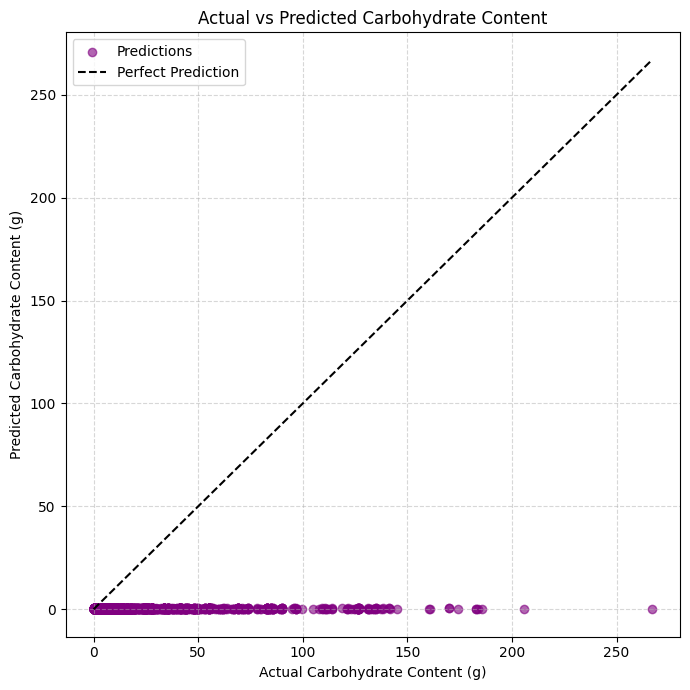

In [71]:
import matplotlib.pyplot as plt

# Load model and set to eval
weight_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
weight_model.eval()

# Collect all unique image paths
image_paths = df["ospath"].dropna().unique()

actual_weights = []
predicted_weights = []

# Process each image
for image_path in image_paths:
    food_items = preprocess_image(image_path, use_ground_truth=False)
    
    for label, img, feat, _ in food_items:
        # Predict weight
        with torch.no_grad():
            pred = weight_model(img, feat).item()

        actual = get_food_carbs(image_path, label)
        
        if actual is not None:
            predicted_weights.append(pred)
            actual_weights.append(actual)

# Scatter Plot
plt.figure(figsize=(7, 7))
plt.scatter(actual_weights, predicted_weights, color='purple', alpha=0.6, label="Predictions")

# Reference Line (Perfect Prediction)
min_val = min(min(actual_weights), min(predicted_weights))
max_val = max(max(actual_weights), max(predicted_weights))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Perfect Prediction")

plt.xlabel("Actual Carbohydrate Content (g)")
plt.ylabel("Predicted Carbohydrate Content (g)")
plt.title("Actual vs Predicted Carbohydrate Content")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
